# BIBLIOTECAS

In [1]:
import pandas as pd
import numpy as np
import yaml

from IPython.core.display   import HTML
from IPython.display        import Image

from scipy import  stats as ss

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, f1_score, recall_score, auc, roc_curve, balanced_accuracy_score
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from scipy.cluster import hierarchy
import scikitplot as skplt

from yellowbrick.classifier import PrecisionRecallCurve

import xgboost as xgb
import shap
import statsmodels.formula.api as smf

from feature_engine.encoding import RareLabelEncoder, OneHotEncoder, MeanEncoder

import warnings
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"]=12,8
pd.set_option('display.max_columns',30)

# FUNCOES AUXILIARES

In [2]:
def import_config(path_yaml):
    with open(path_yaml) as config_file:
        config = yaml.safe_load(config_file)
    return config


def reamostrar_lr(df, frac):

    x_train_2, x_test_2 = train_test_split(df, test_size = config['split']['test_size'], random_state=config['split']['seed'], stratify=df9_lr['pago'])

    sample = x_train_2[x_train_2['pago']==0].sample(frac=frac, random_state=config['split']['seed'])
    x_train_2 = x_train_2.drop(sample.index)
    print(x_train_2['pago'].value_counts(normalize=True))

    x_train = x_train_2.drop('pago', axis=1)
    y_train = x_train_2['pago']

    y_test = x_test_2['pago']

    return x_train, x_train_2, x_test_2.drop('pago', axis=1), y_test
    

def cramers_v(confusion_matrix):
   
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


def fs_kbest(x_train, y_train, x_test, y_test, model):
    k_vs_score_0 = []
    k_vs_score_1 = []

    for k in range(1, len(x_test.columns) + 1, 1):
        selector = SelectKBest(score_func=f_classif, k=k)

        Xtrain2 = selector.fit_transform(x_train, y_train)
        Xval2 = selector.transform(x_test)

        model.fit(Xtrain2, y_train)

        p = model.predict(Xval2)

        score_0 = round(metrics.f1_score(y_test, p, average=None)[0],3)
        score_1 = round(metrics.f1_score(y_test, p, average=None)[1],3)

        print("k= {} 0 F1_0 = {} - F1_1 = {}".format(k, score_0, score_1))
        k_vs_score_0.append(score_0)
        k_vs_score_1.append(score_1)

    pd.Series(k_vs_score_0, index=range(1, len(x_train.columns)+1,1)).plot(figsize=(10,7))
    pd.Series(k_vs_score_1, index=range(1, len(x_train.columns)+1,1)).plot(figsize=(10,7))

    plt.title('VISUALIZING METRIC', fontsize=10, weight='bold')
    plt.ylabel("F1 SCORE", fontsize=10, weight='bold')
    plt.xlabel("QTD FEATURES", fontsize=10, weight='bold')

    plt.show()

    selector = SelectKBest(score_func = f_classif, k=len(x_train.columns))
    selector.fit(x_train, y_train)

    pd.Series(selector.scores_, index=x_train.columns).sort_values().plot.barh()
    
    plt.show()

    df_score = pd.DataFrame({'variavel':x_train.columns, 'fs_score':selector.scores_, 'p_value': selector.pvalues_})
    df_score = df_score.sort_values('fs_score', ascending=False).reset_index(drop=True)
    display(df_score)

def label_pago(x):
    if x=='sim':
        return 0
    else:
        return 1

def cv_clf_metrics(model, df, target, cv, model_name, search=False):
    X = df.drop(target, axis=1)
    y = df[target]
    
    train_metrics = {'precision_0': [], 'precision_1': [], 'recall_0': [], 'recall_1': [], 'f1_0': [], 'f1_1': [], 'accuracy': [], 'roc_auc': [], 'balanced_accuracy': []}
    test_metrics = {'precision_0': [], 'precision_1': [], 'recall_0': [], 'recall_1': [], 'f1_0': [], 'f1_1': [], 'accuracy': [], 'roc_auc': [], 'balanced_accuracy': []}
    
    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        if(search==False):
            model.fit(X_train, y_train)
        else:
            pass

        train_predictions = model.predict(X_train)
        test_predictions = model.predict(X_test)
        
        train_predicions_proba = model.predict_proba(X_train)[:,1]
        test_predicions_proba = model.predict_proba(X_test)[:,1]
        
        
        # Calculate metrics for train
        train_metrics['precision_0'].append(np.round(precision_score(y_train, train_predictions, pos_label=0),3))
        train_metrics['recall_0'].append(np.round(recall_score(y_train, train_predictions, pos_label=0),3))
        train_metrics['f1_0'].append(np.round(f1_score(y_train, train_predictions, pos_label=0),3))
        train_metrics['accuracy'].append(np.round(accuracy_score(y_train, train_predictions),3))
        train_metrics['roc_auc'].append(np.round(roc_auc_score(y_train, train_predicions_proba),3))
        train_metrics['balanced_accuracy'].append(np.round(balanced_accuracy_score(y_train, train_predictions),3))
        train_metrics['precision_1'].append(np.round(precision_score(y_train, train_predictions, pos_label=1),3))
        train_metrics['recall_1'].append(np.round(recall_score(y_train, train_predictions, pos_label=1),3))
        train_metrics['f1_1'].append(np.round(f1_score(y_train, train_predictions, pos_label=1),3))
    
        
    # Calculate metrics for test
        
        test_metrics['precision_0'].append(np.round(precision_score(y_test, test_predictions, pos_label=0),3))
        test_metrics['recall_0'].append(np.round(recall_score(y_test, test_predictions, pos_label=0),3))
        test_metrics['f1_0'].append(np.round(f1_score(y_test, test_predictions, pos_label=0),3))
        test_metrics['accuracy'].append(np.round(accuracy_score(y_test, test_predictions),3))
        test_metrics['roc_auc'].append(np.round(roc_auc_score(y_test, test_predicions_proba),3))
        test_metrics['balanced_accuracy'].append(np.round(balanced_accuracy_score(y_test, test_predictions),3))
        test_metrics['precision_1'].append(np.round(precision_score(y_test, test_predictions, pos_label=1),3))
        test_metrics['recall_1'].append(np.round(recall_score(y_test, test_predictions, pos_label=1),3))
        test_metrics['f1_1'].append(np.round(f1_score(y_test, test_predictions, pos_label=1),3))
 
    train_precision_class_0   = train_metrics['precision_0']
    train_recall_class_0      = train_metrics['recall_0']
    train_f1_class_0          = train_metrics['f1_0']
    train_accuracy            = train_metrics['accuracy']
    train_roc_auc             = train_metrics['roc_auc']
    train_balanced_accuracy   = train_metrics['balanced_accuracy']
    train_precision_class_1   = train_metrics['precision_1']
    train_recall_class_1      = train_metrics['recall_1']
    train_f1_class_1          = train_metrics['f1_1']
       
            
    # Calculate metrics for test
            
    test_precision_class_0   = test_metrics['precision_0']
    test_recall_class_0      = test_metrics['recall_0']
    test_f1_class_0          = test_metrics['f1_0']
    test_accuracy            = test_metrics['accuracy']
    test_roc_auc             = test_metrics['roc_auc']
    test_balanced_accuracy   = test_metrics['balanced_accuracy']
    test_precision_class_1   = test_metrics['precision_1']
    test_recall_class_1      = test_metrics['recall_1']
    test_f1_class_1          = test_metrics['f1_1']
                

    print('TRAIN DATA')
    print(f'accuracy:          {train_accuracy} / media: {np.round(np.mean(train_accuracy),3)} / std: {np.round(np.std(train_accuracy),3)}')
    print(f'balanced_accuracy: {train_balanced_accuracy} / media: {np.round(np.mean(train_balanced_accuracy),3)} / std: {np.round(np.std(train_balanced_accuracy),3)}')
    print(f'roc_auc:           {train_roc_auc} / media: {np.round(np.mean(train_roc_auc),3)} / std: {np.round(np.std(train_roc_auc),3)}')
    print(f'f1_class_0:        {train_f1_class_0} / media: {np.round(np.mean(train_f1_class_0),3)} / std: {np.round(np.std(train_f1_class_0),3)}')
    print(f'f1_class_1:        {train_f1_class_1} / media: {np.round(np.mean(train_f1_class_1),3)} / std: {np.round(np.std(train_f1_class_1),3)}') 
    print(f'precision_class_0: {train_precision_class_0 } / media: {np.round(np.mean(train_precision_class_0 ),3)} / std: {np.round(np.std(train_precision_class_0),3)}')
    print(f'precision_class_1: {train_precision_class_1 } / media: {np.round(np.mean(train_precision_class_1 ),3)} / std: {np.round(np.std(train_precision_class_1),3)}') 
    print(f'recall_class_0 :   {train_recall_class_0 } / media: {np.round(np.mean(train_recall_class_0 ),3)} / std: {np.round(np.std(train_recall_class_0),3)}')
    print(f'recall_class_1 :   {train_recall_class_1 } / media: {np.round(np.mean(train_recall_class_1 ),3)} / std: {np.round(np.std(train_recall_class_1),3)}')
        
    print('\n---------------------------------------------------------------------------------------\n')
        
    print('TEST DATA')
    print(f'accuracy:          {test_accuracy} / media: {np.round(np.mean(test_accuracy),3)} / std: {np.round(np.std(test_accuracy),3)}')
    print(f'balanced_accuracy: {test_balanced_accuracy} / media: {np.round(np.mean(test_balanced_accuracy),3)} / std: {np.round(np.std(test_balanced_accuracy),3)}')
    print(f'roc_auc:           {test_roc_auc} / media: {np.round(np.mean(test_roc_auc),3)} / std: {np.round(np.std(test_roc_auc),3)}')
    print(f'f1_class_0:        {test_f1_class_0} / media: {np.round(np.mean(test_f1_class_0),3)} / std: {np.round(np.std(test_f1_class_0),3)}')
    print(f'f1_class_1:        {test_f1_class_1} / media: {np.round(np.mean(test_f1_class_1),3)} / std: {np.round(np.std(test_f1_class_1),3)}')  
    print(f'precision_class_0: {test_precision_class_0 } / media: {np.round(np.mean(test_precision_class_0 ),3)} / std: {np.round(np.std(test_precision_class_0),3)}')
    print(f'precision_class_1: {test_precision_class_1 } / media: {np.round(np.mean(test_precision_class_1 ),3)} / std: {np.round(np.std(test_precision_class_1),3)}') 
    print(f'recall_class_0 :   {test_recall_class_0 } / media: {np.round(np.mean(test_recall_class_0 ),3)} / std: {np.round(np.std(test_recall_class_0),3)}')
    print(f'recall_class_1 :   {test_recall_class_1 } / media: {np.round(np.mean(test_recall_class_1 ),3)} / std: {np.round(np.std(test_recall_class_1),3)}')
        
        
    result = pd.DataFrame( {'Model Name': model_name,
                                'Accuracy CV': np.round( np.mean( test_accuracy ), 3).astype( str ) + '+/-' + np.round( np.std( test_accuracy ),3 ).astype( str ),
                                'Balanced Accuracy CV': np.round( np.mean( test_balanced_accuracy  ), 3).astype( str ) + '+/-' + np.round( np.std( test_balanced_accuracy  ),3 ).astype( str ),
                                'Roc Auc Score CV': np.round( np.mean( test_roc_auc ), 3).astype( str ) + '+/-' + np.round( np.std( test_roc_auc ),3 ).astype( str ),
                                'Precision Class 0 CV': np.round( np.mean( test_precision_class_0 ), 3).astype( str ) + '+/-' + np.round( np.std( test_precision_class_0 ),3 ).astype( str ),
                                'Precision Class 1 CV': np.round( np.mean( test_precision_class_1 ), 3).astype( str ) + '+/-' + np.round( np.std( test_precision_class_1 ),3 ).astype( str ),
                                'Recall Class 0 CV': np.round( np.mean( test_recall_class_0  ), 3).astype( str ) + '+/-' + np.round( np.std( test_recall_class_0 ),3 ).astype( str ),
                                'Recall Class 1 CV': np.round( np.mean( test_recall_class_1  ), 3).astype( str ) + '+/-' + np.round( np.std( test_recall_class_1 ),3 ).astype( str ),
                                'F1 Score Class 0 CV': np.round( np.mean( test_f1_class_0 ), 3).astype( str ) + '+/-' + np.round( np.std( test_f1_class_0),3 ).astype( str ),
                                'F1 Score Class 1 CV': np.round( np.mean( test_f1_class_1 ), 3).astype( str ) + '+/-' + np.round( np.std( test_f1_class_1),3 ).astype( str )} , index=[0])
    display(result)
    return result


def cm_roc_plot(model, x_test, y_test, th=0.5):
    
    yhat_lr = model.predict(x_test)
    print(pd.crosstab(y_test, yhat_lr, rownames=['Real'], colnames=['     Predito'], margins=True))
    print('\n\n')
    print(metrics.classification_report(y_test, yhat_lr))
    print('\n')
    
    yhat_lr_prob = model.predict_proba(x_test)[:,1]

    
    lr_auc = round(roc_auc_score(y_test, yhat_lr_prob),2)
    print(f' ROC_AUC {lr_auc}')
    
    lr_frp, lr_tpr, _ = metrics.roc_curve(y_test, yhat_lr_prob)

    fig, ax = plt.subplots(figsize=(12,8))
    
    plt.plot(lr_frp, lr_tpr, linestyle='--', label = 'prediction (AUROC = %0.3f)' % lr_auc)
    
    ax.plot([0,1],[0,1], transform=ax.transAxes)
    
    #Title
    plt.title('ROC Plot',fontsize=15, weight='bold')
    
    #Axis labels
    
    plt.xticks(fontsize=15, weight='bold')
    plt.yticks(fontsize=15, weight='bold');
    
    plt.ylabel('True positive rate',fontsize=15, weight='bold')
    # recall class 1 = True positive rate (TP / (TP + FN)
    plt.xlabel('False positive rate ',fontsize=15, weight='bold')
    # recall class 0 = 1 - False positive rate (FP / (FP + TN)
    
    plt.legend()
    plt.show()

    yhat_lr_2  = (yhat_lr_prob > th).astype(int)
    print(pd.crosstab(y_test, yhat_lr_2, rownames=['Real'], colnames=['     Predito'], margins=True))
    print('\n\n')
    print(metrics.classification_report(y_test, yhat_lr_2))
    print('\n')

def test_metric(model, x_test, y_test, model_name):
        
    test_metrics = {'accuracy': [], 'balanced_accuracy': [], 'roc_auc': [], 'precision_0': [], 
                     'precision_1': [], 'recall_0': [], 'recall_1': [], 'f1_0': [], 'f1_1': []}

    # Test evaluation metrics
    test_predictions = model.predict(x_test)
    test_predicions_proba = model.predict_proba(x_test)[:,1]

    test_metrics['accuracy'].append(np.round(accuracy_score(y_test, test_predictions),3))
    test_metrics['balanced_accuracy'].append(np.round(balanced_accuracy_score(y_test, test_predictions),3))
    test_metrics['roc_auc'].append(np.round(roc_auc_score(y_test, test_predicions_proba),3))
    test_metrics['precision_0'].append(np.round(precision_score(y_test, test_predictions, pos_label=0),3))
    test_metrics['precision_1'].append(np.round(precision_score(y_test, test_predictions, pos_label=1),3))
    test_metrics['recall_0'].append(np.round(recall_score(y_test, test_predictions, pos_label=0),3))
    test_metrics['recall_1'].append(np.round(recall_score(y_test, test_predictions, pos_label=1),3))
    test_metrics['f1_0'].append(np.round(f1_score(y_test, test_predictions, pos_label=0),3))
    test_metrics['f1_1'].append(np.round(f1_score(y_test, test_predictions, pos_label=1),3))
   
    # Create pandas DataFrames
    test_df = pd.DataFrame(test_metrics)

    test_df['model_name'] = model_name

    return  test_df


def tabela_resultado_final(df):
    num_attributes = df.select_dtypes (include=['int16', 'int32', 'int64', 'float32', 'float64'])
    cat_attributes = df.select_dtypes (exclude=['int16', 'int32', 'int64', 'float32', 'float64', 'datetime64[ns]'])

    aux_cluster = pd.DataFrame()
    aux = pd.DataFrame()
    aux_2 = pd.DataFrame()

    for coluna in num_attributes.columns[:-1]:
        if aux.empty:
            aux = df.groupby('cluster')[coluna].mean().reset_index()
        else:
            aux = df.groupby('cluster')[coluna].mean()

        aux_cluster = pd.concat([aux_cluster,aux], axis=1)
        
    for coluna in cat_attributes.columns:
        aux_2 = df.groupby(['cluster', coluna]).size().unstack(fill_value=0).reset_index(drop=True).apply(lambda x: round(x / x.sum(),2), axis=1)
        aux_cluster = pd.concat([aux_cluster, aux_2], axis=1)

    aux_cluster['contagem'] = df.groupby('cluster')['cluster'].count().reset_index(drop=True)
    total_count = aux_cluster['contagem'].sum()
    aux_cluster['Percentage'] = round((aux_cluster['contagem']/total_count)*100, 1)

    display(aux_cluster.sort_values('inadimplente').T.style.format("{:.2f}").background_gradient(axis = 1))
 
def silhouette_score(df, model, k_start, k_end):
    cluster_list = []
    n_cluster = list(range(k_start, k_end +1))

    for k in n_cluster:

        if(model == 'gmm'):
            cluster_model = GaussianMixture(n_components=k, random_state= config['split']['seed'])
            cluster_model.fit(df)
            labels = cluster_model.predict(df)
        elif(model == 'kmeans'):
            cluster_model = KMeans(n_clusters=k, random_state= config['split']['seed'])
            cluster_model.fit(df)
            labels = cluster_model.predict(df)
            
        elif(model == 'hierarchy'):
            cluster_model = hierarchy.linkage(df, 'ward')
            labels = hierarchy.fcluster( model, k, criterion='maxclust')

        sil = metrics.silhouette_score(df, labels, metric='euclidean')
        cluster_list.append(sil)
        
    plt.plot(n_cluster, cluster_list, linestyle='--', marker='o', color = 'b')
    plt.xlabel('K');
    plt.ylabel('Silhoutte Score');
    plt.title('Silhoutte Score x K')
    plt.show()



def roi_at_budget(data, budget):

    data = data.reset_index(drop=True)
    data['ranking'] = data.index + 1
    
    data['acc_valor_emprestimo'] = data['valor_emprestimo'].cumsum()
    aux_budget = 0

    for i in range(0, len(data) + 1):
        if(data.loc[i, 'acc_valor_emprestimo'] < budget):
            aux_budget = i
        else:
            break

    data_roi = data.iloc[:aux_budget]

    data_roi = data_roi.groupby(['pago', 'pred_050']).agg(
    valor_emprestimo = ('valor_emprestimo','sum'),
    juros = ('juros','sum'),
    multa = ('multa','sum'),
    emprestimo_atualizado = ('valor_emprestimo_atualizado','sum'),
    ).reset_index()

    display(data_roi)
    valor_emprestimo = data_roi['valor_emprestimo'].sum()
    retorno = 0

    for i in range(0, len(data_roi)):

        if(data_roi.loc[i, 'pago'] == 0 and data_roi.loc[i, 'pred_050'] == 0):
            retorno = retorno + data_roi.loc[i, 'juros'] + data_roi.loc[i, 'multa'] 

        elif(data_roi.loc[i, 'pago'] == 0 and data_roi.loc[i, 'pred_050'] == 1):
            retorno = retorno + data_roi.loc[i, 'juros'] + data_roi.loc[i, 'multa']

        elif(data_roi.loc[i, 'pago'] == 1 and data_roi.loc[i, 'pred_050'] == 0):
            retorno = retorno - data_roi.loc[i, 'valor_emprestimo']

        elif(data_roi.loc[i, 'pago'] == 1 and data_roi.loc[i, 'pred_050'] == 1):
            retorno = retorno - data_roi.loc[i, 'valor_emprestimo']

    print(f"Budget {valor_emprestimo}")
    print(f"Lucro value {round((retorno ),2)}")
    print(f"ROI value {round((retorno / valor_emprestimo),2)}")
    print(f"Numero de Clientes {aux_budget}")


 def precision_at_k_class(data, k, classe):
    data = data.reset_index(drop=True)

    data['ranking'] = data.index + 1

    data['correct_target'] = data.apply(lambda x: 1 if(x['pred_050'] == classe and x['pago'] == classe) else 0, axis=1)

    data['precision_at_k'] = data['correct_target'].cumsum() /  data['ranking']
    return round(data.loc[k, 'precision_at_k'], 2)


def recall_at_k_class(data, k, classe):
    
    # reset index
    data = data.reset_index(drop=True)
    # create ranking order
    data['ranking'] = data.index + 1

    data['correct_target'] = data.apply(lambda x: 1 if (x['pred_050'] == classe and x['pago'] == classe) else 0, axis=1)

    data['recall_at_k'] = data['correct_target'].cumsum() / data[data['pago']==classe]['pago'].count()
    return round(data.loc[k, 'recall_at_k'],2)

def desvio_padrao(prob_inadimplencia, valor_emprestimo, retorno_investimento, valor_esperado):
    prob_adimplencia = 1 - prob_inadimplencia
    variancia = (((retorno_investimento - valor_esperado) ** 2) * prob_adimplencia) + ((( -valor_emprestimo - valor_esperado) ** 2) * prob_inadimplencia)
    dp = np.sqrt(variancia)
    return dp


def ROI(pago, valor_emprestimo, retorno_investimento):
    
    if(pago==1):
        ROI = round((-valor_emprestimo / valor_emprestimo),2)
    else:
        ROI = round((retorno_investimento / valor_emprestimo),2)

    return ROI


def maximizar_ROI(x_test, df_business, model, custo_oportunidade):

    ROI_list = []
    th_list = [i/100 for i in range(1,101)]
    lucro_list = []

    for th in th_list:

        df_resultado = df_business.copy()

        df_resultado['pred_' + str(th)] = (model.predict_proba(x_test)[:,1]>=th).astype(int)

        df_aux = df_resultado.groupby(['pago', 'pred_' + str(th)]).agg(
        valor_emprestimo = ('valor_emprestimo','sum'),
        juros = ('juros','sum'),
        multa = ('multa','sum'),
        emprestimo_atualizado = ('valor_emprestimo_atualizado','sum'),
        ).reset_index()
        
        #print(th)
        #display(df_aux)
        
        if(len(df_aux)<4):
            lucro_geral = 0
            ROI = 0

        else:
            valor_emprestimo_total = df_aux['valor_emprestimo'].sum()
            lucro_geral = (df_aux['juros'][0] + df_aux['multa'][0]) + (df_aux['valor_emprestimo'][1] * custo_oportunidade)  - (df_aux['valor_emprestimo'][2]) + (df_aux['valor_emprestimo'][3] * custo_oportunidade)
            ROI = round(lucro_geral /  valor_emprestimo_total,2)

        ROI_list.append(ROI)
        lucro_list.append(lucro_geral)

    plt.plot(th_list, ROI_list, linestyle='--', marker = 'o', color = 'b')
    plt.xlabel('TH')
    plt.ylabel('ROI')
    plt.title('ROI X TH')
    plt.show()

    plt.plot(th_list,lucro_list, linestyle='--', marker = 'o', color = 'b')
    plt.xlabel('TH')
    plt.ylabel('LUCRO')
    plt.title('LUCRO X TH')
    plt.show()

    print(f'Max ROI value {max(ROI_list)}')
    print(f"Max LUCRO {lucro_list[ROI_list.index(max(ROI_list))]}")
    print(f"BEST TH {th_list[ROI_list.index(max(ROI_list))]}")

# 1.0 IMPORT DATA AND CONFIG

## 1.1 CONFIG

In [3]:
config = import_config('config.yaml')

In [4]:
config

{'split': {'seed': 42, 'test_size': 0.2},
 'data': {'raw_path': '../data/raw_data/raw_data.csv',
  'trusted_path': '../data/trusted_data/trusted_data.csv',
  'train_path': '../data/train_data/train_data.csv',
  'test_path': '../data/test_data/test_data.csv'},
 'imagem': {'path': '../imagens/mind map.png'}}

In [5]:
config['data']['raw_path']

'../data/raw_data/raw_data.csv'

## 1.2 DATA

In [6]:
df1 = pd.read_csv(config['data']['raw_path'])

In [7]:
df1.head()

escolaridade  renda_mensal_informal dependentes  \
0          NaN                    NaN           S   
1  nivel medio              1894.5078           N   
2  nivel medio                    NaN           S   
3          NaN                    NaN           N   
4          NaN                    NaN           S   

                     estado_civil  idade conta_poupanca conta_salario  \
0                        solteiro     36              S             N   
1                        solteiro     39              S             N   
2                        solteiro     26              S             N   
3  casado(a) com comunhao de bens     23              N             N   
4                        solteiro     33              S             N   

   qtd_fonte_renda cheque_sem_fundo conta_conjunta  valor_conta_corrente  \
0              NaN                S              N                   NaN   
1              1.0                N              N                   NaN   
2              1.0                N              N                   NaN   
3              NaN                S              N                   NaN   
4              NaN                S              N                   NaN   

   valor_conta_poupanca  valor_emprestimo     multa      juros  \
0                   NaN           8174.32    263.25    5844.98   
1                   NaN          41775.63   1607.29    7652.26   
2                   NaN         522940.27  24860.40  319315.62   
3                   NaN           1418.00  21472.36    2967.48   
4                   NaN           2078.97     19.44      46.35   

   valor_emprestimo_atualizado pago         id     genero        data  \
0                     14282.55  sim  309652396   feminino  2020-01-01   
1                     51035.18  sim  498764591   feminino  2020-01-01   
2                    867116.29  sim  504868288  masculino  2020-01-01   
3                     25857.84  sim  541365315   feminino  2020-01-01   
4                      2144.76  sim  563622907  masculino  2020-01-01   

           estado  
0    minas gerais  
1  espirito santo  
2       sao paulo  
3       sao paulo  
4  espirito santo

# 2.0 DATA CLEAN

In [8]:
df2 = df1.copy()

## 2.1 DESCRICAO DOS DADOS

In [9]:
df2.head()

escolaridade  renda_mensal_informal dependentes  \
0          NaN                    NaN           S   
1  nivel medio              1894.5078           N   
2  nivel medio                    NaN           S   
3          NaN                    NaN           N   
4          NaN                    NaN           S   

                     estado_civil  idade conta_poupanca conta_salario  \
0                        solteiro     36              S             N   
1                        solteiro     39              S             N   
2                        solteiro     26              S             N   
3  casado(a) com comunhao de bens     23              N             N   
4                        solteiro     33              S             N   

   qtd_fonte_renda cheque_sem_fundo conta_conjunta  valor_conta_corrente  \
0              NaN                S              N                   NaN   
1              1.0                N              N                   NaN   
2              1.0                N              N                   NaN   
3              NaN                S              N                   NaN   
4              NaN                S              N                   NaN   

   valor_conta_poupanca  valor_emprestimo     multa      juros  \
0                   NaN           8174.32    263.25    5844.98   
1                   NaN          41775.63   1607.29    7652.26   
2                   NaN         522940.27  24860.40  319315.62   
3                   NaN           1418.00  21472.36    2967.48   
4                   NaN           2078.97     19.44      46.35   

   valor_emprestimo_atualizado pago         id     genero        data  \
0                     14282.55  sim  309652396   feminino  2020-01-01   
1                     51035.18  sim  498764591   feminino  2020-01-01   
2                    867116.29  sim  504868288  masculino  2020-01-01   
3                     25857.84  sim  541365315   feminino  2020-01-01   
4                      2144.76  sim  563622907  masculino  2020-01-01   

           estado  
0    minas gerais  
1  espirito santo  
2       sao paulo  
3       sao paulo  
4  espirito santo

In [10]:
df2.head().T

0               1            2  \
escolaridade                          NaN     nivel medio  nivel medio   
renda_mensal_informal                 NaN       1894.5078          NaN   
dependentes                             S               N            S   
estado_civil                     solteiro        solteiro     solteiro   
idade                                  36              39           26   
conta_poupanca                          S               S            S   
conta_salario                           N               N            N   
qtd_fonte_renda                       NaN             1.0          1.0   
cheque_sem_fundo                        S               N            N   
conta_conjunta                          N               N            N   
valor_conta_corrente                  NaN             NaN          NaN   
valor_conta_poupanca                  NaN             NaN          NaN   
valor_emprestimo                  8174.32        41775.63    522940.27   
multa                              263.25         1607.29      24860.4   
juros                             5844.98         7652.26    319315.62   
valor_emprestimo_atualizado      14282.55        51035.18    867116.29   
pago                                  sim             sim          sim   
id                              309652396       498764591    504868288   
genero                           feminino        feminino    masculino   
data                           2020-01-01      2020-01-01   2020-01-01   
estado                       minas gerais  espirito santo    sao paulo   

                                                          3               4  
escolaridade                                            NaN             NaN  
renda_mensal_informal                                   NaN             NaN  
dependentes                                               N               S  
estado_civil                 casado(a) com comunhao de bens        solteiro  
idade                                                    23              33  
conta_poupanca                                            N               S  
conta_salario                                             N               N  
qtd_fonte_renda                                         NaN             NaN  
cheque_sem_fundo                                          S               S  
conta_conjunta                                            N               N  
valor_conta_corrente                                    NaN             NaN  
valor_conta_poupanca                                    NaN             NaN  
valor_emprestimo                                     1418.0         2078.97  
multa                                              21472.36           19.44  
juros                                               2967.48           46.35  
valor_emprestimo_atualizado                        25857.84         2144.76  
pago                                                    sim             sim  
id                                                541365315       563622907  
genero                                             feminino       masculino  
data                                             2020-01-01      2020-01-01  
estado                                            sao paulo  espirito santo

## 2.2 DIMENSAO DOS DADOS

In [11]:
df2.shape

(50390, 21)

## 2.3 TIPO DA COLUNA

In [12]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50390 entries, 0 to 50389
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   escolaridade                 14615 non-null  object 
 1   renda_mensal_informal        9768 non-null   float64
 2   dependentes                  50390 non-null  object 
 3   estado_civil                 50390 non-null  object 
 4   idade                        50390 non-null  int64  
 5   conta_poupanca               50390 non-null  object 
 6   conta_salario                50390 non-null  object 
 7   qtd_fonte_renda              12806 non-null  float64
 8   cheque_sem_fundo             50390 non-null  object 
 9   conta_conjunta               50390 non-null  object 
 10  valor_conta_corrente         0 non-null      float64
 11  valor_conta_poupanca         0 non-null      float64
 12  valor_emprestimo             50390 non-null  float64
 13  multa           

## 2.4 CHECAR NAN VALUES

In [13]:
df2.isna().sum() / len(df2)

escolaridade                   0.709962
renda_mensal_informal          0.806152
dependentes                    0.000000
estado_civil                   0.000000
idade                          0.000000
conta_poupanca                 0.000000
conta_salario                  0.000000
qtd_fonte_renda                0.745862
cheque_sem_fundo               0.000000
conta_conjunta                 0.000000
valor_conta_corrente           1.000000
valor_conta_poupanca           1.000000
valor_emprestimo               0.000000
multa                          0.000000
juros                          0.000000
valor_emprestimo_atualizado    0.000000
pago                           0.000000
id                             0.000000
genero                         0.000000
data                           0.000000
estado                         0.000000
dtype: float64

## 2.5 DROPAR LINHAS DUPLICADAS

In [14]:
df2.shape

(50390, 21)

In [15]:
df2.drop_duplicates().shape

(50390, 21)

## 2.6 MUDAR TIPO DA VARIAVEL

In [16]:
df2['data'] = df2['data'].astype('datetime64[ns]')

## 2.7 DROPAR COLUNAS

In [17]:
# 100% vazio nao tem como trabalhar o dado
df2= df2.drop(['valor_conta_corrente', 'valor_conta_poupanca'], axis=1)

df2= df2.drop(['escolaridade', 'renda_mensal_informal', 'qtd_fonte_renda', 'data'], axis=1)

## 2.8 ESTATISCA DESCRITIVA

In [18]:
num_attributes = df2.select_dtypes(include=['int32', 'int64', 'float32', 'float64'])

cat_attributes = df2.select_dtypes(exclude=['int32', 'int64', 'float32', 'float64', 'datetime64[ns]'])

### 2.8.1 VARIAVEIS NUMERICAS 

In [19]:
#Tendencia central - mean, median

ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

#Dispersão - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame ( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame ( num_attributes.apply( min ) ).T
d3 = pd.DataFrame ( num_attributes.apply( max ) ).T
d4 = pd.DataFrame ( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame ( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame ( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ( [ 'attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'])

m.head()

attributes      min           max         range  \
0                        idade    18.00  1.130000e+02  9.500000e+01   
1             valor_emprestimo  1393.00  2.867894e+08  2.867880e+08   
2                        multa     0.00  5.737759e+08  5.737759e+08   
3                        juros     0.00  5.703619e+08  5.703619e+08   
4  valor_emprestimo_atualizado  1397.04  1.430927e+09  1.430926e+09   

            mean    median           std        skew      kurtosis  
0      31.724529    30.000  8.565032e+00    1.959951      7.223175  
1   51988.873901  2298.035  1.588803e+06  135.859233  22605.724510  
2   60226.580975   648.965  2.843913e+06  171.305766  33333.600930  
3   64853.905193  1143.320  2.728143e+06  184.431138  38002.805365  
4  177069.360068  5652.695  7.058294e+06  171.822788  33820.743108

In [20]:
num_attributes.describe(percentiles=[0.99, 0.95, 0.75, 0.5]).T

count          mean           std  \
idade                        50390.0  3.172453e+01  8.565117e+00   
valor_emprestimo             50390.0  5.198887e+04  1.588819e+06   
multa                        50390.0  6.022658e+04  2.843941e+06   
juros                        50390.0  6.485391e+04  2.728170e+06   
valor_emprestimo_atualizado  50390.0  1.770694e+05  7.058364e+06   
id                           50390.0  5.485969e+08  2.601500e+08   

                                      min           50%           75%  \
idade                        1.800000e+01  3.000000e+01  3.500000e+01   
valor_emprestimo             1.393000e+03  2.298035e+03  7.172175e+03   
multa                        0.000000e+00  6.489650e+02  3.600000e+03   
juros                        0.000000e+00  1.143320e+03  5.545427e+03   
valor_emprestimo_atualizado  1.397040e+03  5.652695e+03  1.903061e+04   
id                           1.000172e+08  5.482058e+08  7.737146e+08   

                                      95%           99%           max  
idade                        4.800000e+01  6.200000e+01  1.130000e+02  
valor_emprestimo             5.879202e+04  4.464769e+05  2.867894e+08  
multa                        6.189092e+04  5.039267e+05  5.737759e+08  
juros                        8.235361e+04  6.408426e+05  5.703619e+08  
valor_emprestimo_atualizado  2.006742e+05  1.586720e+06  1.430927e+09  
id                           9.542667e+08  9.912031e+08  9.999988e+08

### 2.8.2 VARAIVEIS CATEGORIAS

In [21]:
for i in cat_attributes.columns:
     print(cat_attributes[i].value_counts(normalize=True))
     print('==========================================\n\n')

dependentes
N    0.639968
S    0.360032
Name: proportion, dtype: float64


estado_civil
solteiro                                  0.547053
casado(a) com comunhao parcial de bens    0.263604
casado(a) com comunhao de bens            0.154098
casado(a) com separacao de bens           0.030959
separado judicialmente                    0.001469
divorciado                                0.001330
viuvo(a)                                  0.000814
outros                                    0.000675
Name: proportion, dtype: float64


conta_poupanca
S    0.847986
N    0.152014
Name: proportion, dtype: float64


conta_salario
N    0.976603
S    0.023397
Name: proportion, dtype: float64


cheque_sem_fundo
S    0.769974
N    0.230026
Name: proportion, dtype: float64


conta_conjunta
N    0.958285
S    0.041715
Name: proportion, dtype: float64


pago
sim    0.790891
nao    0.209109
Name: proportion, dtype: float64


genero
masculino    0.501667
feminino     0.498333
Name: proportion, dtype: float64


# 3.0 MIND MAP E ENGENHARIA DE VARIAVEIS

In [22]:
df3 = df2.copy()

## 3.1 MIND MAP

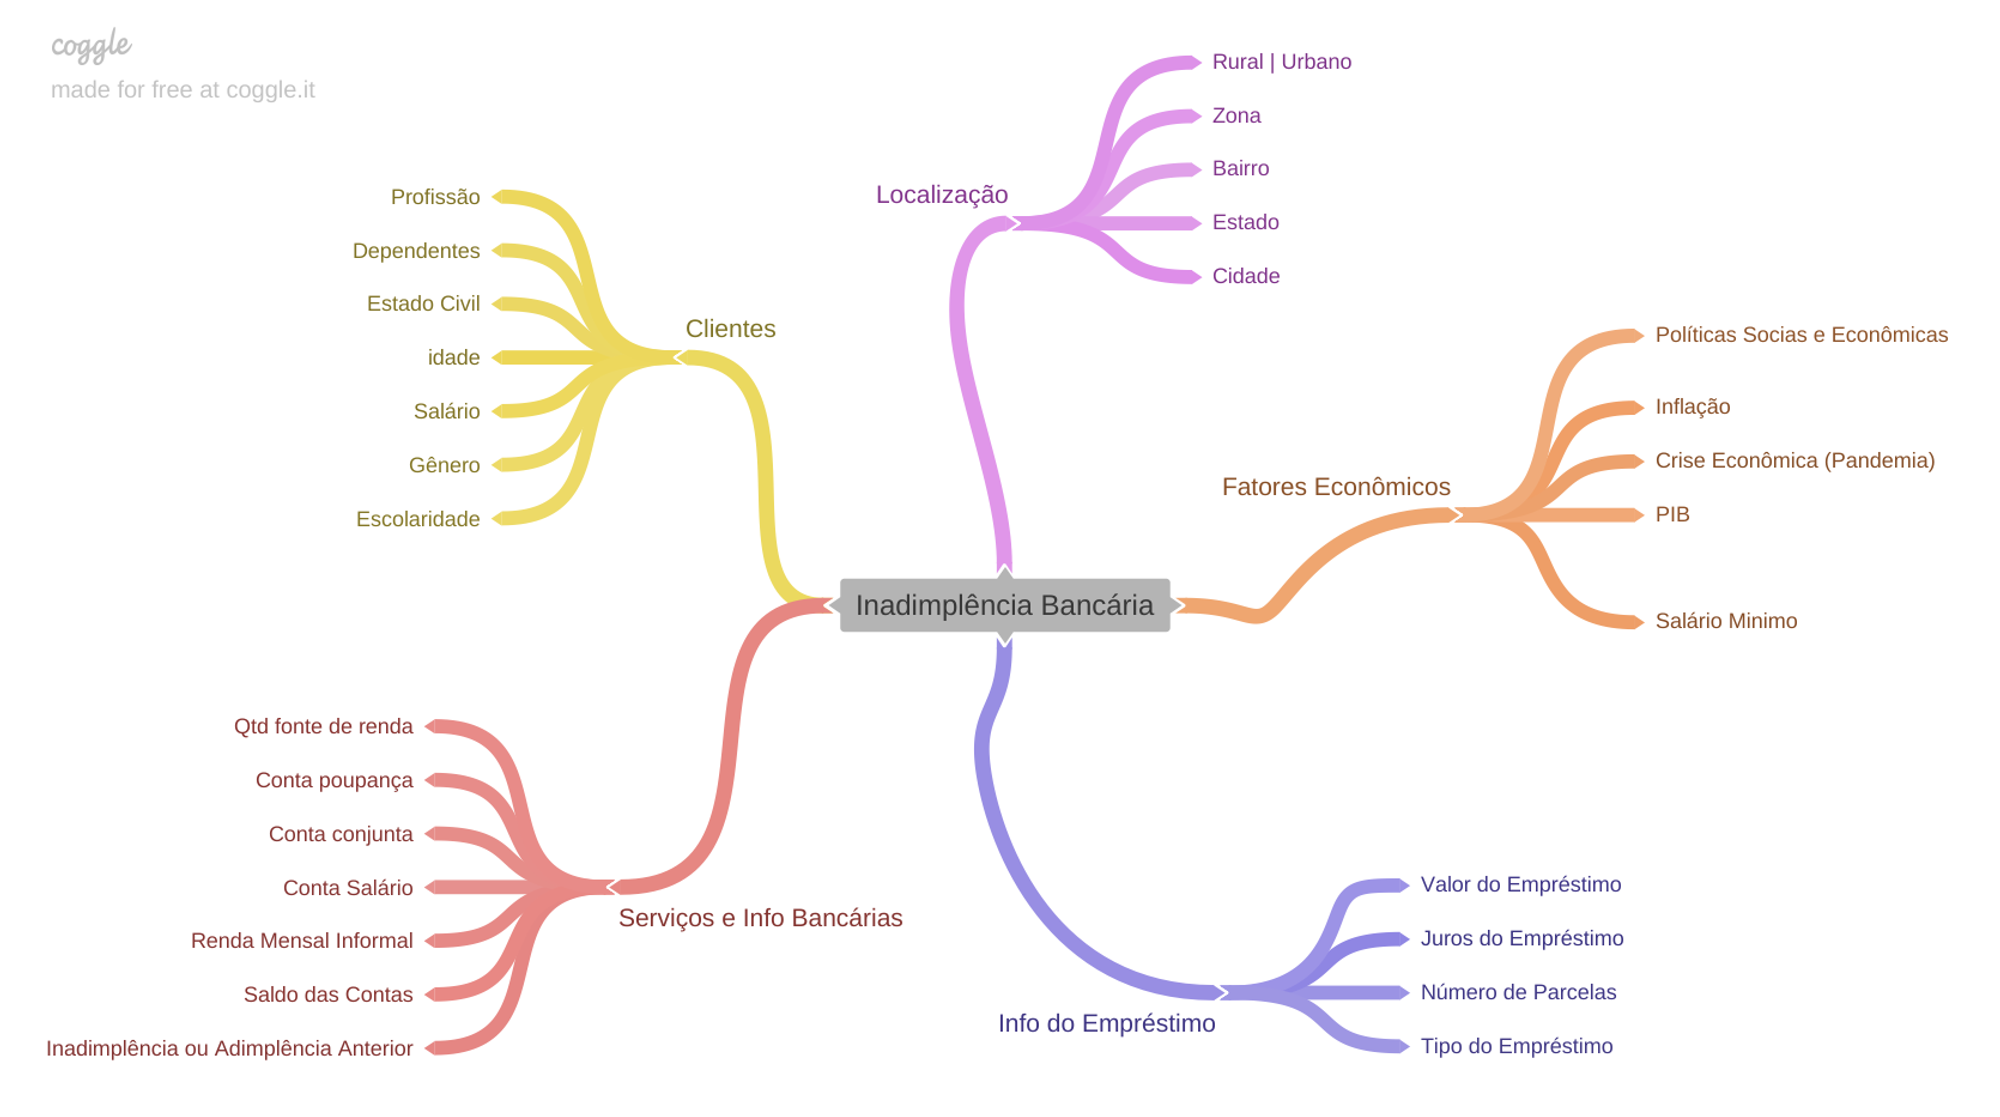

In [23]:
Image(config['imagem']['path'])

### Hipóteses de Informações dos Clientes

**1.** Mulheres são em média 10% mais ADIMPLENTES.

**2.** Clientes com Menos de 60 anos são em média 20% mais ADIMPLENTES.

**3.** Clientes com Dependentes são em média 15% mais ADIMPLENTES.

**4.** Clientes que são solteiros tem uma taxa percentual maior de INADIMPLÊNCIA que os demais.

### Hipóteses de Informações Bancárias

**5.** Clientes com conta salário são em média 30% mais ADIMPLENTES.

**6.** Clientes com conta poupança são em média 10% mais ADIMPLENTES.

**7.** Clientes que já passaram cheque sem fundo são em média 15% mais INADIMPLENTES.

**8.** Clientes que tem conta conjunta são em média 10% mais INADIMPLENTES.

### Hipóteses de Informações do Empréstimo

**9.** Clientes que pegaram empréstimos de mais de RS$20000 tem tendência a ser INADIMPLENTES.

### Hipóteses de Informações de Localização

**10.** Clientes que moram no Estado RJ E SP tem maior percentual de ADIMPLENTE do que ES e MG.

## 3.2 ENGENHARIA DE VARIAVEIS

In [24]:
df3['juros_porcentagem'] = df3['juros']/df3['valor_emprestimo']

# 4.0 EDA UNIVARIDA

In [25]:
df4 = df3.copy()

## 4.1 NUMERICA

In [26]:
num_attributes = df4.select_dtypes(include=['int32', 'int64', 'float32', 'float64'])

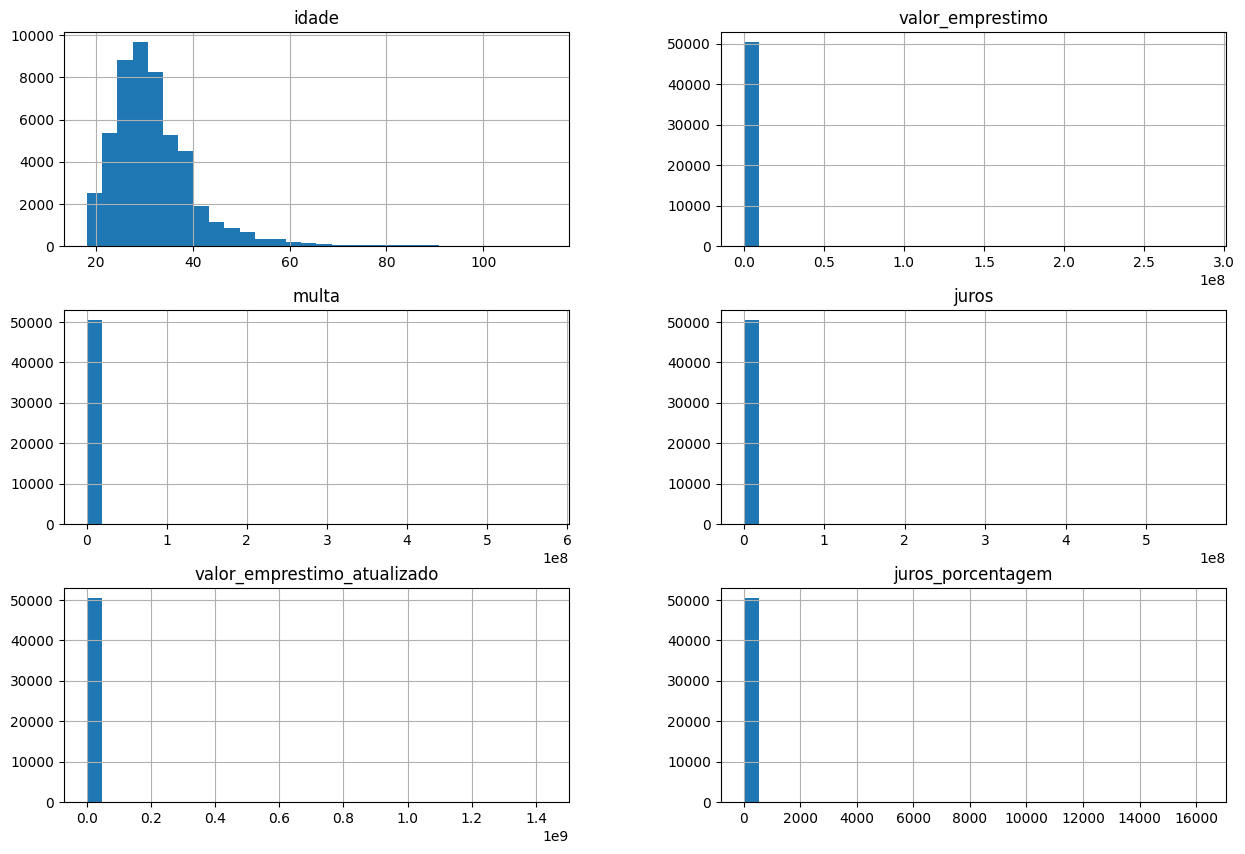

In [27]:
num_attributes.drop('id', axis=1).hist(bins=30, figsize=(15,10));

### 4.1.1 IDADE

count    50390.000000
mean        31.724529
std          8.565117
min         18.000000
25%         26.000000
50%         30.000000
75%         35.000000
max        113.000000
Name: idade, dtype: float64


Text(0.5, 1.0, 'boxplot')

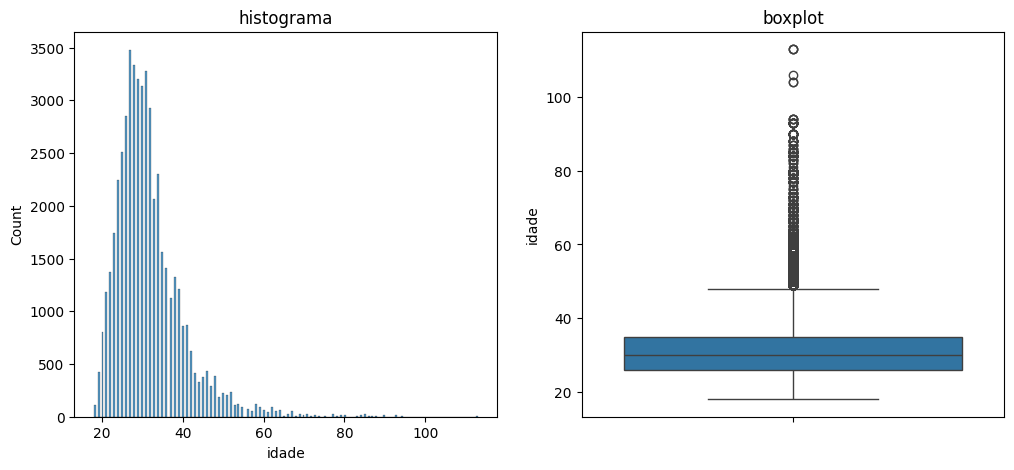

In [28]:
print(df4['idade'].describe())
fig, axes = plt.subplots(1,2 ,figsize=(12,5))

sns.histplot(df4['idade'], ax=axes[0])
axes[0].set_title('histograma')

sns.boxplot(df4['idade'], ax=axes[1])
axes[1].set_title('boxplot')

### 4.1.2 VALOR DO EMPRESTIMO

count    5.039000e+04
mean     5.198887e+04
std      1.588819e+06
min      1.393000e+03
25%      1.622370e+03
50%      2.298035e+03
75%      7.172175e+03
max      2.867894e+08
Name: valor_emprestimo, dtype: float64


Text(0.5, 1.0, 'boxplot')

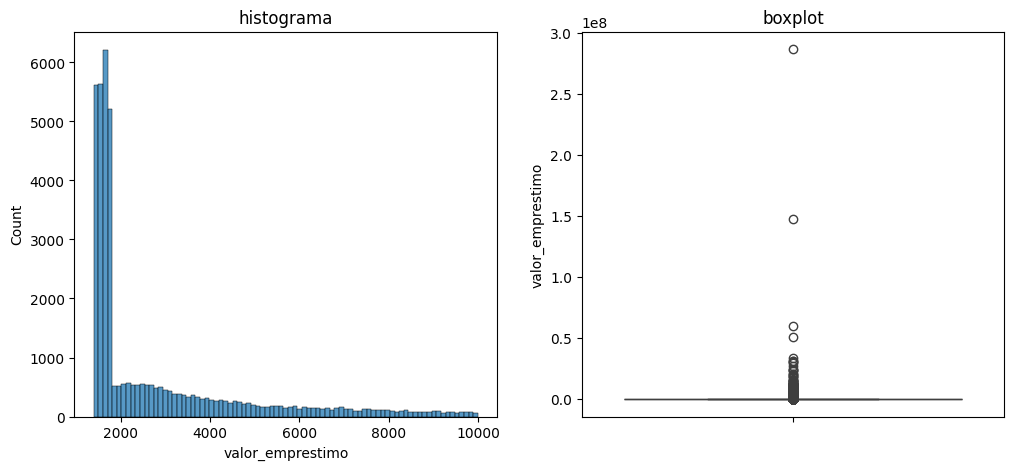

In [29]:
print(df4['valor_emprestimo'].describe())
fig, axes = plt.subplots(1,2 ,figsize=(12,5))

sns.histplot(df4[df4['valor_emprestimo']<10000]['valor_emprestimo'], ax=axes[0])
axes[0].set_title('histograma')

sns.boxplot(df4['valor_emprestimo'], ax=axes[1])
axes[1].set_title('boxplot')

### 4.1.3 MULTA

count    5.039000e+04
mean     6.022658e+04
std      2.843941e+06
min      0.000000e+00
25%      1.325675e+02
50%      6.489650e+02
75%      3.600000e+03
max      5.737759e+08
Name: multa, dtype: float64


Text(0.5, 1.0, 'boxplot')

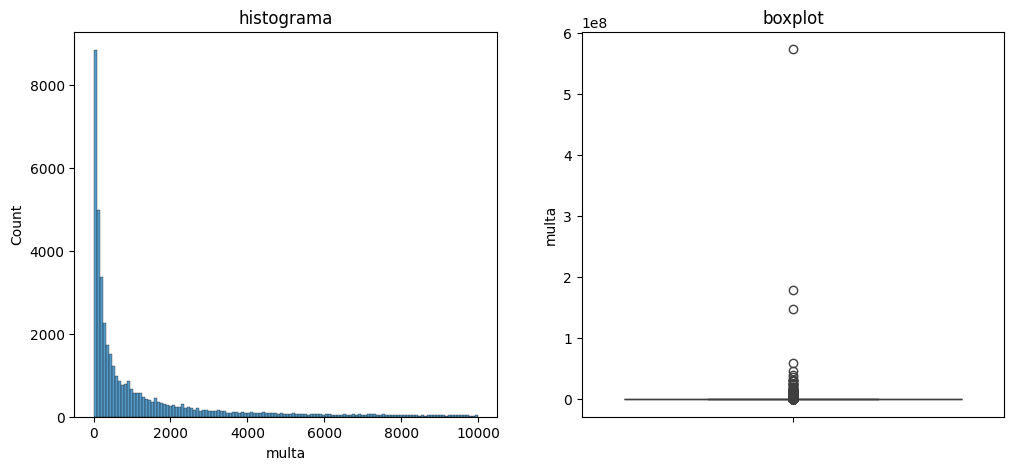

In [30]:
print(df4['multa'].describe())
fig, axes = plt.subplots(1,2 ,figsize=(12,5))

sns.histplot(df4[df4['multa']<10000]['multa'], ax=axes[0])
axes[0].set_title('histograma')

sns.boxplot(df4['multa'], ax=axes[1])
axes[1].set_title('boxplot')

### 4.1.4 JUROS

count    5.039000e+04
mean     6.485391e+04
std      2.728170e+06
min      0.000000e+00
25%      2.742725e+02
50%      1.143320e+03
75%      5.545427e+03
max      5.703619e+08
Name: juros, dtype: float64


Text(0.5, 1.0, 'boxplot')

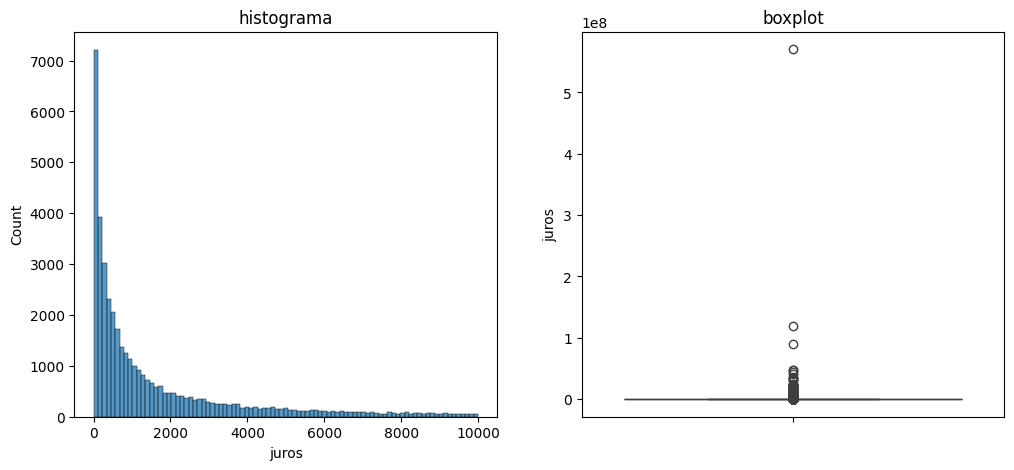

In [31]:
print(df4['juros'].describe())
fig, axes = plt.subplots(1,2 ,figsize=(12,5))

sns.histplot(df4[df4['juros']<10000]['juros'], ax=axes[0])
axes[0].set_title('histograma')

sns.boxplot(df4['juros'], ax=axes[1])
axes[1].set_title('boxplot')

### 4.1.5 VALOR DO EMPRESTIMO ATUALIZADO

count    5.039000e+04
mean     1.770694e+05
std      7.058364e+06
min      1.397040e+03
25%      2.842910e+03
50%      5.652695e+03
75%      1.903061e+04
max      1.430927e+09
Name: valor_emprestimo_atualizado, dtype: float64


Text(0.5, 1.0, 'boxplot')

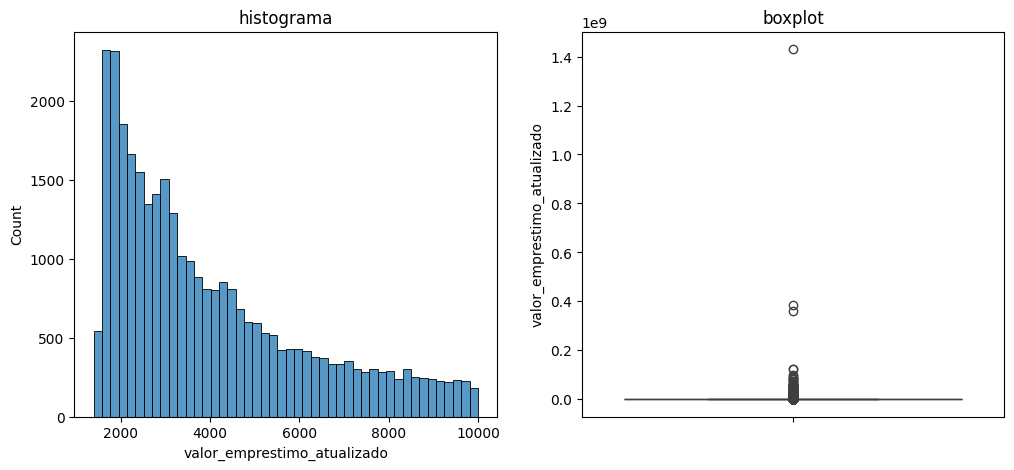

In [32]:
print(df4['valor_emprestimo_atualizado'].describe())
fig, axes = plt.subplots(1,2 ,figsize=(12,5))

sns.histplot(df4[df4['valor_emprestimo_atualizado']<10000]['valor_emprestimo_atualizado'], ax=axes[0])
axes[0].set_title('histograma')

sns.boxplot(df4['valor_emprestimo_atualizado'], ax=axes[1])
axes[1].set_title('boxplot')

### 4.1.6 JUROS PORCENTAGEM

count    50390.000000
mean         3.029730
std        105.423189
min          0.000000
25%          0.112590
50%          0.349677
75%          0.848668
max      16248.020882
Name: juros_porcentagem, dtype: float64


Text(0.5, 1.0, 'boxplot')

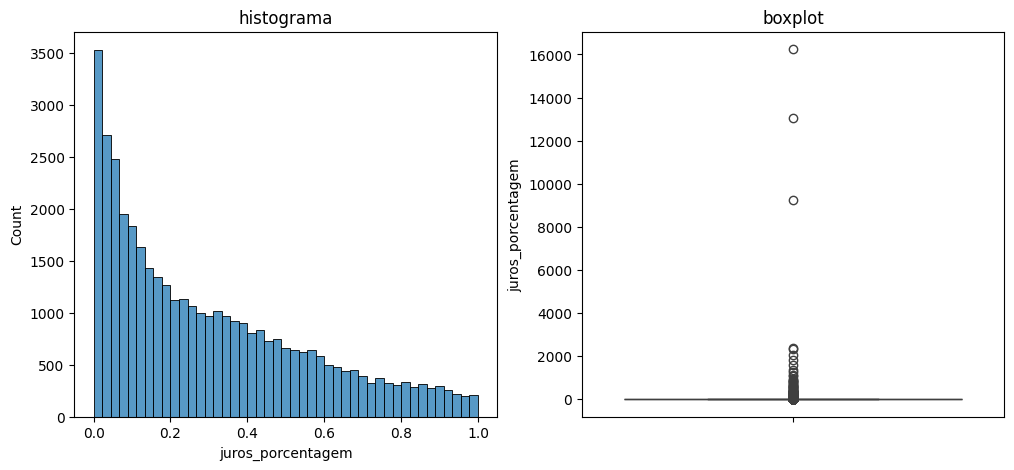

In [33]:
print(df4['juros_porcentagem'].describe())
fig, axes = plt.subplots(1,2 ,figsize=(12,5))

sns.histplot(df4[df4['juros_porcentagem']<1]['juros_porcentagem'], ax=axes[0])
axes[0].set_title('histograma')

sns.boxplot(df4['juros_porcentagem'], ax=axes[1])
axes[1].set_title('boxplot')

## 4.2 CATEGORICAS

### 4.2.1 DENPENDETES

dependentes
N    0.639968
S    0.360032
Name: proportion, dtype: float64


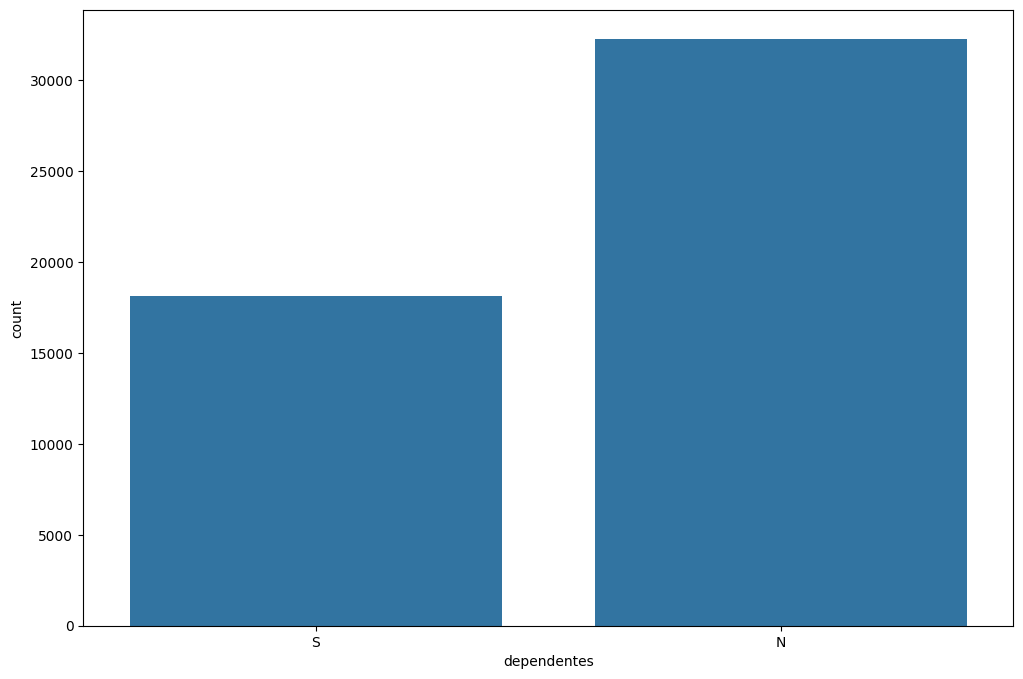

In [34]:
print(df4['dependentes'].value_counts(normalize=True))
sns.countplot(x='dependentes', data=df4);

### 4.2.2 ESTADO CIVIL

estado_civil
solteiro                                  0.547053
casado(a) com comunhao parcial de bens    0.263604
casado(a) com comunhao de bens            0.154098
casado(a) com separacao de bens           0.030959
separado judicialmente                    0.001469
divorciado                                0.001330
viuvo(a)                                  0.000814
outros                                    0.000675
Name: proportion, dtype: float64


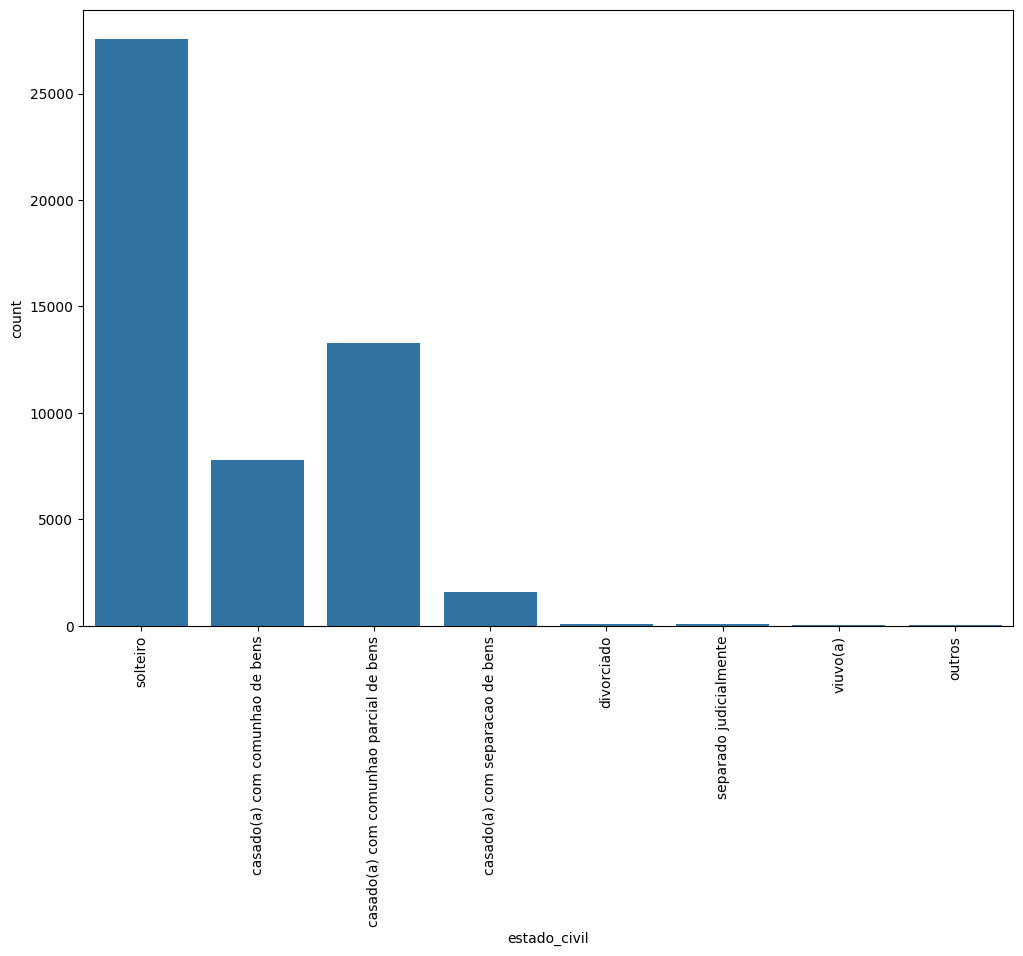

In [35]:
print(df4['estado_civil'].value_counts(normalize=True))
sns.countplot(x='estado_civil', data=df4);
plt.xticks(rotation=90);

### 4.2.3 CONTA POUPANCA

conta_poupanca
S    0.847986
N    0.152014
Name: proportion, dtype: float64


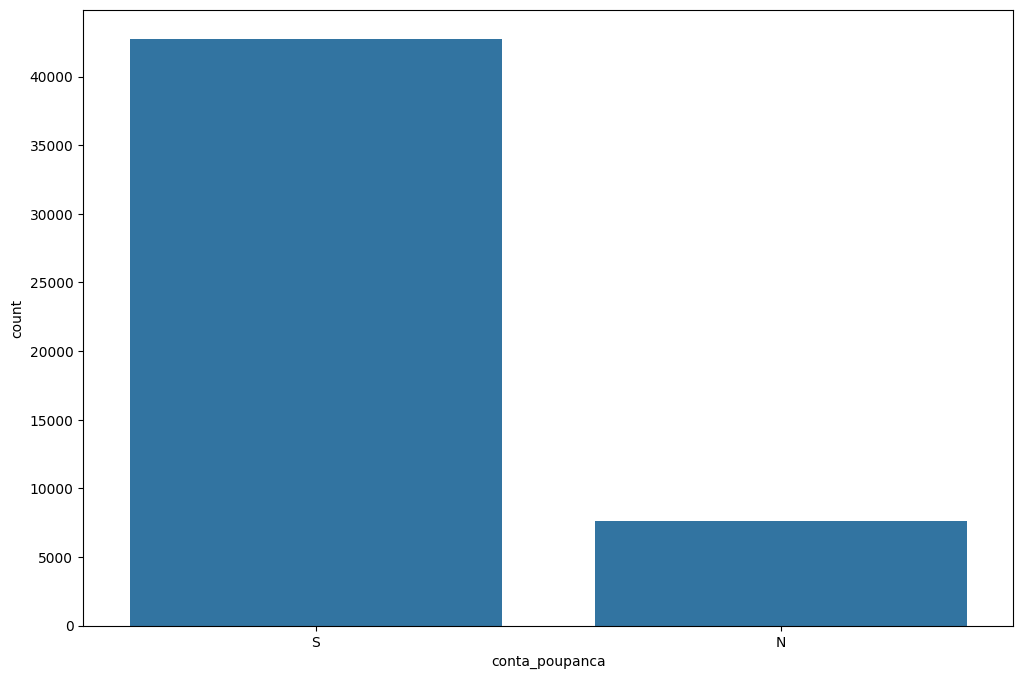

In [36]:
print(df4['conta_poupanca'].value_counts(normalize=True))
sns.countplot(x='conta_poupanca', data=df4);

### 4.2.4 CONTA SALARIO

conta_salario
N    0.976603
S    0.023397
Name: proportion, dtype: float64


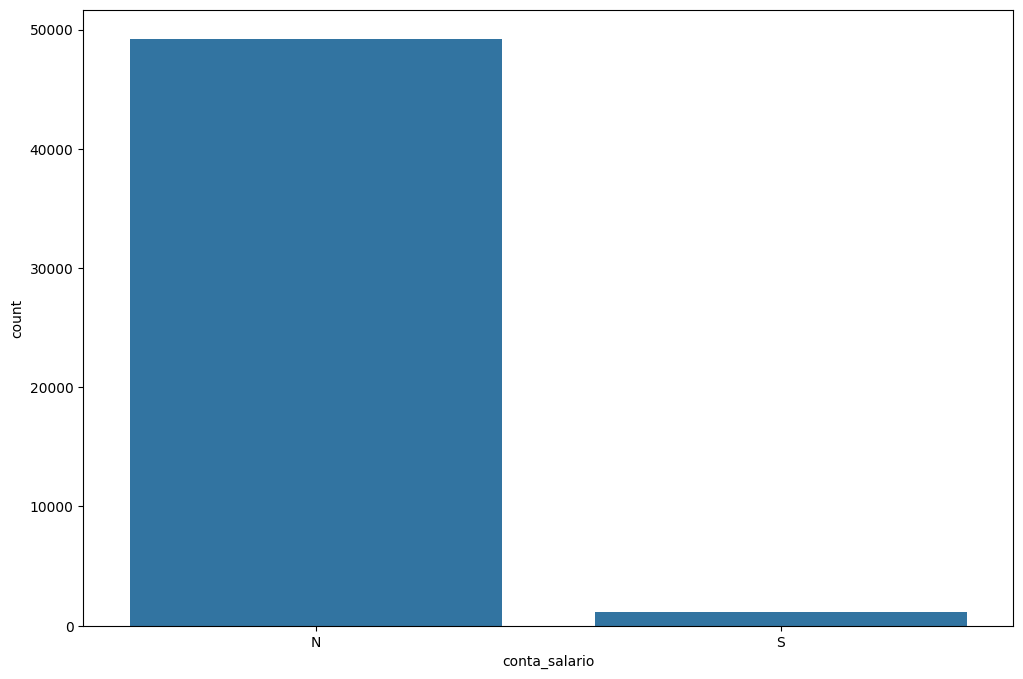

In [37]:
print(df4['conta_salario'].value_counts(normalize=True))
sns.countplot(x='conta_salario', data=df4);

### 4.2.5 CHEQUE SEM FUNDO

cheque_sem_fundo
S    0.769974
N    0.230026
Name: proportion, dtype: float64


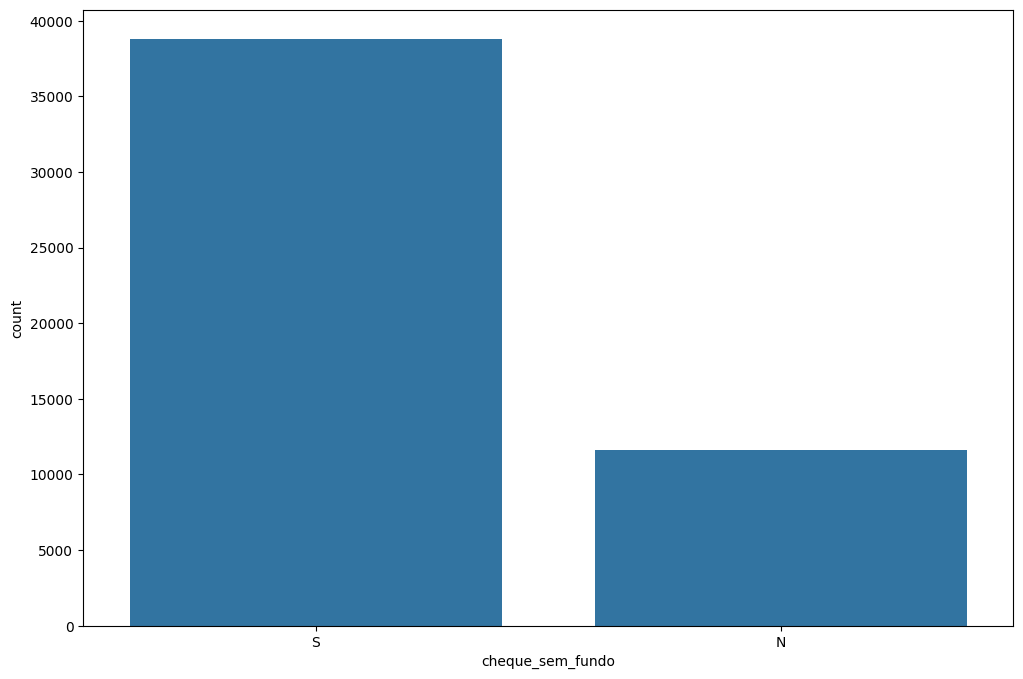

In [38]:
print(df4['cheque_sem_fundo'].value_counts(normalize=True))
sns.countplot(x='cheque_sem_fundo', data=df4);

### 4.2.6 CONTA CONJUNTA

conta_conjunta
N    0.958285
S    0.041715
Name: proportion, dtype: float64


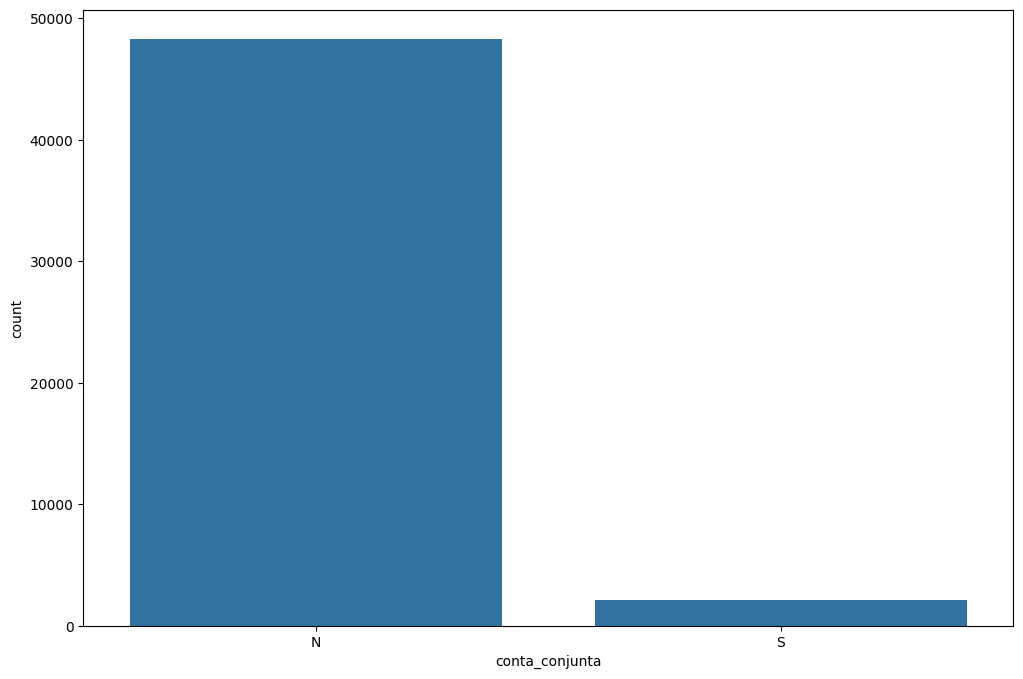

In [39]:
print(df4['conta_conjunta'].value_counts(normalize=True))
sns.countplot(x='conta_conjunta', data=df4);

### 4.2.7 PAGO

pago
sim    0.790891
nao    0.209109
Name: proportion, dtype: float64


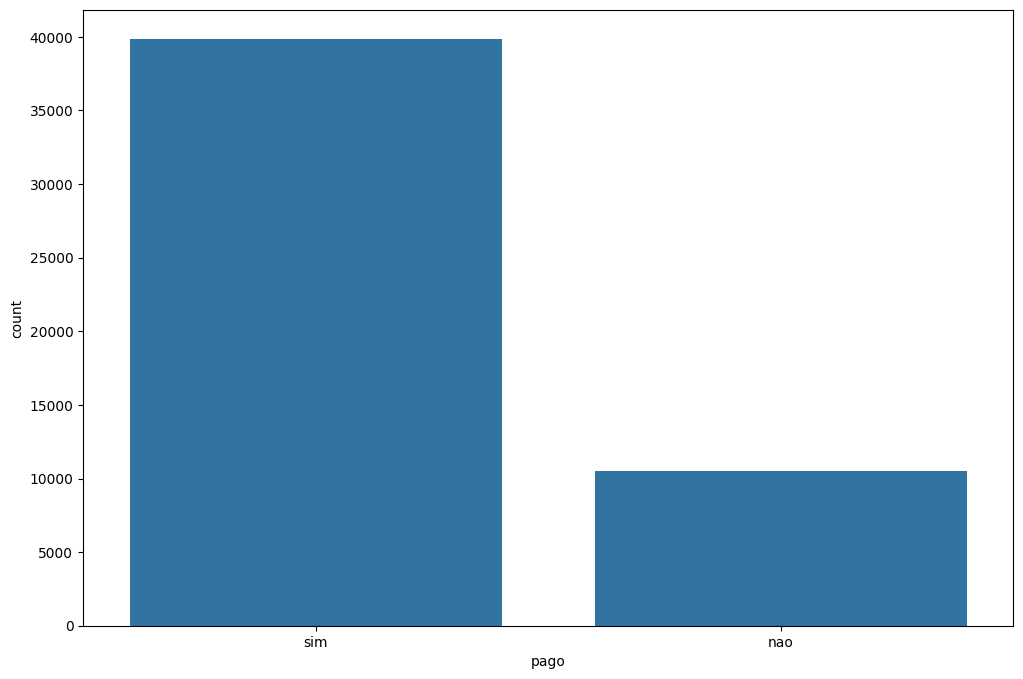

In [40]:
print(df4['pago'].value_counts(normalize=True))
sns.countplot(x='pago', data=df4);

### 4.2.8 GENERO

genero
masculino    0.501667
feminino     0.498333
Name: proportion, dtype: float64


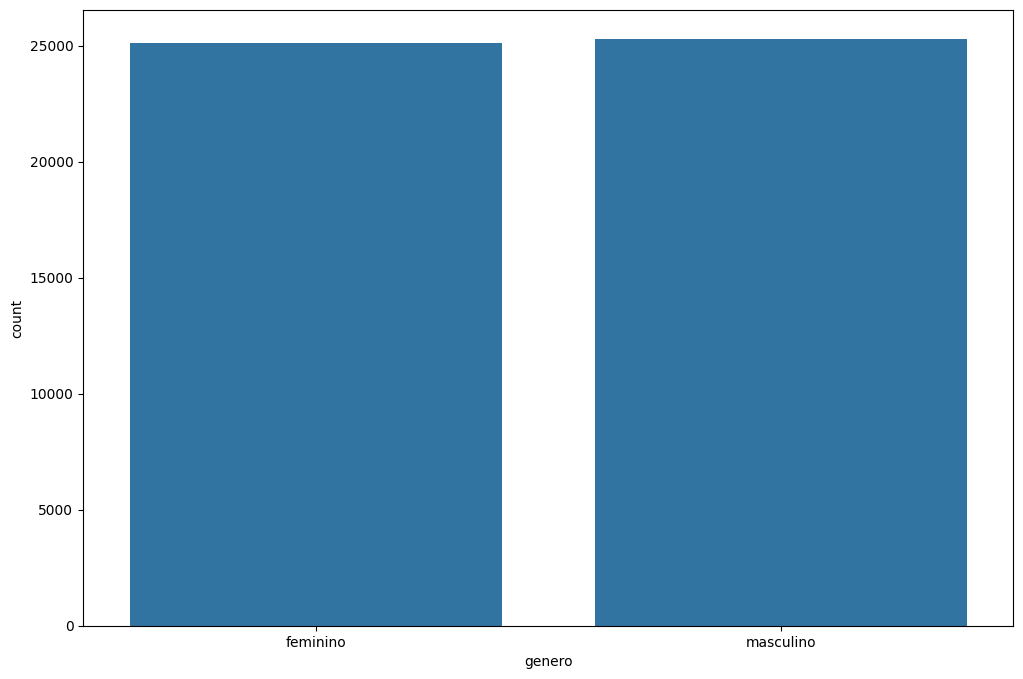

In [41]:
print(df4['genero'].value_counts(normalize=True))
sns.countplot(x='genero', data=df4);

### 4.2.9 ESTADO

estado
minas gerais      0.251340
sao paulo         0.250189
espirito santo    0.249772
rio de janeiro    0.248700
Name: proportion, dtype: float64


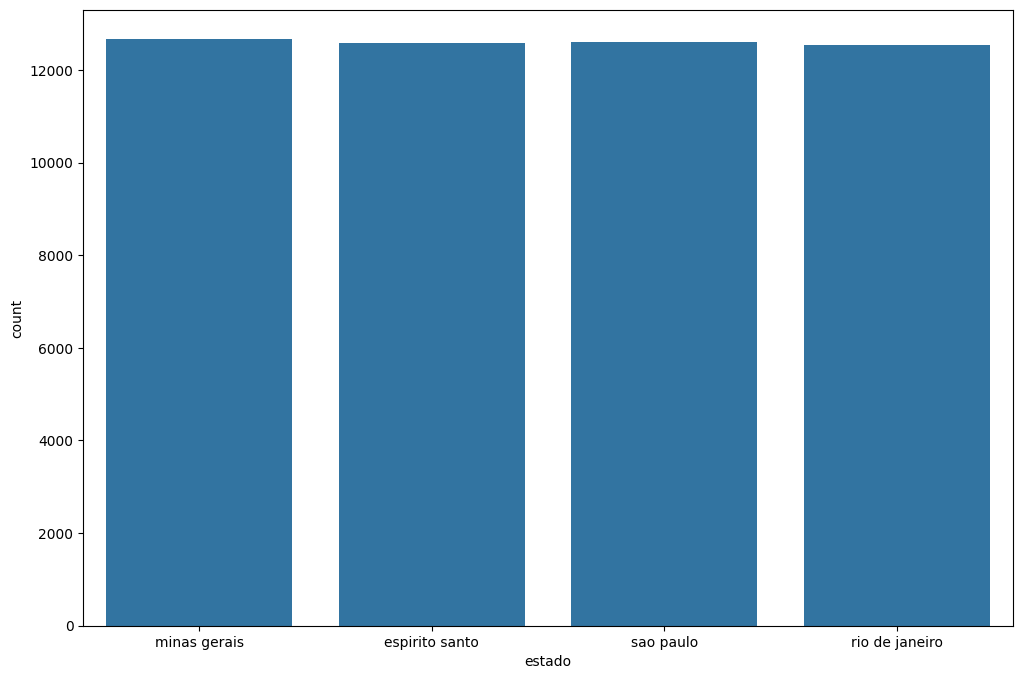

In [42]:
print(df4['estado'].value_counts(normalize=True))
sns.countplot(x='estado', data=df4);

# 5.0 CLEAN OUTLIERS

In [43]:
df5 = df4.copy()

In [44]:
df5['pago'].value_counts(normalize=True)

pago
sim    0.790891
nao    0.209109
Name: proportion, dtype: float64

In [45]:
len(df5[df5['valor_emprestimo']>5000000]) / len(df5)

0.0015479261758285373

In [46]:
len(df5[df5['juros_porcentagem']<0.01]) / len(df5)

0.03464973208970034

In [47]:
df5 = df5[df5['valor_emprestimo']<5000000].copy()
df5 = df5[df5['juros_porcentagem']>0.01].copy()

In [48]:
df5['pago'].value_counts(normalize=True)

pago
sim    0.787073
nao    0.212927
Name: proportion, dtype: float64

In [49]:
config

{'split': {'seed': 42, 'test_size': 0.2},
 'data': {'raw_path': '../data/raw_data/raw_data.csv',
  'trusted_path': '../data/trusted_data/trusted_data.csv',
  'train_path': '../data/train_data/train_data.csv',
  'test_path': '../data/test_data/test_data.csv'},
 'imagem': {'path': '../imagens/mind map.png'}}

In [50]:
df5.to_csv(config['data']['trusted_path'], index=False)

# 6.0 EDA BIVARIADA

In [51]:
df6 = pd.read_csv(config['data']['trusted_path'])

## 6.1 GENERO (Mulheres são em média 10% mais ADIMPLENTES.) (FALSO)

pago        nao    sim
genero                
feminino   5220  18992
masculino  5121  19233

pago            nao       sim
genero                       
feminino   0.215596  0.784404
masculino  0.210273  0.789727

<Axes: xlabel='genero'>

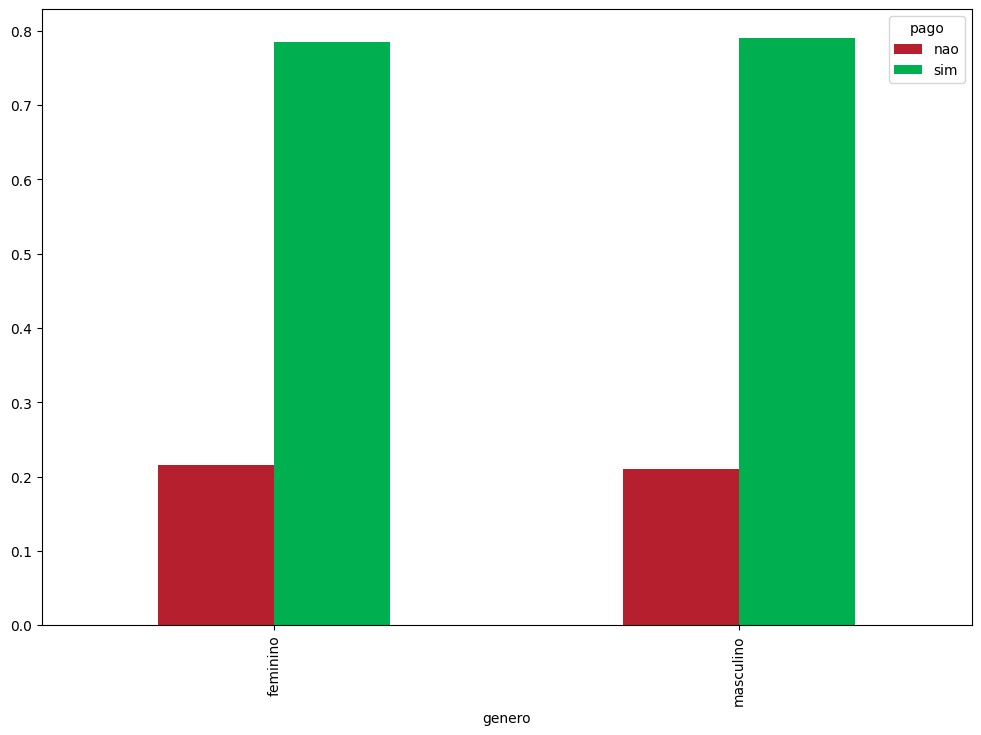

In [52]:
display(pd.crosstab(df6['genero'],df6['pago']))

display(pd.crosstab(df6['genero'],df6['pago'], normalize='index'))

display(pd.crosstab(df6['genero'],df6['pago'], normalize='index').plot(kind='bar', color={'nao': '#b61f2e', 'sim': '#00b050'}))

## 6.2 IDADE (Clientes com Menos de 60 anos são em média 20% mais ADIMPLENTES.) (FALSO)

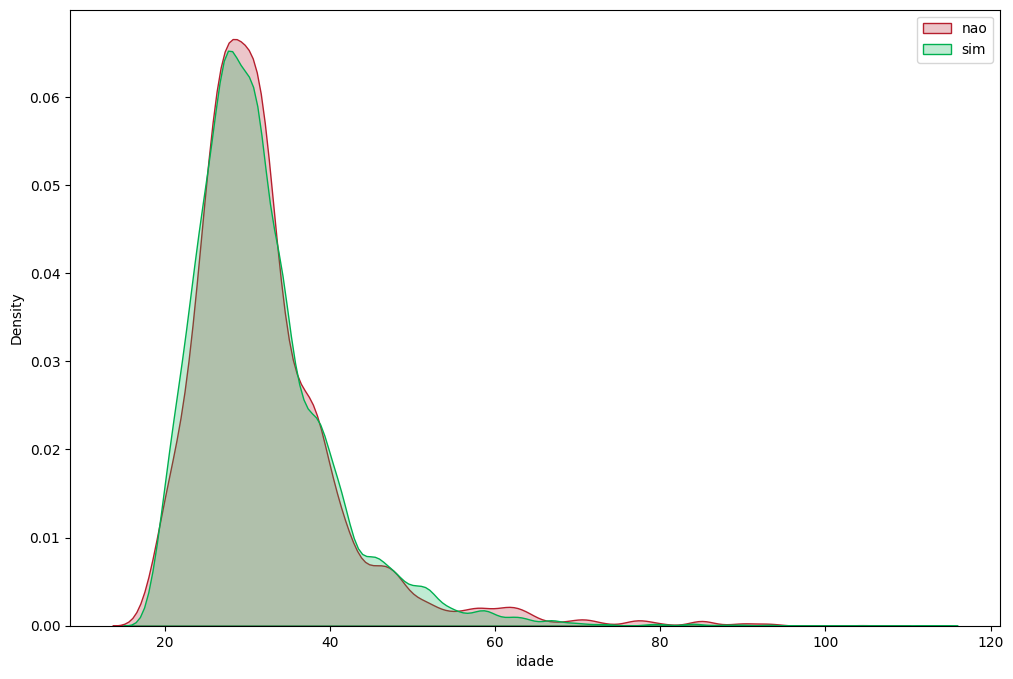

In [53]:
sns.kdeplot(df6[df6['pago']=='nao']['idade'], label='nao', fill=True, color='#b61f2e')
sns.kdeplot(df6[df6['pago']=='sim']['idade'], label='sim', fill=True, color='#00b050')
plt.legend();

## 6.3 DEPENDENTES (Clientes com Dependentes são em média 15% mais ADIMPLENTES.) (VERDADEIRA)

pago           nao    sim
idade_binned             
(18, 38]      8715  32015
(38, 58]      1345   5649
(58, 78]       193    408
(78, 98]        46     80

pago               nao       sim
idade_binned                    
(18, 38]      0.213970  0.786030
(38, 58]      0.192308  0.807692
(58, 78]      0.321131  0.678869
(78, 98]      0.365079  0.634921

<Axes: xlabel='idade_binned'>

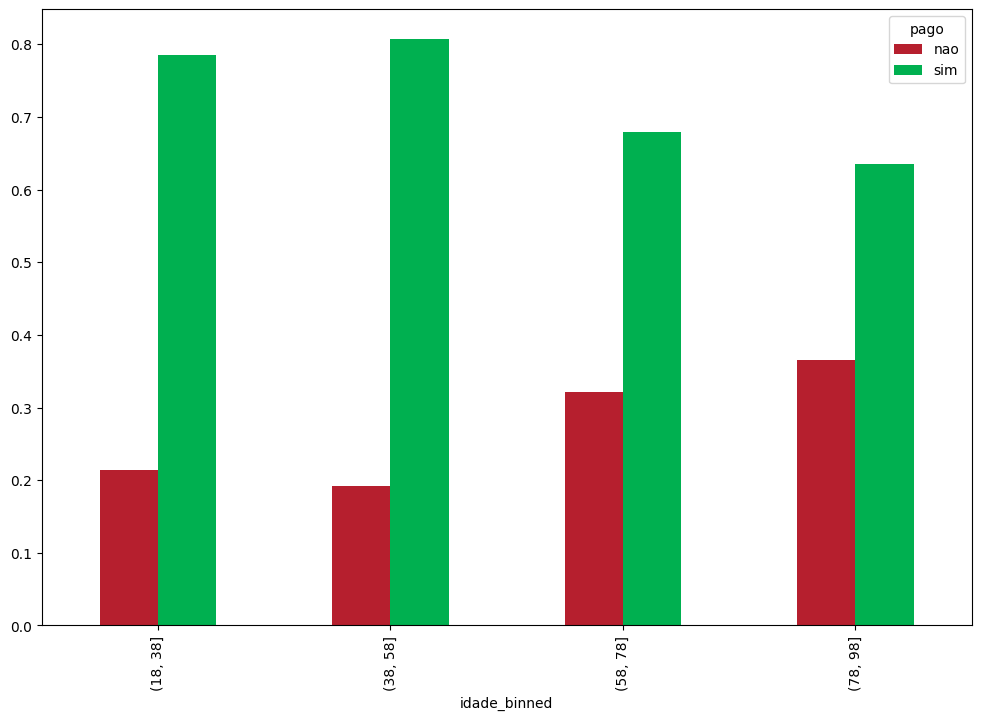

In [54]:
bins = list(np.arange(18,113,20))
aux = df6.copy()

aux['idade_binned']= pd.cut(aux['idade'],bins=bins)


display(pd.crosstab(aux['idade_binned'],aux['pago']))
display(pd.crosstab(aux['idade_binned'],aux['pago'], normalize='index'))
display(pd.crosstab(aux['idade_binned'],aux['pago'], normalize='index').plot(kind='bar', color={'nao': '#b61f2e', 'sim': '#00b050'}))

pago          nao    sim
dependentes             
N            8661  22568
S            1680  15657

pago              nao       sim
dependentes                    
N            0.277338  0.722662
S            0.096903  0.903097

<Axes: xlabel='dependentes'>

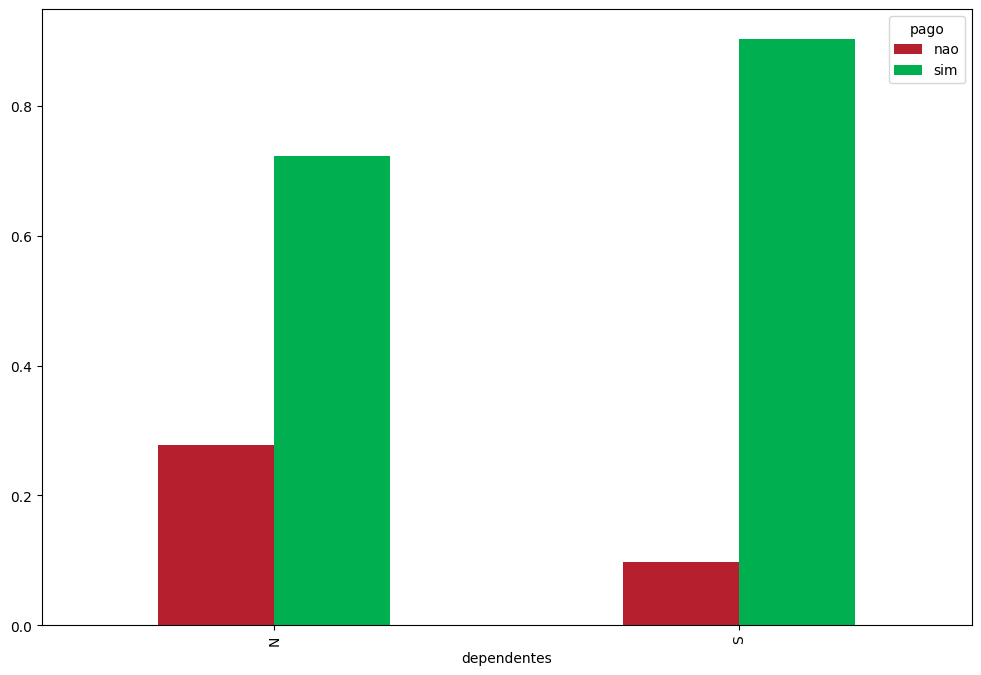

In [55]:
display(pd.crosstab(df6['dependentes'],df6['pago']))
display(pd.crosstab(df6['dependentes'],df6['pago'], normalize='index'))
display(pd.crosstab(df6['dependentes'],df6['pago'], normalize='index').plot(kind='bar', color={'nao': '#b61f2e', 'sim': '#00b050'}))

## 6.4 ESTADO CIVIL (Clientes que são solteiros tem uma taxa percentual maior de INADIMPLÊNCIA que os demais.) (FALSO) 

pago                                     nao    sim
estado_civil                                       
casado(a) com comunhao de bens          1790   5825
casado(a) com comunhao parcial de bens  5112   8003
casado(a) com separacao de bens          401   1105
divorciado                                 6     56
outros                                    27      7
separado judicialmente                    33     41
solteiro                                2949  23170
viuvo(a)                                  23     18

pago                                         nao       sim
estado_civil                                              
casado(a) com comunhao de bens          0.235062  0.764938
casado(a) com comunhao parcial de bens  0.389783  0.610217
casado(a) com separacao de bens         0.266268  0.733732
divorciado                              0.096774  0.903226
outros                                  0.794118  0.205882
separado judicialmente                  0.445946  0.554054
solteiro                                0.112906  0.887094
viuvo(a)                                0.560976  0.439024

<Axes: xlabel='estado_civil'>

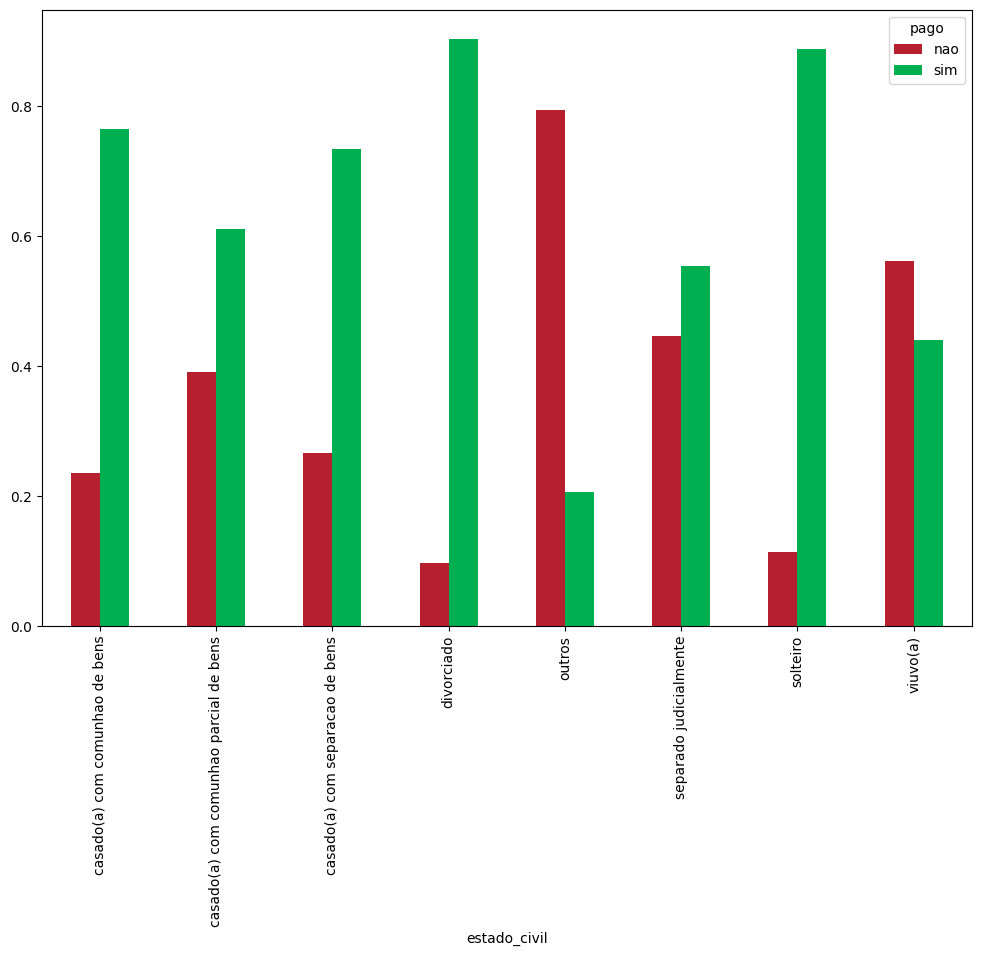

In [56]:
display(pd.crosstab(df6['estado_civil'],df6['pago']))
display(pd.crosstab(df6['estado_civil'],df6['pago'], normalize='index'))
display(pd.crosstab(df6['estado_civil'],df6['pago'], normalize='index').plot(kind='bar', color={'nao': '#b61f2e', 'sim': '#00b050'}))

## 6.5 CONTA SALARIO (Clientes com conta salário são em média 30% mais ADIMPLENTES.) (FALSO)

pago             nao    sim
conta_salario              
N              10030  37403
S                311    822

pago                nao       sim
conta_salario                    
N              0.211456  0.788544
S              0.274492  0.725508

<Axes: xlabel='conta_salario'>

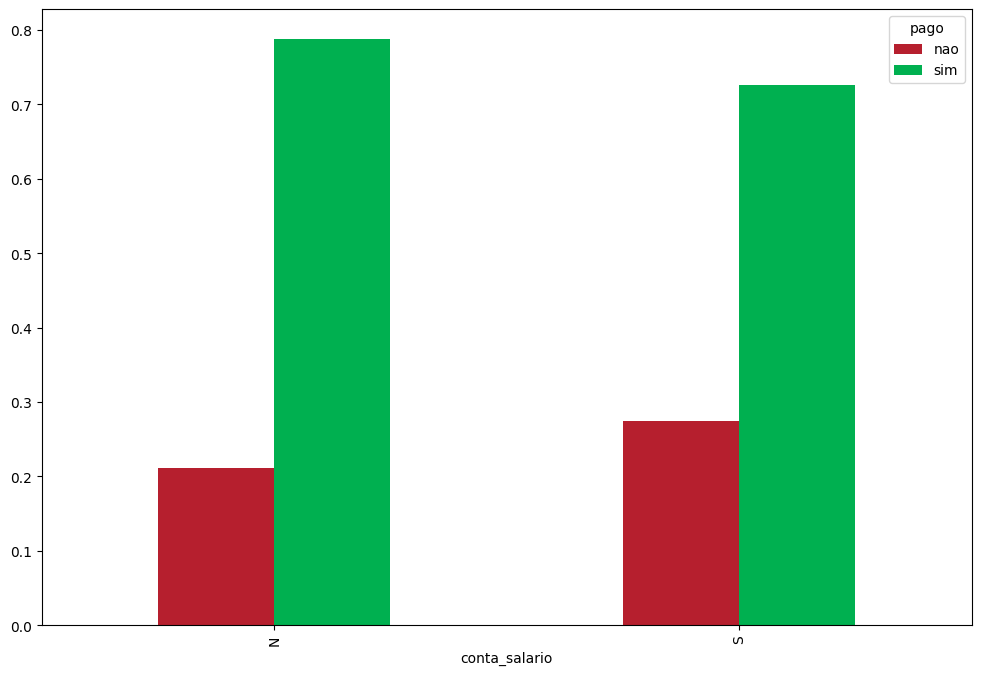

In [57]:
display(pd.crosstab(df6['conta_salario'],df6['pago']))
display(pd.crosstab(df6['conta_salario'],df6['pago'], normalize='index'))
display(pd.crosstab(df6['conta_salario'],df6['pago'], normalize='index').plot(kind='bar', color={'nao': '#b61f2e', 'sim': '#00b050'}))

## 6.6 CONTA POUPANCA (Clientes com conta poupança são em média 10% mais ADIMPLENTES.) (FALSO)

pago             nao    sim
conta_poupanca             
N               1847   5648
S               8494  32577

pago                 nao       sim
conta_poupanca                    
N               0.246431  0.753569
S               0.206813  0.793187

<Axes: xlabel='conta_poupanca'>

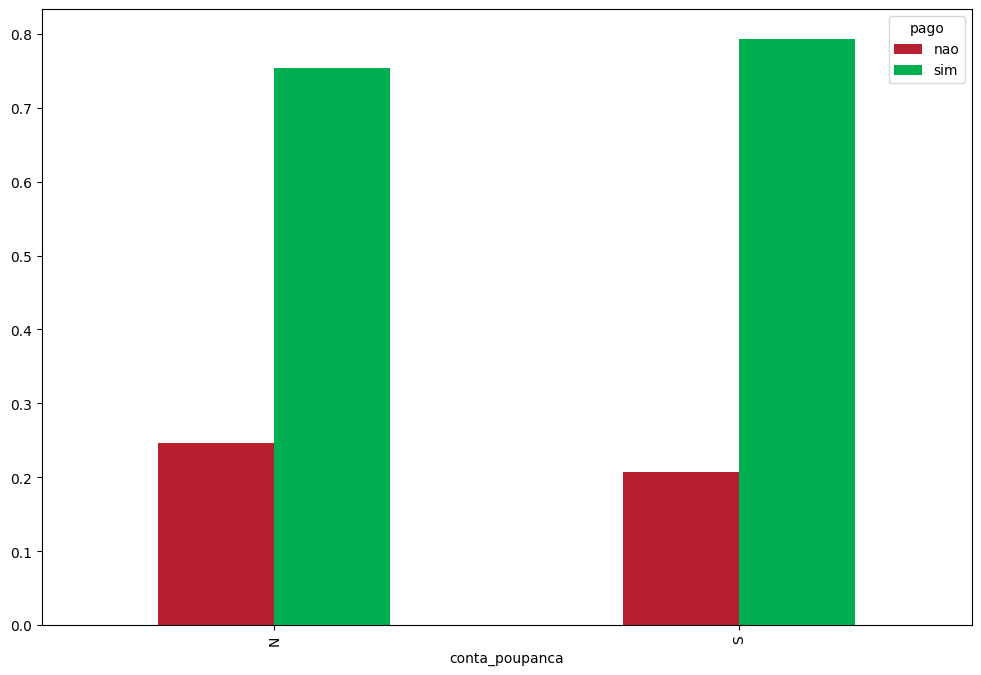

In [58]:
display(pd.crosstab(df6['conta_poupanca'],df6['pago']))
display(pd.crosstab(df6['conta_poupanca'],df6['pago'], normalize='index'))
display(pd.crosstab(df6['conta_poupanca'],df6['pago'], normalize='index').plot(kind='bar', color={'nao': '#b61f2e', 'sim': '#00b050'}))

## 6.7 CHEQUE SEM FUNDO (Clientes que já passaram cheque sem fundo são em média 15% mais INADIMPLENTES.) (VERDADEIRA)

pago               nao    sim
cheque_sem_fundo             
N                 1051   9958
S                 9290  28267

pago                   nao       sim
cheque_sem_fundo                    
N                 0.095467  0.904533
S                 0.247357  0.752643

<Axes: xlabel='cheque_sem_fundo'>

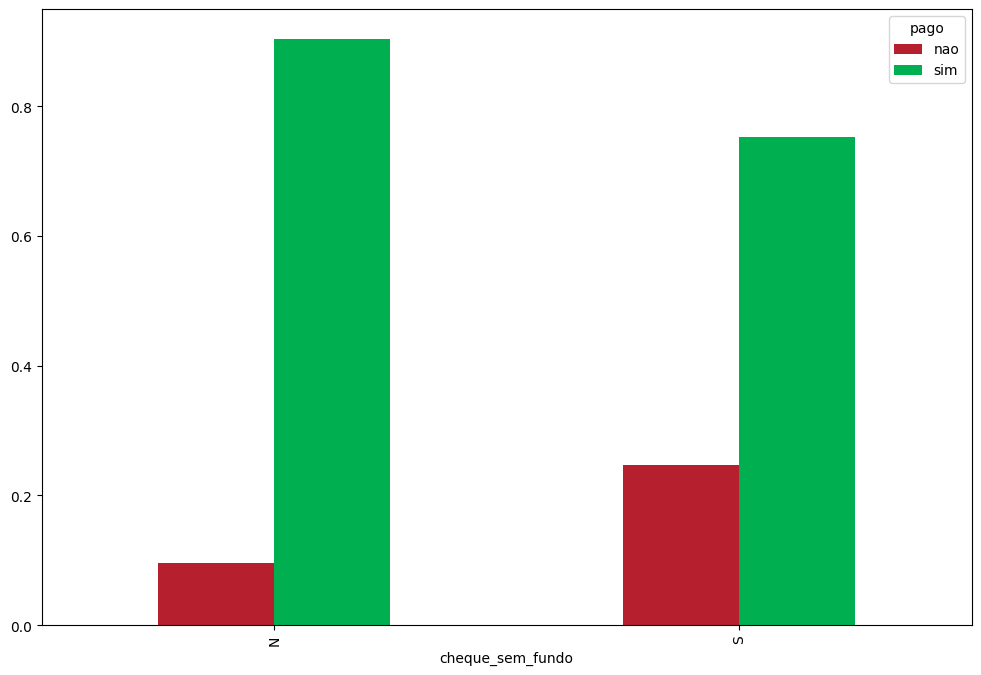

In [59]:
display(pd.crosstab(df6['cheque_sem_fundo'],df6['pago']))
display(pd.crosstab(df6['cheque_sem_fundo'],df6['pago'], normalize='index'))
display(pd.crosstab(df6['cheque_sem_fundo'],df6['pago'], normalize='index').plot(kind='bar', color={'nao': '#b61f2e', 'sim': '#00b050'}))

## 6.8 CONTA CONJUNTA (clientes que tem conta conjunta são em média 10% mais INADIMPLENTES.) (FALSO)

pago              nao    sim
conta_conjunta              
N               10085  36489
S                 256   1736

pago                 nao       sim
conta_conjunta                    
N               0.216537  0.783463
S               0.128514  0.871486

<Axes: xlabel='conta_conjunta'>

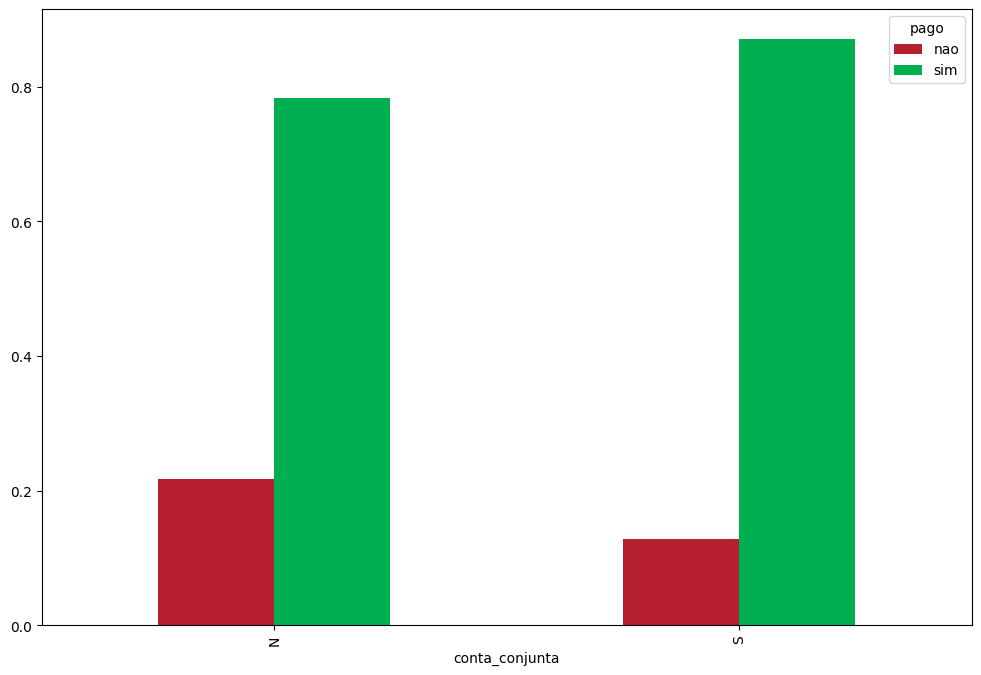

In [60]:
display(pd.crosstab(df6['conta_conjunta'],df6['pago']))
display(pd.crosstab(df6['conta_conjunta'],df6['pago'], normalize='index'))
display(pd.crosstab(df6['conta_conjunta'],df6['pago'], normalize='index').plot(kind='bar', color={'nao': '#b61f2e', 'sim': '#00b050'}))

## 6.9 EMPRESTIMO (Clientes que pegaram empréstimos de mais de RS$20000 tem tendência a ser INADIMPLENTES.) (VERDADEIRA)

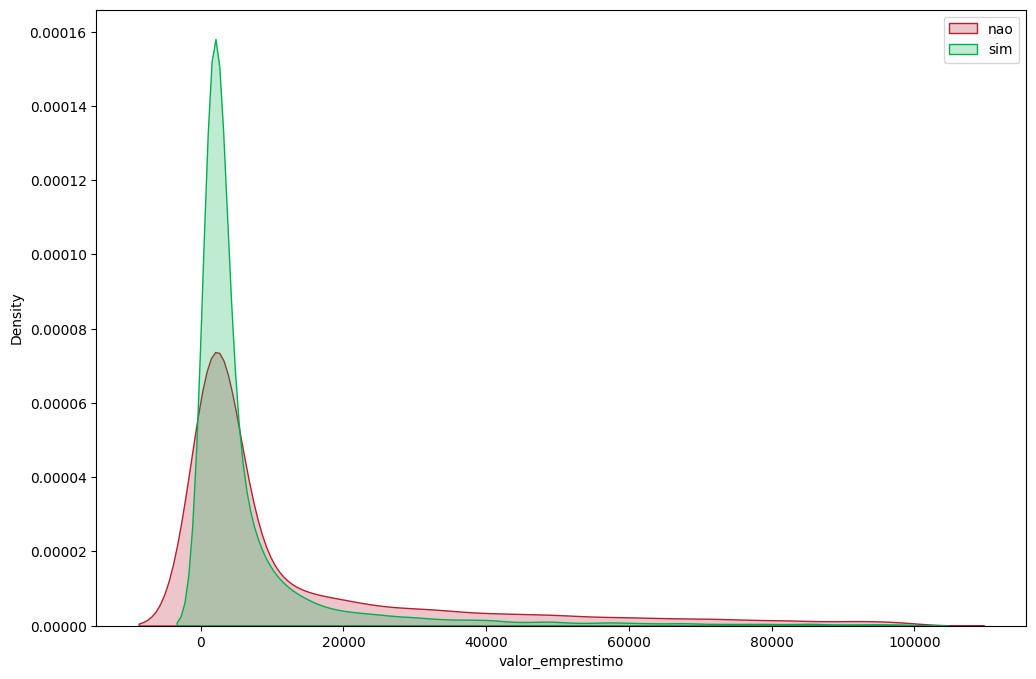

In [61]:
aux = df6[df6['valor_emprestimo']<100000].copy()


sns.kdeplot(aux[aux['pago']=='nao']['valor_emprestimo'], label='nao', fill=True, color='#b61f2e')
sns.kdeplot(aux[aux['pago']=='sim']['valor_emprestimo'], label='sim', fill=True, color='#00b050')
plt.legend();

## 6.10 ESTADO (Clientes que moram no Estado RJ E SP tem maior percentual de ADIMPLENTE do que ES e MG.) (FALSO)

pago             nao   sim
estado                    
espirito santo  2597  9550
minas gerais    2590  9612
rio de janeiro  2592  9483
sao paulo       2562  9580

pago                 nao       sim
estado                            
espirito santo  0.213798  0.786202
minas gerais    0.212260  0.787740
rio de janeiro  0.214658  0.785342
sao paulo       0.211003  0.788997

<Axes: xlabel='estado'>

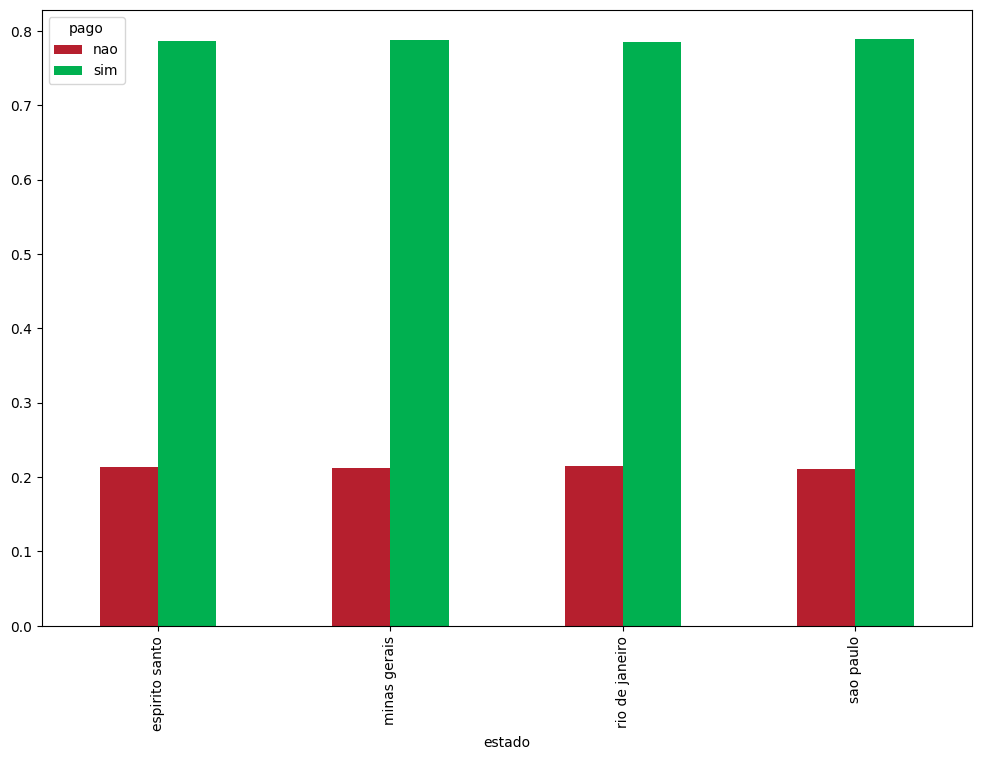

In [62]:
display(pd.crosstab(df6['estado'],df6['pago']))
display(pd.crosstab(df6['estado'],df6['pago'], normalize='index'))
display(pd.crosstab(df6['estado'],df6['pago'], normalize='index').plot(kind='bar', color={'nao': '#b61f2e', 'sim': '#00b050'}))

# 7.0 ANALISE DE CORRELAÇÃO

In [63]:
df7 = df6.copy()

## 7.1 NUMERICAS X NUMERICAS

In [64]:
num_attributes  = df7.select_dtypes(include=['int32', 'int64', 'float32', 'float64'])
num_attributes  = num_attributes.drop('id', axis=1)

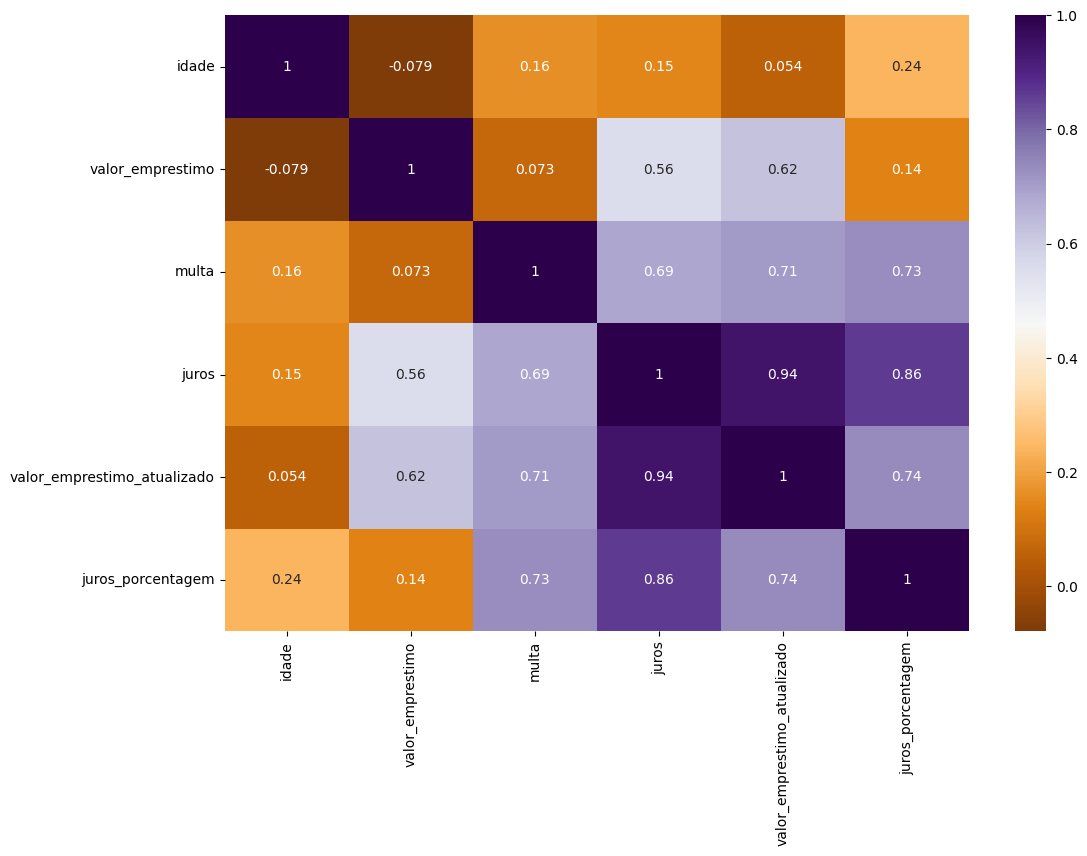

In [65]:
sns.heatmap(num_attributes.corr('spearman'), cmap='PuOr', annot=True);

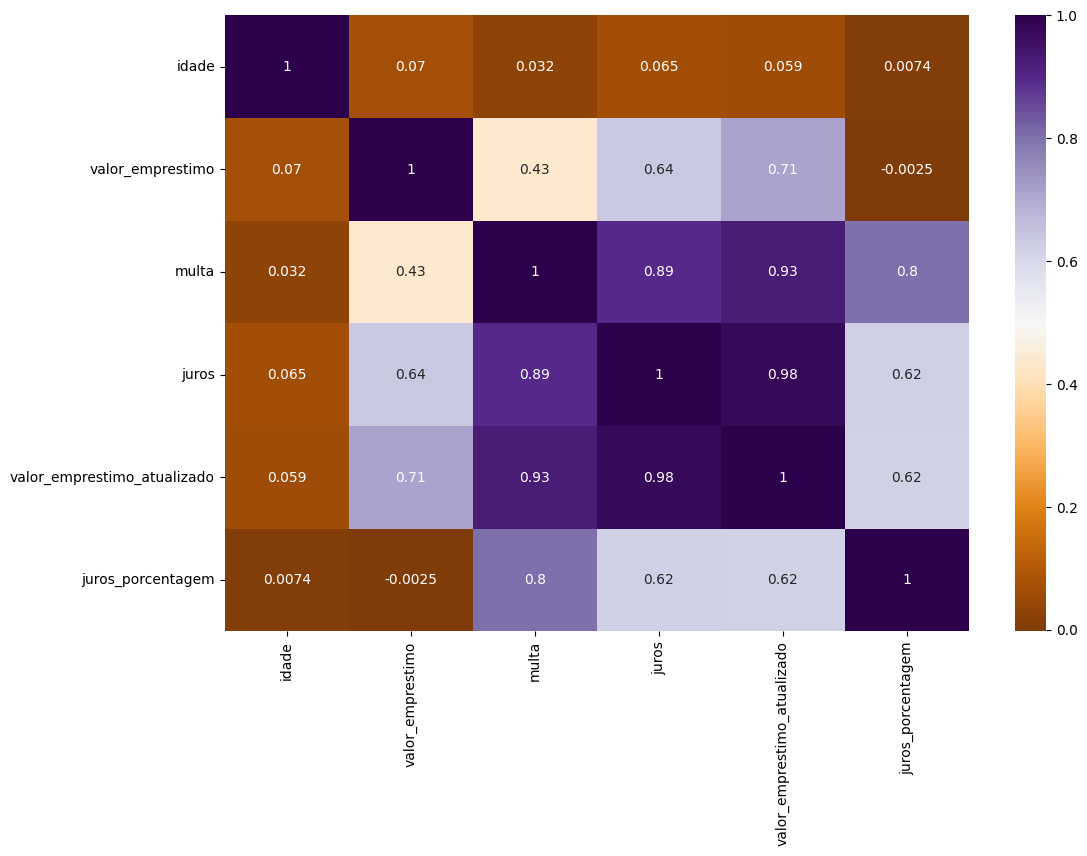

In [66]:
sns.heatmap(num_attributes.corr('pearson'), cmap='PuOr', annot=True);

## 7.2 CATEGORICAS X CATEGORICAS

In [67]:
from scipy import  stats as ss

def cramers_v(confusion_matrix):
   
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

In [68]:
cat_attributes = df7.select_dtypes( exclude=['int32','int64', 'float32', 'float64', 'datetime64[ns]'] )

cat_attributes_list = cat_attributes.columns.tolist()

 
corr_dict = {}

for i in range( len( cat_attributes_list ) ):

    corr_list = []

    for j in range( len( cat_attributes_list ) ):

        ref =cat_attributes_list[i]

        feat =cat_attributes_list[j]

       

        #correlation
        confusion_matrix = pd.crosstab(cat_attributes[ ref ], cat_attributes[ feat ])
        corr = cramers_v( confusion_matrix.values )

       

        #append a list

        corr_list.append( corr )

   

    corr_dict[ ref ] = corr_list

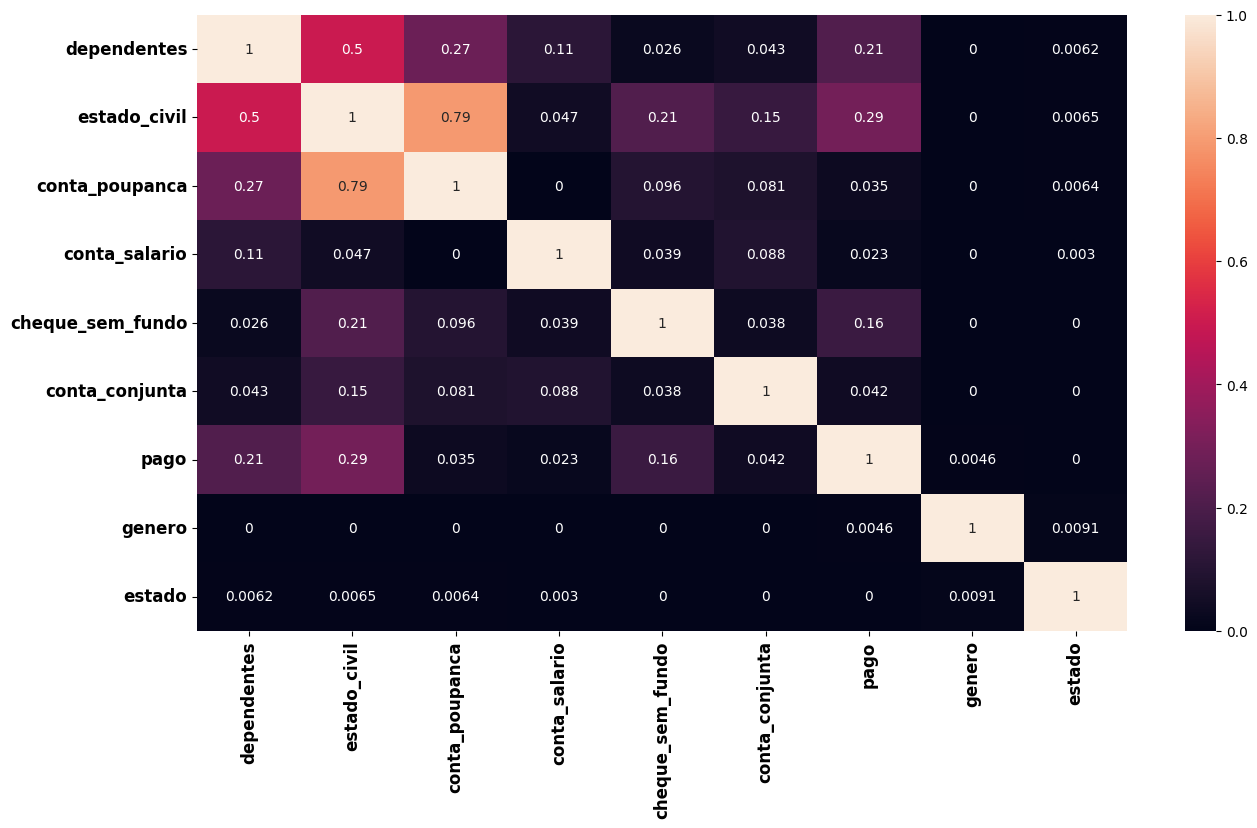

In [69]:
d = pd.DataFrame( corr_dict )

d = d.set_index( d.columns )

plt.figure(figsize=(15,8))
sns.heatmap( d, annot=True )

plt.xticks(rotation=90, fontsize=12, weight='bold')
plt.yticks(rotation=360, fontsize=12, weight='bold');

# 8.0 SPLIT TREINO TESTE E VALIDACAO

In [70]:
df8 = pd.read_csv(config['data']['trusted_path'])

In [71]:
df8.head()

dependentes                    estado_civil  idade conta_poupanca  \
0           S                        solteiro     36              S   
1           N                        solteiro     39              S   
2           S                        solteiro     26              S   
3           N  casado(a) com comunhao de bens     23              N   
4           S                        solteiro     33              S   

  conta_salario cheque_sem_fundo conta_conjunta  valor_emprestimo     multa  \
0             N                S              N           8174.32    263.25   
1             N                N              N          41775.63   1607.29   
2             N                N              N         522940.27  24860.40   
3             N                S              N           1418.00  21472.36   
4             N                S              N           2078.97     19.44   

       juros  valor_emprestimo_atualizado pago         id     genero  \
0    5844.98                     14282.55  sim  309652396   feminino   
1    7652.26                     51035.18  sim  498764591   feminino   
2  319315.62                    867116.29  sim  504868288  masculino   
3    2967.48                     25857.84  sim  541365315   feminino   
4      46.35                      2144.76  sim  563622907  masculino   

           estado  juros_porcentagem  
0    minas gerais           0.715042  
1  espirito santo           0.183175  
2       sao paulo           0.610616  
3       sao paulo           2.092722  
4  espirito santo           0.022295

In [72]:
df8['pago'] = df8['pago'].apply(label_pago)

In [73]:
train_set, test_set = train_test_split(df8, test_size = config['split']['test_size'], random_state=config['split']['seed'], stratify=df8['pago'])

In [74]:
print(len(train_set))
print(len(test_set))

38852
9714


In [75]:
config

{'split': {'seed': 42, 'test_size': 0.2},
 'data': {'raw_path': '../data/raw_data/raw_data.csv',
  'trusted_path': '../data/trusted_data/trusted_data.csv',
  'train_path': '../data/train_data/train_data.csv',
  'test_path': '../data/test_data/test_data.csv'},
 'imagem': {'path': '../imagens/mind map.png'}}

In [76]:
train_set.to_csv(config['data']['train_path'], index=False)
test_set.to_csv(config['data']['test_path'], index=False)

# 9.0 FEATURE SELECTION

In [77]:
df9 = pd.read_csv(config['data']['train_path']).drop(['id', 'multa', 'juros', 'valor_emprestimo_atualizado', 'juros_porcentagem'], axis=1).copy()

In [78]:
df9.columns

Index(['dependentes', 'estado_civil', 'idade', 'conta_poupanca',
       'conta_salario', 'cheque_sem_fundo', 'conta_conjunta',
       'valor_emprestimo', 'pago', 'genero', 'estado'],
      dtype='object')

In [79]:
print(df9['pago'].value_counts(normalize=True))

pago
0    0.787064
1    0.212936
Name: proportion, dtype: float64


## 9.1 LOGISTIC REGRESSION

In [80]:
columns_select = ['dependentes', 'estado_civil', 'idade', 'conta_conjunta', 'cheque_sem_fundo', 'valor_emprestimo', 'pago']

df9_lr = df9[columns_select].copy()


### 9.1.1 SELECT VARIABLES P VALUE

In [81]:
ce_rare = RareLabelEncoder(n_categories=5, tol=0.05, variables=['estado_civil'], replace_with='outros')
ce_rare.fit(df9_lr)

df9_lr = ce_rare.transform(df9_lr)

ce_rare.encoder_dict_

{'estado_civil': ['solteiro',
  'casado(a) com comunhao parcial de bens',
  'casado(a) com comunhao de bens']}

In [82]:
x_train, x_train_2, x_test, y_test = reamostrar_lr(df9_lr, frac=0.7)

pago
0    0.525829
1    0.474171
Name: proportion, dtype: float64


In [83]:
ss = StandardScaler()
ss.fit(x_train_2[['idade']].values)
x_train_2['idade'] = ss.transform(x_train_2[['idade']])

x_test['idade'] = ss.transform(x_test[['idade']])


yj = PowerTransformer(method='yeo-johnson', standardize=True)

yj.fit(x_train_2[['valor_emprestimo']].values)
x_train_2['valor_emprestimo'] = yj.transform(x_train_2[['valor_emprestimo']])
x_test['valor_emprestimo'] = yj.transform(x_test[['valor_emprestimo']])

In [84]:
log_reg = smf.logit("pago ~ valor_emprestimo + idade + estado_civil + conta_conjunta + dependentes + cheque_sem_fundo", data=x_train_2).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.596245
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                   pago   No. Observations:                13957
Model:                          Logit   Df Residuals:                    13948
Method:                           MLE   Df Model:                            8
Date:                Wed, 20 Mar 2024   Pseudo R-squ.:                  0.1381
Time:                        18:56:26   Log-Likelihood:                -8321.8
converged:                       True   LL-Null:                       -9655.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                             coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
Intercept           

In [85]:
yhat_lr = log_reg.predict(x_test)
predictions = list(map(round, yhat_lr))

cm = metrics.confusion_matrix(y_test, predictions)
print("confusion Matrix : '\n", cm)

confusion Matrix : '
 [[4450 1666]
 [ 588 1067]]


### 9.1.2 SELECT KBEST ANOVA (LOGISTIC REGRESSION)

In [86]:
df9 = pd.read_csv(config['data']['train_path']).drop(['id', 'multa', 'juros', 'valor_emprestimo_atualizado', 'juros_porcentagem'], axis=1).copy()

columns_select = ['dependentes', 'estado_civil', 'idade', 'conta_conjunta', 'cheque_sem_fundo', 'valor_emprestimo', 'pago']

df9_lr = df9[columns_select].copy()

In [87]:
x_train, x_test, y_train, y_test  = train_test_split(df9_lr.drop('pago',axis=1), 
                                                     df9_lr['pago'],test_size = config['split']['test_size'], random_state=config['split']['seed'], stratify=df9_lr['pago'])

In [88]:
ce_rare = RareLabelEncoder(n_categories=5, tol=0.05, variables=['estado_civil'], replace_with='outros')
ce_rare.fit(df9_lr)

df9_lr = ce_rare.transform(df9_lr)

In [89]:
ss = StandardScaler()
ss.fit(x_train[['idade']].values)
x_train['idade'] = ss.transform(x_train[['idade']])

x_test['idade'] = ss.transform(x_test[['idade']])

yj = PowerTransformer(method='yeo-johnson', standardize=True)

yj.fit(x_train[['valor_emprestimo']].values)
x_train['valor_emprestimo'] = yj.transform(x_train[['valor_emprestimo']])
x_test['valor_emprestimo'] = yj.transform(x_test[['valor_emprestimo']])

ce_rare = RareLabelEncoder(n_categories=5, tol=0.05, variables=['estado_civil'], replace_with='outros')
ce_rare.fit(x_train)

x_train = ce_rare.transform(x_train)
x_test = ce_rare.transform(x_test)

ce_OHE = OneHotEncoder( variables = ['conta_conjunta', 'dependentes', 'estado_civil', 'cheque_sem_fundo'], drop_last=True).fit(x_train)

x_train = ce_OHE.transform(x_train)
x_test = ce_OHE.transform(x_test)


k= 1 0 F1_0 = 0.823 - F1_1 = 0.433
k= 2 0 F1_0 = 0.718 - F1_1 = 0.447
k= 3 0 F1_0 = 0.731 - F1_1 = 0.45
k= 4 0 F1_0 = 0.753 - F1_1 = 0.462
k= 5 0 F1_0 = 0.768 - F1_1 = 0.48
k= 6 0 F1_0 = 0.768 - F1_1 = 0.479
k= 7 0 F1_0 = 0.773 - F1_1 = 0.481
k= 8 0 F1_0 = 0.772 - F1_1 = 0.478


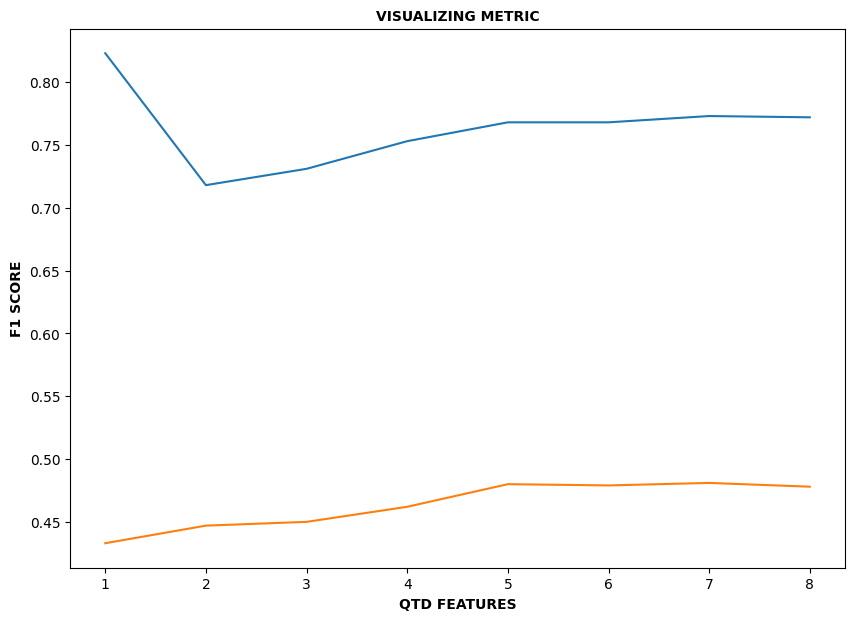

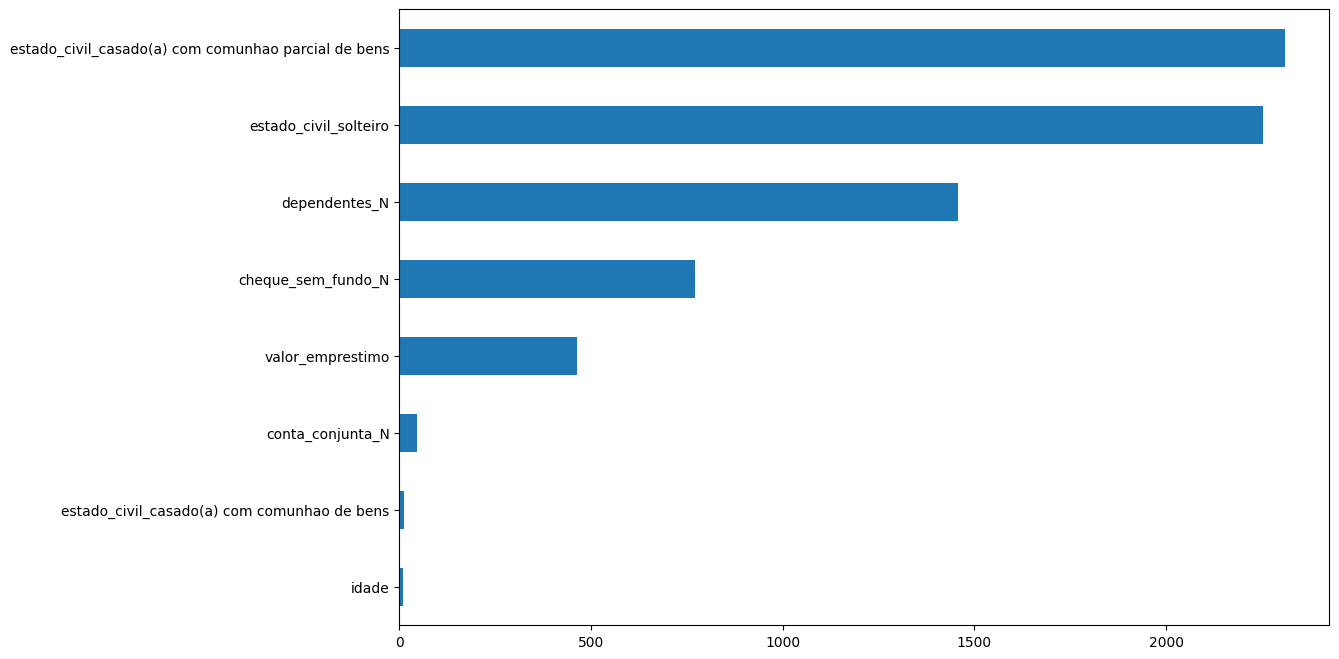

variavel     fs_score  \
0  estado_civil_casado(a) com comunhao parcial de...  2310.296370   
1                              estado_civil_solteiro  2252.493119   
2                                      dependentes_N  1457.194867   
3                                 cheque_sem_fundo_N   770.260255   
4                                   valor_emprestimo   463.627919   
5                                   conta_conjunta_N    45.178405   
6        estado_civil_casado(a) com comunhao de bens    11.793905   
7                                              idade     9.240297   

         p_value  
0   0.000000e+00  
1   0.000000e+00  
2  1.253339e-311  
3  1.747998e-167  
4  4.356637e-102  
5   1.829841e-11  
6   5.950249e-04  
7   2.369434e-03

In [90]:
fs_kbest(x_train, y_train, x_test, y_test, model = LogisticRegression(class_weight='balanced'))

## 9.2 DECISION TREE

### 9.2.1 RECURSIVE FEATURE ADDITION

In [91]:
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from feature_engine.selection import RecursiveFeatureAddition


In [92]:
columns_select = ['dependentes', 'estado_civil', 'idade', 'conta_conjunta', 'cheque_sem_fundo', 'valor_emprestimo', 'pago']

df9_dt = df9[columns_select].copy()

In [93]:
x_train, x_test, y_train, y_test  = train_test_split(df9_dt.drop('pago',axis=1), 
                                                     df9_dt['pago'],test_size = config['split']['test_size'], random_state=config['split']['seed'], stratify=df9_dt['pago'])

In [94]:
ce_rare = RareLabelEncoder(n_categories=5, tol=0.05, variables=['estado_civil'], replace_with='outros')
ce_rare.fit(x_train)

x_train = ce_rare.transform(x_train)
x_test = ce_rare.transform(x_test)

ce_mean = MeanEncoder( variables = ['conta_conjunta', 'dependentes', 'estado_civil', 'cheque_sem_fundo']).fit(x_train, y_train)

x_train = ce_mean.transform(x_train)
x_test = ce_mean.transform(x_test)

In [95]:
ce_mean.encoder_dict_

{'conta_conjunta': {'N': 0.21619533821454961, 'S': 0.1384850803366488},
 'dependentes': {'N': 0.27766357483078463, 'S': 0.09698275862068965},
 'estado_civil': {'casado(a) com comunhao de bens': 0.2315179126113067,
  'casado(a) com comunhao parcial de bens': 0.3888560972730492,
  'outros': 0.2767527675276753,
  'solteiro': 0.11415224291788945},
 'cheque_sem_fundo': {'N': 0.09542038848716858, 'S': 0.2474196770434493}}

In [96]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=config['split']['seed'])

estimator = DecisionTreeClassifier( class_weight='balanced', random_state=config['split']['seed'], max_depth=5)
rfa = RecursiveFeatureAddition(estimator, scoring='roc_auc', cv=kf, threshold=0.005, confirm_variables=False)
rfa.fit_transform(x_train, y_train)


dependentes  estado_civil  cheque_sem_fundo  valor_emprestimo
38633     0.277664      0.114152           0.09542          10946.00
15255     0.277664      0.114152           0.24742           2898.91
22547     0.277664      0.231518           0.24742           1501.00
14271     0.096983      0.114152           0.24742           3169.21
29288     0.096983      0.114152           0.24742           7989.45
...            ...           ...               ...               ...
852       0.277664      0.114152           0.24742           1569.00
27337     0.096983      0.114152           0.09542           2630.11
19111     0.277664      0.231518           0.24742          54697.40
37121     0.096983      0.114152           0.09542           1866.15
9323      0.277664      0.114152           0.24742          18395.02

[31081 rows x 4 columns]

### 9.2.2 FEATURE IMPORTACE

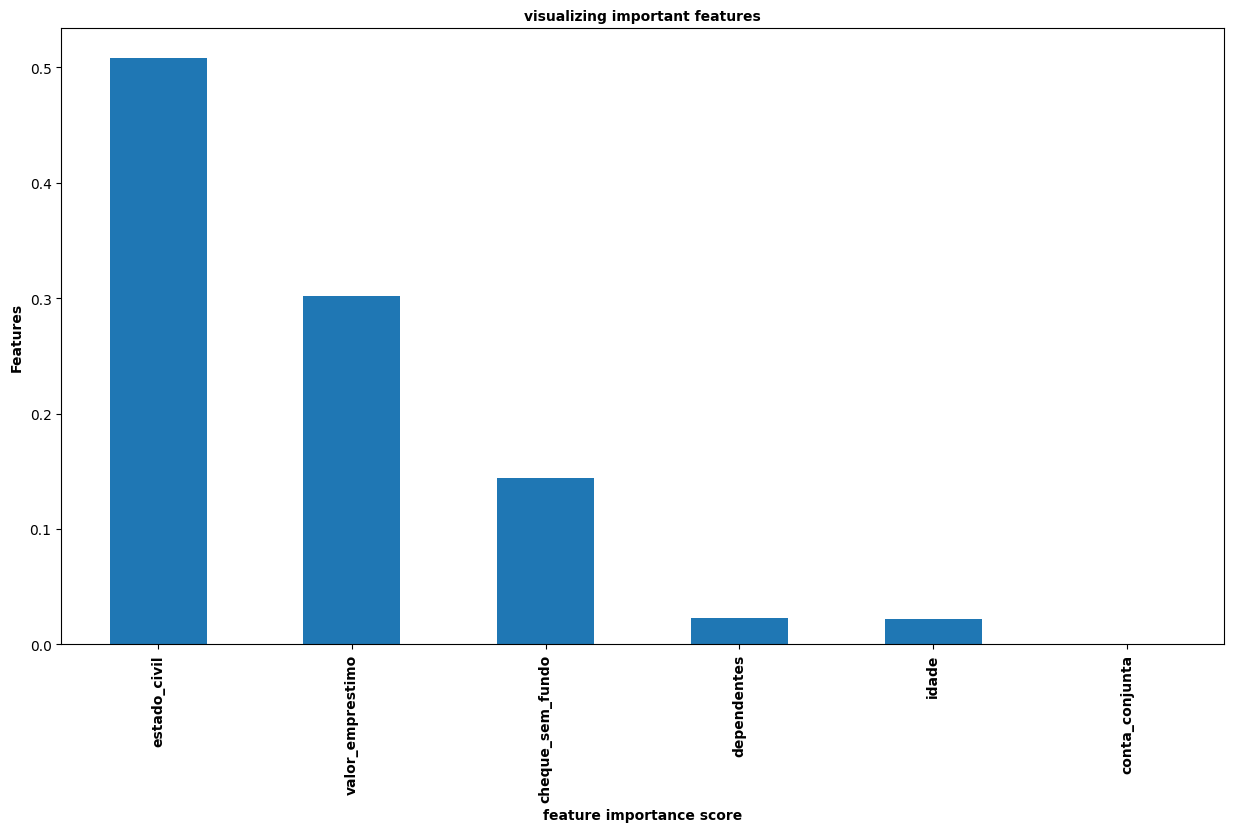

In [97]:
estimator = DecisionTreeClassifier( class_weight='balanced', random_state=config['split']['seed'], max_depth=5).fit(x_train,y_train)

features = pd.Series(estimator.feature_importances_)
features.index = x_train.columns

features.sort_values(ascending=False, inplace=True)

features.plot.bar(figsize=(15,8))

plt.xlabel('feature importance score', fontsize=10, weight='bold')

plt.ylabel('Features', fontsize=10, weight='bold')

plt.title('visualizing important features', fontsize=10, weight='bold')

plt.xticks(fontsize=10, weight='bold')
plt.xticks(fontsize=10, weight='bold')

plt.show()

## 9.3 RANDOM FOREST

### 9.3.1 RECURSIVE FEATURE ADDITION

In [98]:
columns_select = ['dependentes', 'estado_civil', 'idade', 'conta_conjunta', 'cheque_sem_fundo', 'valor_emprestimo', 'pago']

df9_rf = df9[columns_select].copy()

In [99]:
x_train, x_test, y_train, y_test  = train_test_split(df9_rf.drop('pago',axis=1), 
                                                     df9_rf['pago'],test_size = config['split']['test_size'], random_state=config['split']['seed'], stratify=df9_rf['pago'])

In [100]:
ce_rare = RareLabelEncoder(n_categories=5, tol=0.05, variables=['estado_civil'], replace_with='outros')
ce_rare.fit(x_train)

x_train = ce_rare.transform(x_train)
x_test = ce_rare.transform(x_test)

ce_mean = MeanEncoder( variables = ['conta_conjunta', 'dependentes', 'estado_civil', 'cheque_sem_fundo']).fit(x_train, y_train)

x_train = ce_mean.transform(x_train)
x_test = ce_mean.transform(x_test)

In [101]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=config['split']['seed'])

estimator = RandomForestClassifier( class_weight='balanced', random_state=config['split']['seed'], max_depth=5)
rfa = RecursiveFeatureAddition(estimator, scoring='roc_auc', cv=kf, threshold=0.005, confirm_variables=False)
rfa.fit_transform(x_train, y_train)

dependentes  estado_civil  cheque_sem_fundo  valor_emprestimo
38633     0.277664      0.114152           0.09542          10946.00
15255     0.277664      0.114152           0.24742           2898.91
22547     0.277664      0.231518           0.24742           1501.00
14271     0.096983      0.114152           0.24742           3169.21
29288     0.096983      0.114152           0.24742           7989.45
...            ...           ...               ...               ...
852       0.277664      0.114152           0.24742           1569.00
27337     0.096983      0.114152           0.09542           2630.11
19111     0.277664      0.231518           0.24742          54697.40
37121     0.096983      0.114152           0.09542           1866.15
9323      0.277664      0.114152           0.24742          18395.02

[31081 rows x 4 columns]

### 9.3.2 FEATURE IMPORTACE

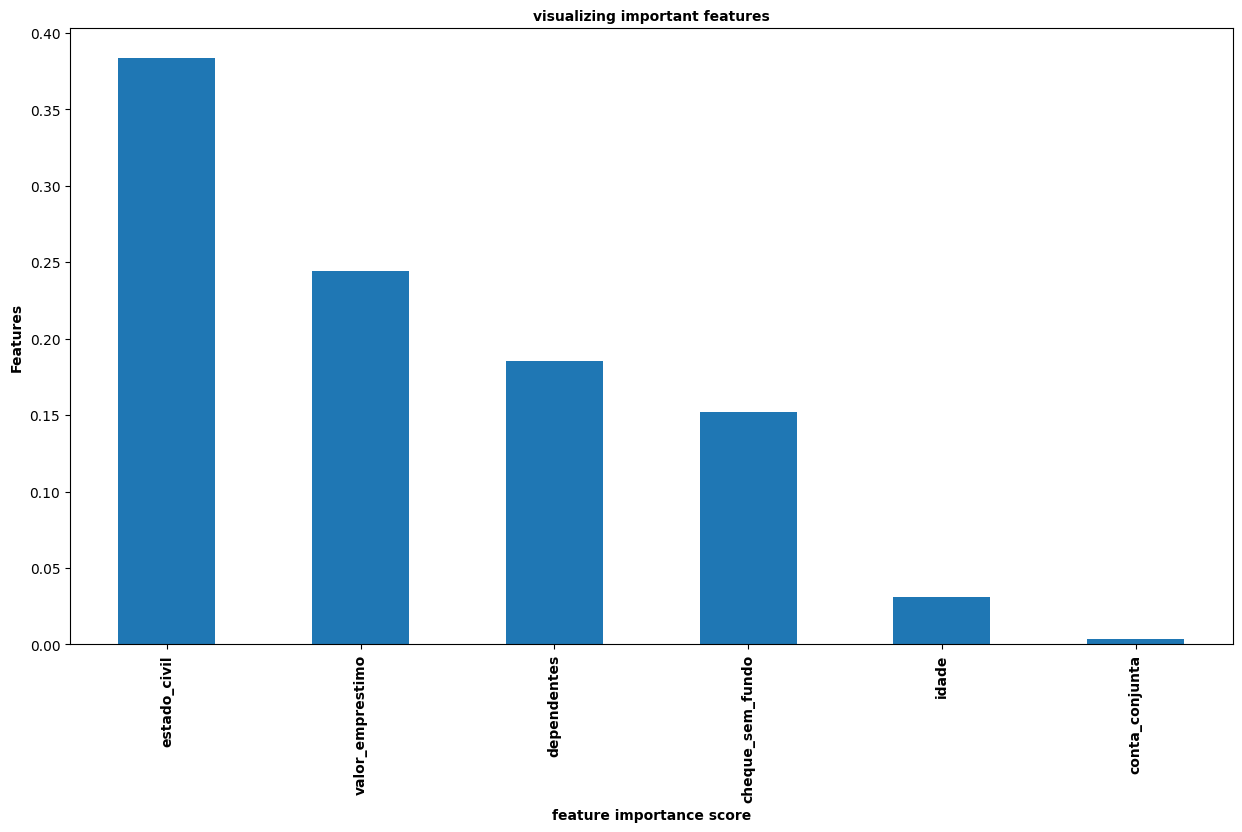

In [102]:
estimator = RandomForestClassifier( class_weight='balanced', random_state=config['split']['seed'], max_depth=5).fit(x_train,y_train)

features = pd.Series(estimator.feature_importances_)
features.index = x_train.columns

features.sort_values(ascending=False, inplace=True)

features.plot.bar(figsize=(15,8))

plt.xlabel('feature importance score', fontsize=10, weight='bold')

plt.ylabel('Features', fontsize=10, weight='bold')

plt.title('visualizing important features', fontsize=10, weight='bold')

plt.xticks(fontsize=10, weight='bold')
plt.xticks(fontsize=10, weight='bold')

plt.show()

# 10.0 PIPELINE ML AND EVALUATION MODEL

## 10.1 LOGISTIC REGRESSION

In [103]:
df10_lr = pd.read_csv(config['data']['train_path']).copy()

columns_select = ['dependentes', 'estado_civil', 'cheque_sem_fundo', 'valor_emprestimo', 'pago']

df10_lr = df10_lr[columns_select].copy()


### 10.1.1 PIPILINE

In [104]:
onehot_features = ['dependentes', 'cheque_sem_fundo','estado_civil']
onehot_encoder = OneHotEncoder(drop_last=True)

target_features = []
target_encoder = MeanEncoder()

std_features = []
std_scaler = StandardScaler()

rare_label = RareLabelEncoder(n_categories=5, tol=0.05, variables=['estado_civil'], replace_with='outros')

yj_features = ['valor_emprestimo']
yj_scaler = PowerTransformer(method='yeo-johnson', standardize=True)
#yj = PowerTransformer(method='yeo-johnson', standardize=True)
preprocessor = ColumnTransformer(
                transformers=[
                    ('onehot_encoder', onehot_encoder, onehot_features),
                    ('target_encoder', target_encoder, target_features),
                    ('std_scaler', std_scaler, std_features),
                    ('yj_scaler', yj_scaler, yj_features)],)

clf = Pipeline(
    steps=[('rare_label', rare_label ), ("preprocessor", preprocessor), ("classifier", LogisticRegression(n_jobs=-1, random_state=config['split']['seed'], class_weight='balanced'))]
)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=config['split']['seed'])
               

### 10.1.2 TRAIN AND VALIDATION METRICS

In [105]:
lr_result = cv_clf_metrics(model =clf, df= df10_lr, target = 'pago', cv = kf, model_name='lr', search=False)

TRAIN DATA
accuracy:          [0.682, 0.696, 0.694, 0.683, 0.684] / media: 0.688 / std: 0.006
balanced_accuracy: [0.687, 0.688, 0.687, 0.688, 0.687] / media: 0.687 / std: 0.0
roc_auc:           [0.747, 0.746, 0.745, 0.745, 0.745] / media: 0.746 / std: 0.001
f1_class_0:        [0.771, 0.784, 0.782, 0.771, 0.773] / media: 0.776 / std: 0.006
f1_class_1:        [0.482, 0.486, 0.484, 0.483, 0.482] / media: 0.483 / std: 0.001
precision_class_0: [0.892, 0.889, 0.888, 0.892, 0.891] / media: 0.89 / std: 0.002
precision_class_1: [0.369, 0.38, 0.378, 0.37, 0.371] / media: 0.374 / std: 0.004
recall_class_0 :   [0.679, 0.702, 0.699, 0.679, 0.683] / media: 0.688 / std: 0.01
recall_class_1 :   [0.695, 0.675, 0.676, 0.696, 0.69] / media: 0.686 / std: 0.009

---------------------------------------------------------------------------------------

TEST DATA
accuracy:          [0.689, 0.688, 0.698, 0.675, 0.684] / media: 0.687 / std: 0.007
balanced_accuracy: [0.687, 0.677, 0.688, 0.686, 0.692] / media: 0.

Model Name    Accuracy CV Balanced Accuracy CV Roc Auc Score CV  \
0         lr  0.687+/-0.007        0.686+/-0.005    0.745+/-0.003   

  Precision Class 0 CV Precision Class 1 CV Recall Class 0 CV  \
0         0.89+/-0.004        0.373+/-0.006     0.688+/-0.014   

  Recall Class 1 CV F1 Score Class 0 CV F1 Score Class 1 CV  
0     0.685+/-0.019       0.776+/-0.008       0.482+/-0.005

### 10.1.3 GRID SEARCH

In [106]:
param_grid = {
    'classifier__C': np.logspace(-3, 3, 7),
    'classifier__penalty': ['l1', 'l2', 'elasticnet', None],
    'classifier__class_weight':['balanced'],
    'classifier__solver': ['saga', 'liblinear', 'lbfgs'],
}

In [107]:
lr = GridSearchCV( clf, param_grid, scoring=['f1', 'balanced_accuracy', 'roc_auc', 'accuracy'], cv=kf, refit='roc_auc')
search_lr = lr.fit(df10_lr.drop('pago', axis=1), df10_lr['pago'])

In [108]:
print(search_lr.best_params_)
print('\n')
print(round(search_lr.best_score_,3))

{'classifier__C': 0.1, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}


0.745


In [109]:
results = pd.DataFrame(search_lr.cv_results_) [['params', 'mean_test_roc_auc', 'std_test_roc_auc', 'mean_test_f1', 'std_test_f1',
                                                'mean_test_balanced_accuracy', 'std_test_balanced_accuracy', 'mean_test_accuracy', 'std_test_accuracy']]
results.sort_values(by='mean_test_roc_auc', ascending=False, inplace=True)
results.head()

params  mean_test_roc_auc  \
28  {'classifier__C': 0.1, 'classifier__class_weig...           0.745284   
25  {'classifier__C': 0.1, 'classifier__class_weig...           0.745269   
27  {'classifier__C': 0.1, 'classifier__class_weig...           0.745264   
29  {'classifier__C': 0.1, 'classifier__class_weig...           0.745263   
37  {'classifier__C': 1.0, 'classifier__class_weig...           0.745255   

    std_test_roc_auc  mean_test_f1  std_test_f1  mean_test_balanced_accuracy  \
28          0.002504      0.482585     0.004851                     0.686458   
25          0.002488      0.482551     0.005312                     0.686656   
27          0.002502      0.482563     0.004865                     0.686442   
29          0.002502      0.482521     0.004883                     0.686409   
37          0.002504      0.482390     0.004975                     0.686277   

    std_test_balanced_accuracy  mean_test_accuracy  std_test_accuracy  
28                    0.004621            0.687017           0.007644  
25                    0.004901            0.685524           0.007731  
27                    0.004646            0.686992           0.007574  
29                    0.004668            0.686940           0.007531  
37                    0.004741            0.686940           0.007755

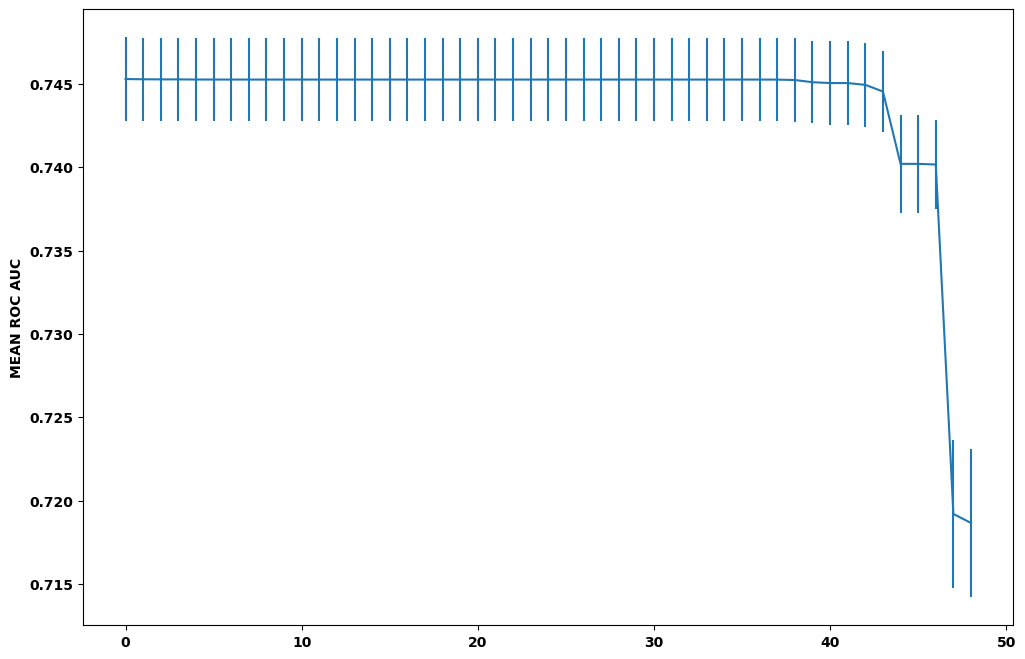

In [110]:
results.sort_values(by='mean_test_roc_auc', ascending=False, inplace=True)

results.reset_index(drop=True, inplace=True)

results['mean_test_roc_auc'].plot(yerr=[results['std_test_roc_auc'], results['std_test_roc_auc']], subplots=True)

plt.ylabel('MEAN ROC AUC', fontsize=10, weight='bold')

plt.xticks(fontsize=10, weight='bold')
plt.yticks(fontsize=10, weight='bold');

### 10.1.4 EVAL BEST LR MODEL

In [111]:
search_lr.best_estimator_

Pipeline(steps=[('rare_label',
                 RareLabelEncoder(n_categories=5, replace_with='outros',
                                  variables=['estado_civil'])),
                ('preprocessor',
                 ColumnTransformer(transformers=[('onehot_encoder',
                                                  OneHotEncoder(drop_last=True),
                                                  ['dependentes',
                                                   'cheque_sem_fundo',
                                                   'estado_civil']),
                                                 ('target_encoder',
                                                  MeanEncoder(), []),
                                                 ('std_scaler',
                                                  StandardScaler(), []),
                                                 ('yj_scaler',
                                                  PowerTransformer(),
                                                  ['valor_emprestimo'])])),
                ('classifier',
                 LogisticRegression(C=0.1, class_weight='balanced', n_jobs=-1,
                                    random_state=42, solver='liblinear'))])

In [112]:
lr_result = cv_clf_metrics(model = search_lr.best_estimator_, df= df10_lr, target = 'pago', cv = kf, model_name='lr', search=True)

TRAIN DATA
accuracy:          [0.687, 0.689, 0.686, 0.689, 0.687] / media: 0.688 / std: 0.001
balanced_accuracy: [0.688, 0.69, 0.687, 0.687, 0.686] / media: 0.688 / std: 0.001
roc_auc:           [0.747, 0.746, 0.745, 0.745, 0.745] / media: 0.746 / std: 0.001
f1_class_0:        [0.775, 0.778, 0.775, 0.778, 0.776] / media: 0.776 / std: 0.001
f1_class_1:        [0.484, 0.486, 0.483, 0.484, 0.482] / media: 0.484 / std: 0.001
precision_class_0: [0.891, 0.891, 0.89, 0.89, 0.889] / media: 0.89 / std: 0.001
precision_class_1: [0.373, 0.375, 0.372, 0.374, 0.372] / media: 0.373 / std: 0.001
recall_class_0 :   [0.686, 0.689, 0.686, 0.69, 0.688] / media: 0.688 / std: 0.002
recall_class_1 :   [0.689, 0.69, 0.687, 0.684, 0.683] / media: 0.687 / std: 0.003

---------------------------------------------------------------------------------------

TEST DATA
accuracy:          [0.691, 0.681, 0.694, 0.683, 0.69] / media: 0.688 / std: 0.005
balanced_accuracy: [0.686, 0.679, 0.691, 0.688, 0.694] / media: 0.

Model Name    Accuracy CV Balanced Accuracy CV Roc Auc Score CV  \
0         lr  0.688+/-0.005        0.688+/-0.005    0.746+/-0.003   

  Precision Class 0 CV Precision Class 1 CV Recall Class 0 CV  \
0         0.89+/-0.003        0.374+/-0.005     0.688+/-0.007   

  Recall Class 1 CV F1 Score Class 0 CV F1 Score Class 1 CV  
0      0.687+/-0.01       0.776+/-0.004       0.484+/-0.006

### 10.1.5 TES SET METRICS

In [113]:
test_set = pd.read_csv(config['data']['test_path'])
test_set = test_set[df10_lr.columns]
x_test = test_set.drop('pago', axis=1)
y_test = test_set['pago']

     Predito     0     1   All
Real                          
0             5297  2349  7646
1              610  1458  2068
All           5907  3807  9714



              precision    recall  f1-score   support

           0       0.90      0.69      0.78      7646
           1       0.38      0.71      0.50      2068

    accuracy                           0.70      9714
   macro avg       0.64      0.70      0.64      9714
weighted avg       0.79      0.70      0.72      9714



 ROC_AUC 0.76


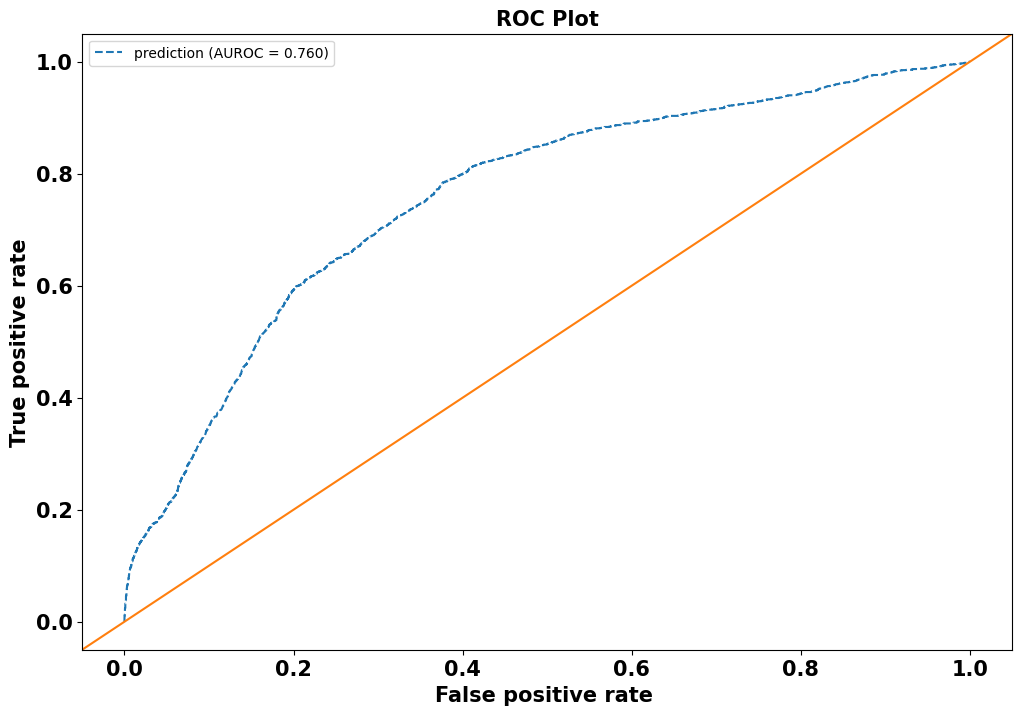

     Predito     0     1   All
Real                          
0             5733  1913  7646
1              731  1337  2068
All           6464  3250  9714



              precision    recall  f1-score   support

           0       0.89      0.75      0.81      7646
           1       0.41      0.65      0.50      2068

    accuracy                           0.73      9714
   macro avg       0.65      0.70      0.66      9714
weighted avg       0.79      0.73      0.75      9714





In [114]:
cm_roc_plot(search_lr.best_estimator_, x_test, y_test, th=0.55)

## 10.2 DECISION TREE

In [115]:
df10_dt = pd.read_csv(config['data']['train_path']).copy()

columns_select = ['dependentes', 'estado_civil', 'cheque_sem_fundo', 'valor_emprestimo', 'pago']

df10_dt = df10_dt[columns_select].copy()

### 10.2.1 PIPELINE

In [116]:
clf = Pipeline([

    ('rare_encoder', RareLabelEncoder(tol=0.05, n_categories=5, 
      variables=['estado_civil'], replace_with='outros',
     )), 

    ('categorical_encoder', MeanEncoder(
        variables= ['dependentes', 'estado_civil', 'cheque_sem_fundo'],
    )),

    ('classifier', DecisionTreeClassifier( class_weight='balanced', random_state=config['split']['seed'], max_depth=5))
])

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state = config['split']['seed'])
    

### 10.2.2 TRAIN AND VALIDATION METRICS

In [117]:
dt_result = cv_clf_metrics(model =clf, df= df10_dt, target = 'pago', cv = kf, model_name='dt', search=False)

TRAIN DATA
accuracy:          [0.673, 0.745, 0.736, 0.744, 0.726] / media: 0.725 / std: 0.027
balanced_accuracy: [0.705, 0.705, 0.705, 0.703, 0.703] / media: 0.704 / std: 0.001
roc_auc:           [0.772, 0.769, 0.769, 0.768, 0.769] / media: 0.769 / std: 0.001
f1_class_0:        [0.758, 0.827, 0.819, 0.826, 0.81] / media: 0.808 / std: 0.026
f1_class_1:        [0.498, 0.515, 0.512, 0.512, 0.508] / media: 0.509 / std: 0.006
precision_class_0: [0.909, 0.887, 0.889, 0.886, 0.891] / media: 0.892 / std: 0.008
precision_class_1: [0.37, 0.433, 0.422, 0.431, 0.411] / media: 0.413 / std: 0.023
recall_class_0 :   [0.65, 0.775, 0.759, 0.774, 0.743] / media: 0.74 / std: 0.047
recall_class_1 :   [0.76, 0.636, 0.651, 0.633, 0.663] / media: 0.669 / std: 0.047

---------------------------------------------------------------------------------------

TEST DATA
accuracy:          [0.671, 0.74, 0.735, 0.74, 0.721] / media: 0.721 / std: 0.026
balanced_accuracy: [0.692, 0.699, 0.699, 0.705, 0.701] / media: 0.

Model Name    Accuracy CV Balanced Accuracy CV Roc Auc Score CV  \
0         dt  0.721+/-0.026        0.699+/-0.004    0.764+/-0.005   

  Precision Class 0 CV Precision Class 1 CV Recall Class 0 CV  \
0         0.89+/-0.005        0.408+/-0.024     0.738+/-0.043   

  Recall Class 1 CV F1 Score Class 0 CV F1 Score Class 1 CV  
0     0.661+/-0.036       0.806+/-0.025        0.503+/-0.01

### 10.3.2 GRID SEARCH

In [118]:
param_grid = {
    'classifier__max_features': ['auto','sqrt', 'log2'] ,
    'classifier__class_weight':['balanced'],
    'classifier__min_samples_leaf': [100, 200, 300, 400],
    'classifier__min_samples_split': [100, 200, 300, 400],
    'classifier__max_depth': [3, 4, 5, 6, 7],
}

In [119]:
dt = GridSearchCV( clf, param_grid, scoring=['f1', 'balanced_accuracy', 'roc_auc', 'accuracy'], cv=kf, refit='roc_auc')
search_dt = dt.fit(df10_dt.drop('pago', axis=1), df10_dt['pago'])

In [120]:
print(search_dt.best_params_)
print('\n')
print(round(search_dt.best_score_,3))

{'classifier__class_weight': 'balanced', 'classifier__max_depth': 6, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 100, 'classifier__min_samples_split': 400}


0.766


In [121]:
results = pd.DataFrame(search_dt.cv_results_) [['params', 'mean_test_roc_auc', 'std_test_roc_auc', 'mean_test_f1', 'std_test_f1',
                                                'mean_test_balanced_accuracy', 'std_test_balanced_accuracy', 'mean_test_accuracy', 'std_test_accuracy']]
results.sort_values(by='mean_test_roc_auc', ascending=False, inplace=True)
results.head()

params  mean_test_roc_auc  \
163  {'classifier__class_weight': 'balanced', 'clas...           0.765881   
179  {'classifier__class_weight': 'balanced', 'clas...           0.765881   
178  {'classifier__class_weight': 'balanced', 'clas...           0.765414   
162  {'classifier__class_weight': 'balanced', 'clas...           0.765414   
164  {'classifier__class_weight': 'balanced', 'clas...           0.764742   

     std_test_roc_auc  mean_test_f1  std_test_f1  mean_test_balanced_accuracy  \
163          0.005549      0.505072     0.011163                     0.701677   
179          0.005549      0.505072     0.011163                     0.701677   
178          0.004845      0.503248     0.007747                     0.701471   
162          0.004845      0.503248     0.007747                     0.701471   
164          0.005505      0.508544     0.011782                     0.703480   

     std_test_balanced_accuracy  mean_test_accuracy  std_test_accuracy  
163                    0.006378            0.718960           0.025646  
179                    0.006378            0.718960           0.025646  
178                    0.003684            0.713014           0.024109  
162                    0.003684            0.713014           0.024109  
164                    0.006413            0.725266           0.025948

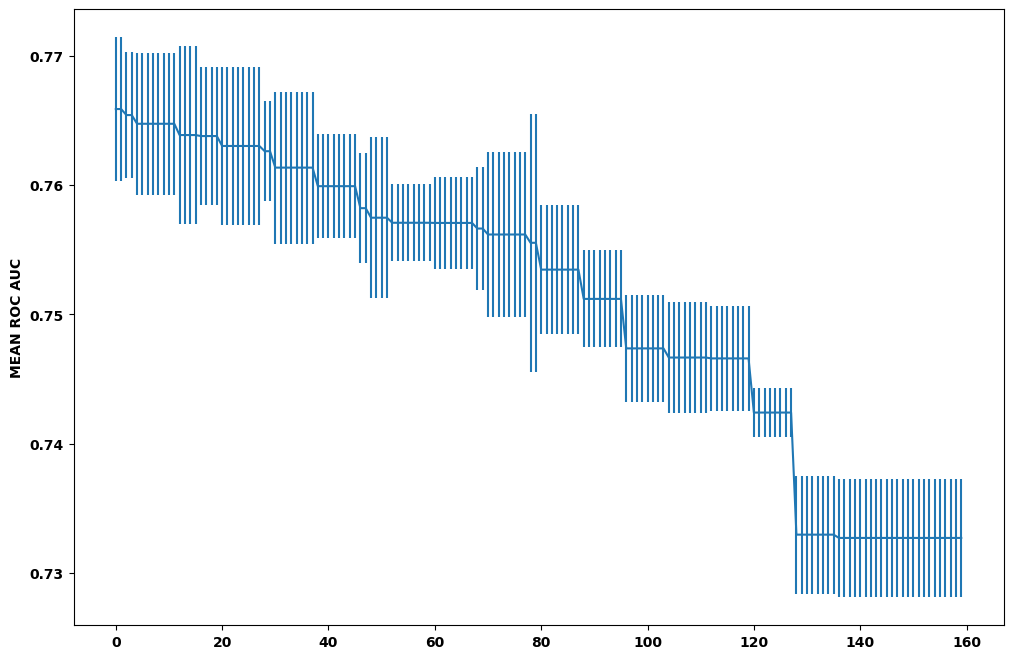

In [122]:
results.sort_values(by='mean_test_roc_auc', ascending=False, inplace=True)

results.reset_index(drop=True, inplace=True)

results['mean_test_roc_auc'].plot(yerr=[results['std_test_roc_auc'], results['std_test_roc_auc']], subplots=True)

plt.ylabel('MEAN ROC AUC', fontsize=10, weight='bold')

plt.xticks(fontsize=10, weight='bold')
plt.yticks(fontsize=10, weight='bold');

### 10.2.4 EVAL BEST DT MODEL

In [123]:
search_dt.best_estimator_

Pipeline(steps=[('rare_encoder',
                 RareLabelEncoder(n_categories=5, replace_with='outros',
                                  variables=['estado_civil'])),
                ('categorical_encoder',
                 MeanEncoder(variables=['dependentes', 'estado_civil',
                                        'cheque_sem_fundo'])),
                ('classifier',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=6,
                                        max_features='sqrt',
                                        min_samples_leaf=100,
                                        min_samples_split=400,
                                        random_state=42))])

In [124]:
dt_result = cv_clf_metrics(model = search_dt.best_estimator_, df= df10_dt, target = 'pago', cv = kf, model_name='dt', search=True)

TRAIN DATA
accuracy:          [0.734, 0.735, 0.734, 0.735, 0.735] / media: 0.735 / std: 0.0
balanced_accuracy: [0.705, 0.705, 0.704, 0.703, 0.705] / media: 0.704 / std: 0.001
roc_auc:           [0.774, 0.771, 0.771, 0.771, 0.771] / media: 0.772 / std: 0.001
f1_class_0:        [0.817, 0.818, 0.817, 0.818, 0.819] / media: 0.818 / std: 0.001
f1_class_1:        [0.511, 0.512, 0.511, 0.51, 0.512] / media: 0.511 / std: 0.001
precision_class_0: [0.89, 0.89, 0.89, 0.888, 0.889] / media: 0.889 / std: 0.001
precision_class_1: [0.42, 0.422, 0.42, 0.421, 0.421] / media: 0.421 / std: 0.001
recall_class_0 :   [0.755, 0.758, 0.756, 0.758, 0.758] / media: 0.757 / std: 0.001
recall_class_1 :   [0.654, 0.653, 0.653, 0.648, 0.651] / media: 0.652 / std: 0.002

---------------------------------------------------------------------------------------

TEST DATA
accuracy:          [0.738, 0.732, 0.738, 0.733, 0.732] / media: 0.735 / std: 0.003
balanced_accuracy: [0.704, 0.701, 0.704, 0.709, 0.704] / media: 0.7

Model Name    Accuracy CV Balanced Accuracy CV Roc Auc Score CV  \
0         dt  0.735+/-0.003        0.704+/-0.003    0.772+/-0.005   

  Precision Class 0 CV Precision Class 1 CV Recall Class 0 CV  \
0        0.889+/-0.002         0.42+/-0.003     0.757+/-0.005   

  Recall Class 1 CV F1 Score Class 0 CV F1 Score Class 1 CV  
0     0.652+/-0.009       0.818+/-0.003       0.511+/-0.003

### 10.2.5 TEST SET METRICS

In [125]:
test_set = pd.read_csv(config['data']['test_path'])
test_set = test_set[df10_dt.columns]
x_test = test_set.drop('pago', axis=1)
y_test = test_set['pago']

     Predito     0     1   All
Real                          
0             5826  1820  7646
1              722  1346  2068
All           6548  3166  9714



              precision    recall  f1-score   support

           0       0.89      0.76      0.82      7646
           1       0.43      0.65      0.51      2068

    accuracy                           0.74      9714
   macro avg       0.66      0.71      0.67      9714
weighted avg       0.79      0.74      0.76      9714



 ROC_AUC 0.77


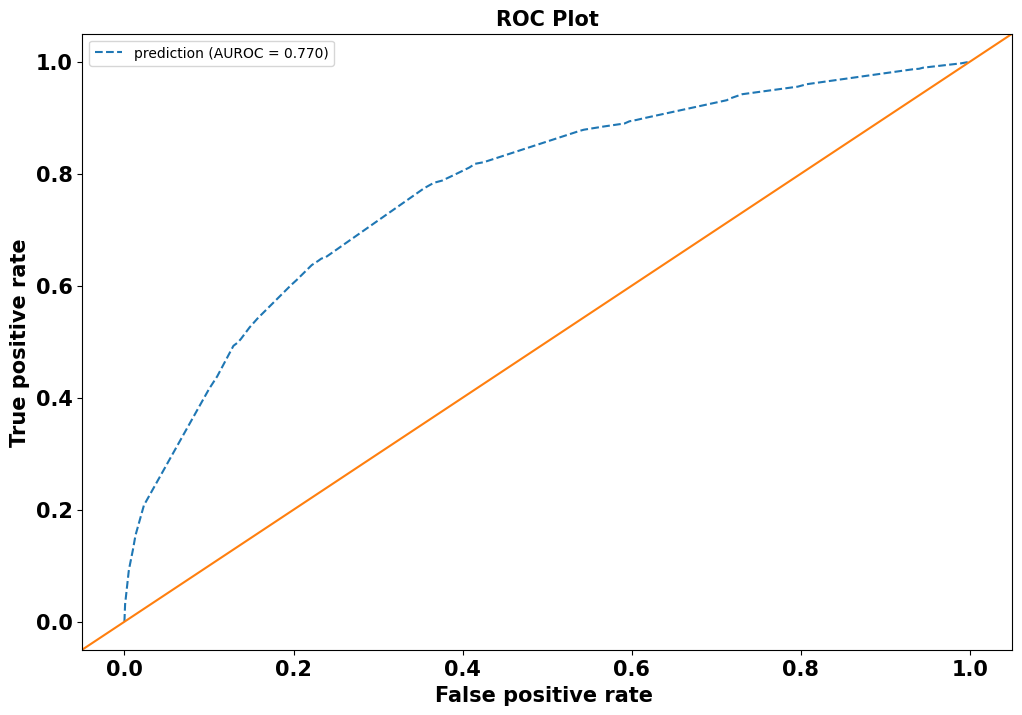

     Predito     0     1   All
Real                          
0             4935  2711  7646
1              467  1601  2068
All           5402  4312  9714



              precision    recall  f1-score   support

           0       0.91      0.65      0.76      7646
           1       0.37      0.77      0.50      2068

    accuracy                           0.67      9714
   macro avg       0.64      0.71      0.63      9714
weighted avg       0.80      0.67      0.70      9714





In [126]:
cm_roc_plot(search_dt.best_estimator_, x_test, y_test, th=0.45)

## 10.3 RANDOM FOREST

In [127]:
df10_rf = pd.read_csv(config['data']['train_path']).copy()

columns_select = ['dependentes', 'estado_civil', 'cheque_sem_fundo', 'idade', 'valor_emprestimo', 'pago']

df10_rf = df10_rf[columns_select].copy()

### 10.3.1 PIPELINE

In [128]:
clf = Pipeline([

    ('rare_encoder', RareLabelEncoder(tol=0.05, n_categories=5, 
      variables=['estado_civil'], replace_with='outros',
     )), 

    ('categorical_encoder', MeanEncoder(
        variables= ['dependentes', 'estado_civil', 'cheque_sem_fundo'],
    )),

       ('classifier', RandomForestClassifier(n_estimators = 200, random_state=config['split']['seed'], class_weight='balanced',max_features='sqrt',
                           max_depth= 5, n_jobs=-1))
])

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state = config['split']['seed'])
    

### 10.3.2 TRAIN AND VALIDATION METRICS

In [129]:
rf_result = cv_clf_metrics(model =clf, df= df10_rf, target = 'pago', cv = kf, model_name='rf', search=False)

TRAIN DATA
accuracy:          [0.687, 0.705, 0.714, 0.686, 0.684] / media: 0.695 / std: 0.012
balanced_accuracy: [0.714, 0.716, 0.718, 0.71, 0.709] / media: 0.713 / std: 0.003
roc_auc:           [0.784, 0.78, 0.781, 0.781, 0.779] / media: 0.781 / std: 0.002
f1_class_0:        [0.771, 0.788, 0.797, 0.77, 0.768] / media: 0.779 / std: 0.012
f1_class_1:        [0.509, 0.515, 0.519, 0.505, 0.503] / media: 0.51 / std: 0.006
precision_class_0: [0.912, 0.906, 0.905, 0.908, 0.909] / media: 0.908 / std: 0.002
precision_class_1: [0.382, 0.396, 0.405, 0.38, 0.378] / media: 0.388 / std: 0.011
recall_class_0 :   [0.668, 0.698, 0.712, 0.668, 0.665] / media: 0.682 / std: 0.019
recall_class_1 :   [0.761, 0.734, 0.724, 0.751, 0.752] / media: 0.744 / std: 0.013

---------------------------------------------------------------------------------------

TEST DATA
accuracy:          [0.682, 0.702, 0.709, 0.677, 0.688] / media: 0.692 / std: 0.012
balanced_accuracy: [0.696, 0.714, 0.706, 0.706, 0.714] / media: 

Model Name    Accuracy CV Balanced Accuracy CV Roc Auc Score CV  \
0         rf  0.692+/-0.012        0.707+/-0.007    0.775+/-0.005   

  Precision Class 0 CV Precision Class 1 CV Recall Class 0 CV  \
0        0.905+/-0.005         0.384+/-0.01       0.68+/-0.02   

  Recall Class 1 CV F1 Score Class 0 CV F1 Score Class 1 CV  
0     0.735+/-0.022       0.776+/-0.011       0.504+/-0.008

### 10.3.3 RANDOM SEARCH

In [130]:
param_grid = {
    # try different feature engineering parameters:
    'classifier__n_estimators': [100, 150, 200],
    'classifier__max_features':['auto', 'sqrt'],
    'classifier__class_weight':['balanced'],
    'classifier__min_samples_leaf':[100,200,300],
    'classifier__min_samples_split':[100,200,300],
    'classifier__max_depth':[5,6,7,8],
}

In [131]:
rf = RandomizedSearchCV( clf, param_grid, scoring=['f1', 'balanced_accuracy', 'roc_auc', 'accuracy'], cv=kf, refit='roc_auc',
                        random_state=config['split']['seed'], n_iter=60)

search_rf = rf.fit(df10_rf.drop('pago', axis=1), df10_rf['pago'])

In [132]:
print(search_rf.best_params_)
print('\n')
print(round(search_rf.best_score_,3))

{'classifier__n_estimators': 150, 'classifier__min_samples_split': 100, 'classifier__min_samples_leaf': 100, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 8, 'classifier__class_weight': 'balanced'}


0.778


In [133]:
results = pd.DataFrame(search_rf.cv_results_) [['params', 'mean_test_roc_auc', 'std_test_roc_auc', 'mean_test_f1', 'std_test_f1',
                                                'mean_test_balanced_accuracy', 'std_test_balanced_accuracy', 'mean_test_accuracy', 'std_test_accuracy']]
results.sort_values(by='mean_test_roc_auc', ascending=False, inplace=True)
results.head()

params  mean_test_roc_auc  \
12  {'classifier__n_estimators': 150, 'classifier_...           0.778027   
33  {'classifier__n_estimators': 100, 'classifier_...           0.777966   
9   {'classifier__n_estimators': 150, 'classifier_...           0.777379   
46  {'classifier__n_estimators': 200, 'classifier_...           0.777364   
2   {'classifier__n_estimators': 100, 'classifier_...           0.777325   

    std_test_roc_auc  mean_test_f1  std_test_f1  mean_test_balanced_accuracy  \
12          0.005190      0.515105     0.005190                     0.712946   
33          0.005019      0.516169     0.004795                     0.713817   
9           0.005225      0.515295     0.006933                     0.712288   
46          0.005246      0.516190     0.006597                     0.712937   
2           0.005149      0.513952     0.005655                     0.711322   

    std_test_balanced_accuracy  mean_test_accuracy  std_test_accuracy  
12                    0.004728            0.717054           0.005886  
33                    0.004118            0.717801           0.006676  
9                     0.005357            0.719834           0.010126  
46                    0.004980            0.720787           0.009915  
2                     0.004878            0.718521           0.009671

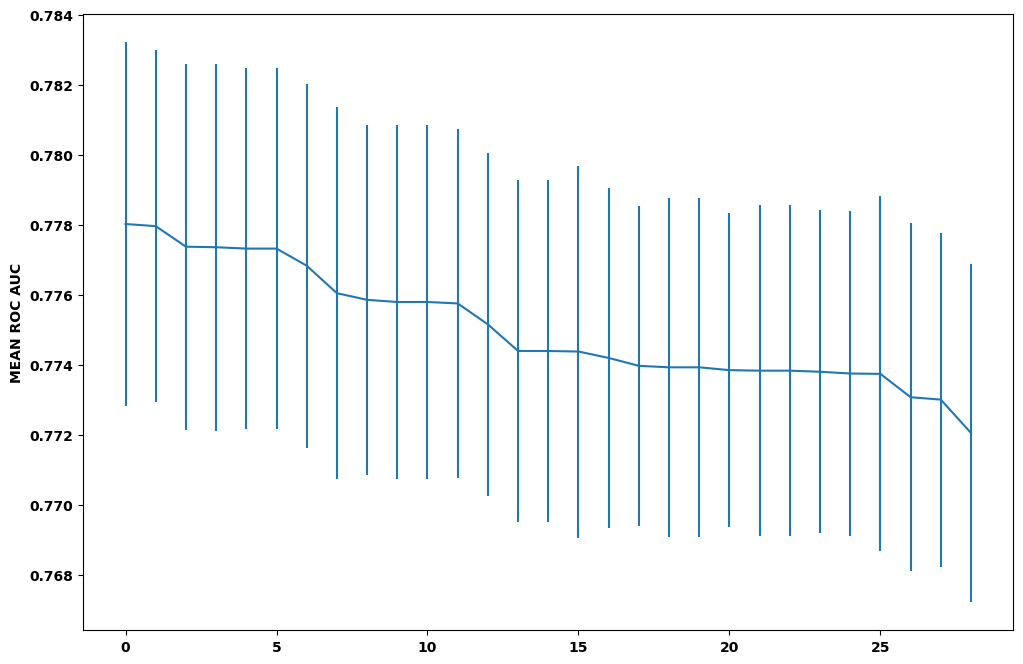

In [134]:
results.sort_values(by='mean_test_roc_auc', ascending=False, inplace=True)

results.reset_index(drop=True, inplace=True)

results['mean_test_roc_auc'].plot(yerr=[results['std_test_roc_auc'], results['std_test_roc_auc']], subplots=True)

plt.ylabel('MEAN ROC AUC', fontsize=10, weight='bold')

plt.xticks(fontsize=10, weight='bold')
plt.yticks(fontsize=10, weight='bold');

### 10.3.4 EVAL BEST RF MODEL

In [135]:
rf_result = cv_clf_metrics(model = search_rf.best_estimator_, df= df10_rf, target = 'pago', cv = kf, model_name='rf', search=True)

TRAIN DATA
accuracy:          [0.718, 0.718, 0.719, 0.719, 0.718] / media: 0.718 / std: 0.0
balanced_accuracy: [0.72, 0.717, 0.72, 0.718, 0.717] / media: 0.718 / std: 0.001
roc_auc:           [0.79, 0.787, 0.788, 0.787, 0.786] / media: 0.788 / std: 0.001
f1_class_0:        [0.8, 0.8, 0.801, 0.801, 0.801] / media: 0.801 / std: 0.0
f1_class_1:        [0.522, 0.52, 0.523, 0.521, 0.519] / media: 0.521 / std: 0.001
precision_class_0: [0.906, 0.904, 0.905, 0.904, 0.903] / media: 0.904 / std: 0.001
precision_class_1: [0.408, 0.407, 0.41, 0.409, 0.408] / media: 0.408 / std: 0.001
recall_class_0 :   [0.716, 0.718, 0.718, 0.72, 0.719] / media: 0.718 / std: 0.001
recall_class_1 :   [0.724, 0.717, 0.722, 0.717, 0.715] / media: 0.719 / std: 0.003

---------------------------------------------------------------------------------------

TEST DATA
accuracy:          [0.72, 0.722, 0.715, 0.716, 0.719] / media: 0.718 / std: 0.003
balanced_accuracy: [0.713, 0.724, 0.712, 0.72, 0.725] / media: 0.719 / std

Model Name    Accuracy CV Balanced Accuracy CV Roc Auc Score CV  \
0         rf  0.718+/-0.003        0.719+/-0.005    0.788+/-0.005   

  Precision Class 0 CV Precision Class 1 CV Recall Class 0 CV  \
0        0.904+/-0.004        0.408+/-0.003     0.718+/-0.004   

  Recall Class 1 CV F1 Score Class 0 CV F1 Score Class 1 CV  
0     0.719+/-0.014       0.801+/-0.002       0.521+/-0.006

### 10.3.5 TEST SET METRICS

In [136]:
test_set = pd.read_csv(config['data']['test_path'])
test_set = test_set[df10_rf.columns]
x_test = test_set.drop('pago', axis=1)
y_test = test_set['pago']

     Predito     0     1   All
Real                          
0             5565  2081  7646
1              587  1481  2068
All           6152  3562  9714



              precision    recall  f1-score   support

           0       0.90      0.73      0.81      7646
           1       0.42      0.72      0.53      2068

    accuracy                           0.73      9714
   macro avg       0.66      0.72      0.67      9714
weighted avg       0.80      0.73      0.75      9714



 ROC_AUC 0.79


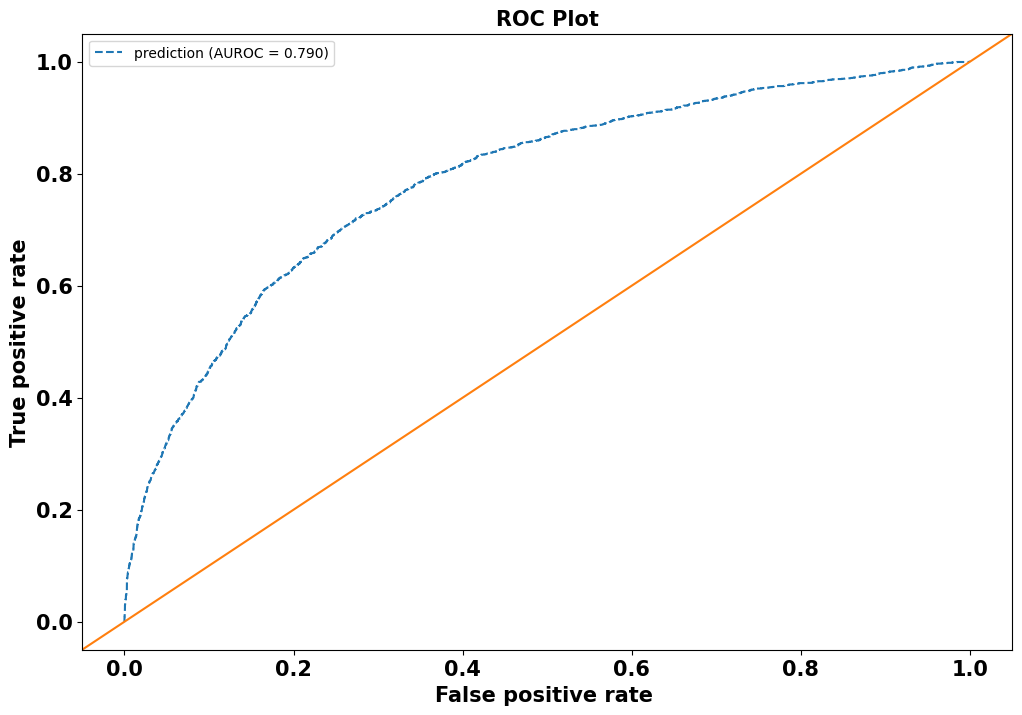

     Predito     0     1   All
Real                          
0             5025  2621  7646
1              456  1612  2068
All           5481  4233  9714



              precision    recall  f1-score   support

           0       0.92      0.66      0.77      7646
           1       0.38      0.78      0.51      2068

    accuracy                           0.68      9714
   macro avg       0.65      0.72      0.64      9714
weighted avg       0.80      0.68      0.71      9714





In [137]:
cm_roc_plot(search_rf.best_estimator_, x_test, y_test, th=0.45)

## 10.4 XGBOOST

In [138]:
df10_xgb = pd.read_csv(config['data']['train_path']).copy()

columns_select = ['dependentes', 'estado_civil', 'cheque_sem_fundo', 'idade', 'valor_emprestimo', 'pago']

df10_xgb = df10_xgb[columns_select].copy()

### 10.4.1 PIPELINE

In [139]:
clf = Pipeline([

    ('rare_encoder', RareLabelEncoder(tol=0.05, n_categories=5, 
      variables=['estado_civil'], replace_with='outros',
     )), 

    ('categorical_encoder', MeanEncoder(
        variables= ['dependentes', 'estado_civil', 'cheque_sem_fundo'],
    )),

       ('classifier', xgb.XGBClassifier(n_estimators = 200, random_state=config['split']['seed'], scale_pos_weight= 4,
                           max_depth= 3, n_jobs=-1))
])

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state = config['split']['seed'])
    

### 10.4.2 TRAIN AND VALIDATION METRICS

In [140]:
xgb_result = cv_clf_metrics(model =clf, df= df10_xgb, target = 'pago', cv = kf, model_name='xgb', search=False)

TRAIN DATA
accuracy:          [0.729, 0.728, 0.731, 0.727, 0.724] / media: 0.728 / std: 0.002
balanced_accuracy: [0.733, 0.732, 0.733, 0.732, 0.73] / media: 0.732 / std: 0.001
roc_auc:           [0.808, 0.805, 0.806, 0.806, 0.805] / media: 0.806 / std: 0.001
f1_class_0:        [0.809, 0.807, 0.81, 0.807, 0.804] / media: 0.807 / std: 0.002
f1_class_1:        [0.538, 0.537, 0.538, 0.536, 0.534] / media: 0.537 / std: 0.001
precision_class_0: [0.912, 0.912, 0.911, 0.911, 0.911] / media: 0.911 / std: 0.0
precision_class_1: [0.423, 0.421, 0.424, 0.42, 0.417] / media: 0.421 / std: 0.002
recall_class_0 :   [0.727, 0.725, 0.729, 0.724, 0.72] / media: 0.725 / std: 0.003
recall_class_1 :   [0.74, 0.74, 0.738, 0.739, 0.74] / media: 0.739 / std: 0.001

---------------------------------------------------------------------------------------

TEST DATA
accuracy:          [0.716, 0.715, 0.717, 0.711, 0.712] / media: 0.714 / std: 0.002
balanced_accuracy: [0.705, 0.713, 0.708, 0.715, 0.718] / media: 0.71

Model Name    Accuracy CV Balanced Accuracy CV Roc Auc Score CV  \
0        xgb  0.714+/-0.002        0.712+/-0.005    0.776+/-0.005   

  Precision Class 0 CV Precision Class 1 CV Recall Class 0 CV  \
0        0.901+/-0.004        0.403+/-0.001     0.716+/-0.007   

  Recall Class 1 CV F1 Score Class 0 CV F1 Score Class 1 CV  
0     0.707+/-0.016       0.798+/-0.003       0.513+/-0.004

### 10.4.3 RANDOM SEARCH

In [141]:
param_grid = {
    # try different feature engineering parameters:
    'classifier__n_estimators': [100, 150, 200],
    'classifier__eta':[0.01, 0.03, 0.05],
    'classifier__scale_pos_weight':[4],
    'classifier__subsample':[0.3,0.5,0.7],
    'classifier__colsample_bytree':[0.3,0.5,0.7],
    'classifier__max_depth':[4,5,6,7],
    'classifier__min_child_weight':[3,7,10,15],
    'classifier__alpha': [0.01, 0.1, 0.3],          
    'classifier__lambda': [0.01, 0.1, 0.3]
}

In [142]:
xgb = RandomizedSearchCV( clf, param_grid, scoring=['f1', 'balanced_accuracy', 'roc_auc', 'accuracy'], cv=kf, refit='roc_auc',
                        random_state=config['split']['seed'], n_iter=60)

search_xgb = xgb.fit(df10_xgb.drop('pago', axis=1), df10_xgb['pago'])

In [143]:
print(search_xgb.best_params_)
print('\n')
print(round(search_xgb.best_score_,3))

{'classifier__subsample': 0.5, 'classifier__scale_pos_weight': 4, 'classifier__n_estimators': 200, 'classifier__min_child_weight': 7, 'classifier__max_depth': 5, 'classifier__lambda': 0.01, 'classifier__eta': 0.05, 'classifier__colsample_bytree': 0.7, 'classifier__alpha': 0.3}


0.779


In [144]:
results = pd.DataFrame(search_xgb.cv_results_) [['params', 'mean_test_roc_auc', 'std_test_roc_auc', 'mean_test_f1', 'std_test_f1',
                                                'mean_test_balanced_accuracy', 'std_test_balanced_accuracy', 'mean_test_accuracy', 'std_test_accuracy']]
results.sort_values(by='mean_test_roc_auc', ascending=False, inplace=True)
results.head()

params  mean_test_roc_auc  \
4   {'classifier__subsample': 0.5, 'classifier__sc...           0.779439   
56  {'classifier__subsample': 0.5, 'classifier__sc...           0.779368   
24  {'classifier__subsample': 0.5, 'classifier__sc...           0.779357   
44  {'classifier__subsample': 0.5, 'classifier__sc...           0.779332   
0   {'classifier__subsample': 0.5, 'classifier__sc...           0.779229   

    std_test_roc_auc  mean_test_f1  std_test_f1  mean_test_balanced_accuracy  \
4           0.005642      0.514897     0.003934                     0.714421   
56          0.005939      0.514781     0.004225                     0.714724   
24          0.005220      0.511442     0.006210                     0.713168   
44          0.005533      0.514502     0.005487                     0.714625   
0           0.005800      0.511846     0.004409                     0.712834   

    std_test_balanced_accuracy  mean_test_accuracy  std_test_accuracy  
4                     0.004118            0.710980           0.003136  
56                    0.004730            0.709513           0.002870  
24                    0.006190            0.701997           0.004507  
44                    0.005249            0.708664           0.004872  
0                     0.004236            0.704803           0.004312

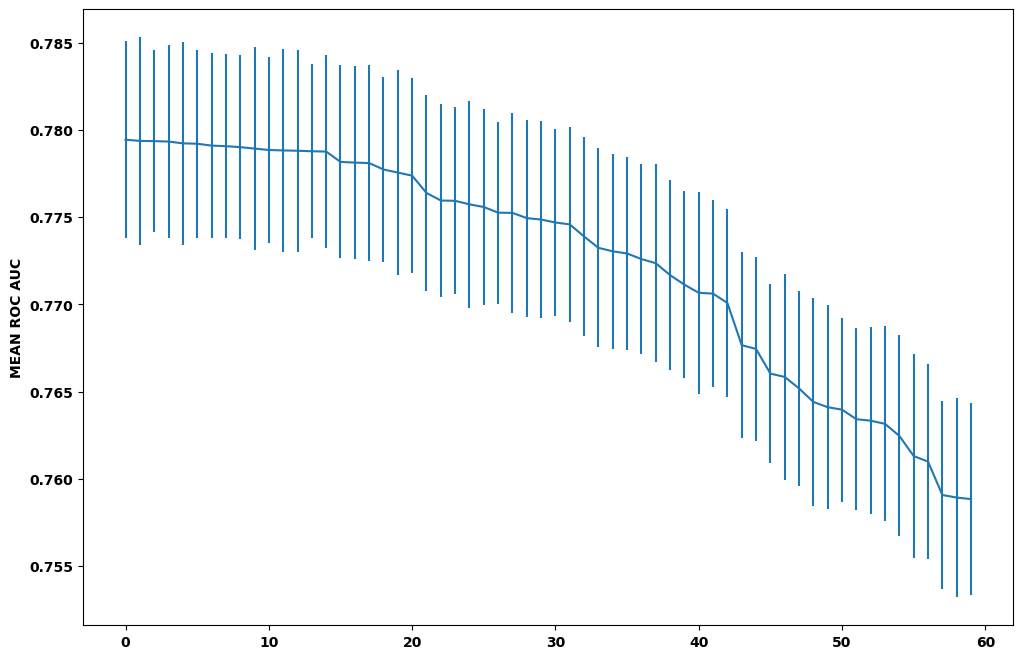

In [145]:
results.sort_values(by='mean_test_roc_auc', ascending=False, inplace=True)

results.reset_index(drop=True, inplace=True)

results['mean_test_roc_auc'].plot(yerr=[results['std_test_roc_auc'], results['std_test_roc_auc']], subplots=True)

plt.ylabel('MEAN ROC AUC', fontsize=10, weight='bold')

plt.xticks(fontsize=10, weight='bold')
plt.yticks(fontsize=10, weight='bold');

### 10.4.4 EVAL BEST XGB MODEL

In [146]:
xgb_result = cv_clf_metrics(model = search_xgb.best_estimator_, df= df10_xgb, target = 'pago', cv = kf, model_name='xgb', search=True)

TRAIN DATA
accuracy:          [0.718, 0.719, 0.719, 0.719, 0.718] / media: 0.719 / std: 0.0
balanced_accuracy: [0.727, 0.726, 0.726, 0.725, 0.724] / media: 0.726 / std: 0.001
roc_auc:           [0.801, 0.797, 0.798, 0.797, 0.797] / media: 0.798 / std: 0.002
f1_class_0:        [0.799, 0.8, 0.8, 0.801, 0.8] / media: 0.8 / std: 0.001
f1_class_1:        [0.529, 0.528, 0.528, 0.527, 0.526] / media: 0.528 / std: 0.001
precision_class_0: [0.911, 0.909, 0.91, 0.909, 0.908] / media: 0.909 / std: 0.001
precision_class_1: [0.411, 0.411, 0.411, 0.411, 0.41] / media: 0.411 / std: 0.0
recall_class_0 :   [0.712, 0.714, 0.713, 0.715, 0.714] / media: 0.714 / std: 0.001
recall_class_1 :   [0.741, 0.737, 0.738, 0.734, 0.733] / media: 0.737 / std: 0.003

---------------------------------------------------------------------------------------

TEST DATA
accuracy:          [0.72, 0.718, 0.719, 0.716, 0.72] / media: 0.719 / std: 0.001
balanced_accuracy: [0.72, 0.725, 0.723, 0.727, 0.731] / media: 0.725 / std:

Model Name    Accuracy CV Balanced Accuracy CV Roc Auc Score CV  \
0        xgb  0.719+/-0.001        0.725+/-0.004    0.798+/-0.005   

  Precision Class 0 CV Precision Class 1 CV Recall Class 0 CV  \
0        0.909+/-0.003        0.411+/-0.002     0.714+/-0.004   

  Recall Class 1 CV F1 Score Class 0 CV F1 Score Class 1 CV  
0     0.737+/-0.011         0.8+/-0.002       0.527+/-0.003

### 10.4.5 TEST SET METRICS

In [147]:
test_set = pd.read_csv(config['data']['test_path'])
test_set = test_set[df10_xgb.columns]
x_test = test_set.drop('pago', axis=1)
y_test = test_set['pago']

     Predito     0     1   All
Real                          
0             5506  2140  7646
1              573  1495  2068
All           6079  3635  9714



              precision    recall  f1-score   support

           0       0.91      0.72      0.80      7646
           1       0.41      0.72      0.52      2068

    accuracy                           0.72      9714
   macro avg       0.66      0.72      0.66      9714
weighted avg       0.80      0.72      0.74      9714



 ROC_AUC 0.79


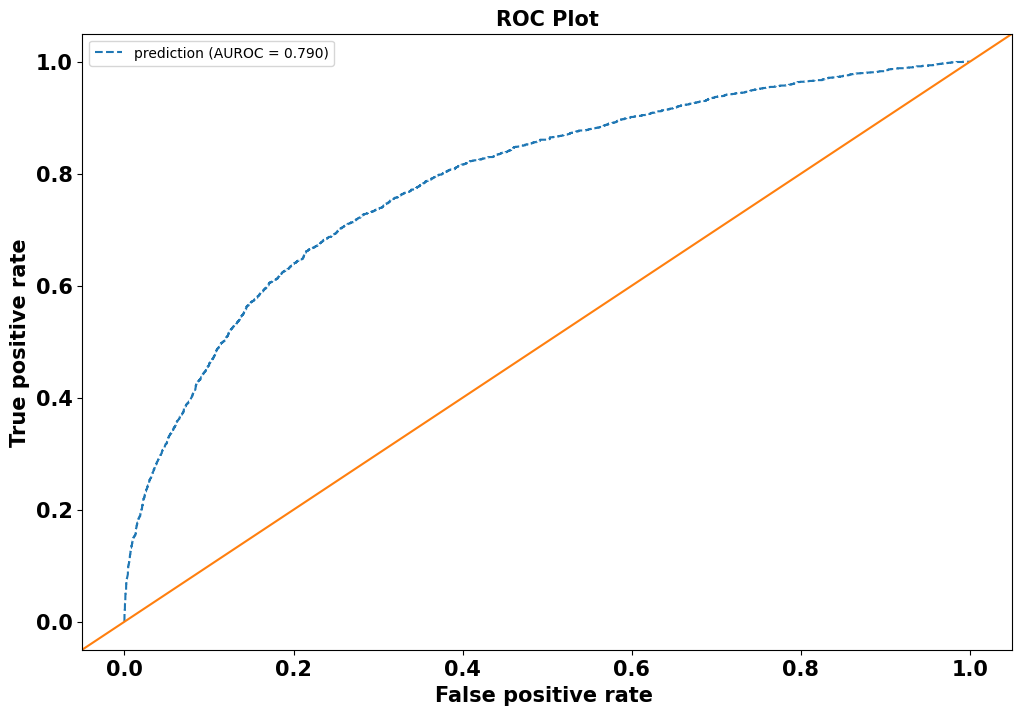

     Predito     0     1   All
Real                          
0             4977  2669  7646
1              459  1609  2068
All           5436  4278  9714



              precision    recall  f1-score   support

           0       0.92      0.65      0.76      7646
           1       0.38      0.78      0.51      2068

    accuracy                           0.68      9714
   macro avg       0.65      0.71      0.63      9714
weighted avg       0.80      0.68      0.71      9714





In [148]:
cm_roc_plot(search_xgb.best_estimator_, x_test, y_test, th=0.45)

# 11.0 COMPARE MODELS

In [149]:
test_set = pd.read_csv(config['data']['test_path'])
train_set = pd.read_csv(config['data']['train_path'])

columns_select = ['dependentes', 'estado_civil', 'cheque_sem_fundo', 'idade', 'valor_emprestimo', 'pago']


test_set = test_set[columns_select].copy()
train_set = train_set[columns_select].copy()


x_test = test_set.drop('pago', axis=1)
y_test = test_set['pago']

x_train = train_set.drop('pago', axis=1)
y_train = train_set['pago']

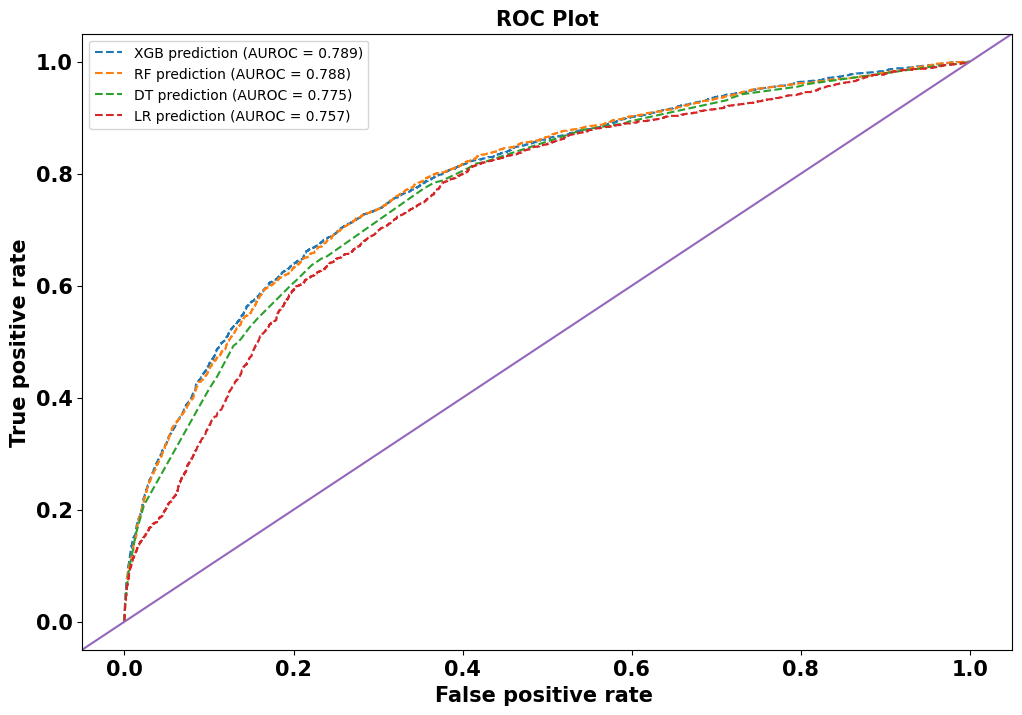

In [150]:
XGB_prob = search_xgb.best_estimator_.predict_proba(x_test)[:,1]
LR_prob  = search_lr.best_estimator_.predict_proba(x_test.drop('idade',axis=1))[:,1]
RF_prob  = search_rf.best_estimator_.predict_proba(x_test)[:,1]
DT_prob  = search_dt.best_estimator_.predict_proba(x_test.drop('idade',axis=1))[:,1]


XGB_auc = metrics.roc_auc_score(y_test,XGB_prob )
LR_auc  = metrics.roc_auc_score(y_test,LR_prob )
RF_auc  = metrics.roc_auc_score(y_test,RF_prob )
DT_auc  = metrics.roc_auc_score(y_test,DT_prob )

XGB_frp, XGB_tpr, _ = metrics.roc_curve(y_test, XGB_prob)
RF_frp, RF_tpr, _   = metrics.roc_curve(y_test, RF_prob)
DT_frp, DT_tpr, _   = metrics.roc_curve(y_test, DT_prob)
LR_frp, LR_tpr, _   = metrics.roc_curve(y_test, LR_prob)


fig, ax = plt.subplots(figsize=(12,8))

plt.plot(XGB_frp, XGB_tpr, linestyle='--', label = 'XGB prediction (AUROC = %0.3f)' % XGB_auc)
plt.plot(RF_frp, RF_tpr, linestyle='--', label = 'RF prediction (AUROC = %0.3f)' % RF_auc)
plt.plot(DT_frp, DT_tpr, linestyle='--', label = 'DT prediction (AUROC = %0.3f)' % DT_auc)
plt.plot(LR_frp, LR_tpr, linestyle='--', label = 'LR prediction (AUROC = %0.3f)' % LR_auc)
ax.plot([0,1],[0,1], transform=ax.transAxes)
#Title

plt.title('ROC Plot',fontsize=15, weight='bold')

#Axis labels

plt.xticks(fontsize=15, weight='bold')
plt.yticks(fontsize=15, weight='bold');

plt.ylabel('True positive rate',fontsize=15, weight='bold')
# recall class 1 = True positive rate (TP / (TP + FN)

plt.xlabel('False positive rate ',fontsize=15, weight='bold')
# recall class 0 = 1 - False positive rate (FP / (FP + TN)
plt.legend()

plt.show()

In [151]:
modelling_result = pd.concat([xgb_result, rf_result, dt_result, lr_result])
modelling_result

Model Name    Accuracy CV Balanced Accuracy CV Roc Auc Score CV  \
0        xgb  0.719+/-0.001        0.725+/-0.004    0.798+/-0.005   
0         rf  0.718+/-0.003        0.719+/-0.005    0.788+/-0.005   
0         dt  0.735+/-0.003        0.704+/-0.003    0.772+/-0.005   
0         lr  0.688+/-0.005        0.688+/-0.005    0.746+/-0.003   

  Precision Class 0 CV Precision Class 1 CV Recall Class 0 CV  \
0        0.909+/-0.003        0.411+/-0.002     0.714+/-0.004   
0        0.904+/-0.004        0.408+/-0.003     0.718+/-0.004   
0        0.889+/-0.002         0.42+/-0.003     0.757+/-0.005   
0         0.89+/-0.003        0.374+/-0.005     0.688+/-0.007   

  Recall Class 1 CV F1 Score Class 0 CV F1 Score Class 1 CV  
0     0.737+/-0.011         0.8+/-0.002       0.527+/-0.003  
0     0.719+/-0.014       0.801+/-0.002       0.521+/-0.006  
0     0.652+/-0.009       0.818+/-0.003       0.511+/-0.003  
0      0.687+/-0.01       0.776+/-0.004       0.484+/-0.006

In [152]:
result_xgb = test_metric(search_xgb.best_estimator_, x_test, y_test, 'xgb')
result_rf = test_metric(search_rf.best_estimator_, x_test, y_test, 'rf')
result_dt = test_metric(search_dt.best_estimator_, x_test.drop('idade', axis=1), y_test, 'dt')
result_lr = test_metric(search_lr.best_estimator_, x_test.drop('idade', axis=1), y_test, 'lr')

modelling_result_test = pd.concat([result_xgb , result_rf, result_dt, result_lr])

modelling_result_test

accuracy  balanced_accuracy  roc_auc  precision_0  precision_1  recall_0  \
0     0.721              0.722    0.789        0.906        0.411     0.720   
0     0.725              0.722    0.788        0.905        0.416     0.728   
0     0.738              0.706    0.775        0.890        0.425     0.762   
0     0.695              0.699    0.757        0.897        0.383     0.693   

   recall_1   f1_0   f1_1 model_name  
0     0.723  0.802  0.524        xgb  
0     0.716  0.807  0.526         rf  
0     0.651  0.821  0.514         dt  
0     0.705  0.782  0.496         lr

# 12.0 INTERPRETABILIDADE COM SHAP

## 12.1 XGBOOST

### 12.1.1 FIT AND PREDICT SHAP

In [153]:
test_set = pd.read_csv(config['data']['test_path'])
train_set = pd.read_csv(config['data']['train_path'])

columns_select = ['dependentes', 'estado_civil', 'cheque_sem_fundo', 'idade', 'valor_emprestimo', 'pago']


test_set = test_set[columns_select].copy()
train_set = train_set[columns_select].copy()


x_test = test_set.drop('pago', axis=1)
y_test = test_set['pago']

x_train = train_set.drop('pago', axis=1)
y_train = train_set['pago']

In [154]:
search_xgb.best_estimator_.named_steps

{'rare_encoder': RareLabelEncoder(n_categories=5, replace_with='outros',
                  variables=['estado_civil']),
 'categorical_encoder': MeanEncoder(variables=['dependentes', 'estado_civil', 'cheque_sem_fundo']),
 'classifier': XGBClassifier(alpha=0.3, base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.7, device=None, early_stopping_rounds=None,
               enable_categorical=False, eta=0.05, eval_metric=None,
               feature_types=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None, lambda=0.01,
               learning_rate=None, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
               max_leaves=None, min_child_weight=7, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=200, ...)}

In [155]:
search_xgb.best_estimator_.named_steps['categorical_encoder'].encoder_dict_

{'dependentes': {'N': 0.27695941077575853, 'S': 0.09762076423936554},
 'estado_civil': {'casado(a) com comunhao de bens': 0.23020046007229708,
  'casado(a) com comunhao parcial de bens': 0.389427647841795,
  'outros': 0.2820884699057288,
  'solteiro': 0.1143801811299056},
 'cheque_sem_fundo': {'N': 0.09684761579606237, 'S': 0.24686512556128387}}

In [156]:
x_test = search_xgb.best_estimator_.named_steps['rare_encoder'].transform(x_test)
x_test = search_xgb.best_estimator_.named_steps['categorical_encoder'].transform(x_test)


x_train = search_xgb.best_estimator_.named_steps['rare_encoder'].transform(x_train)
x_train = search_xgb.best_estimator_.named_steps['categorical_encoder'].transform(x_train)

In [157]:
xgb = search_xgb.best_estimator_.named_steps['classifier'].fit(x_train,y_train)

In [158]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer(x_test)

In [159]:
shap_values.values

array([[-0.24232697, -0.32321298, -0.5308712 ,  0.03758369, -0.6356644 ],
       [ 0.17006515,  0.06260312,  0.23117897, -0.01610757,  0.40284038],
       [-0.4587433 , -0.4546923 , -0.70891225, -0.04496556, -0.43833083],
       ...,
       [-0.39385763, -0.65594816,  0.11841336, -0.10133866, -0.18400659],
       [ 0.15820947,  0.7786164 ,  0.2654959 ,  0.20754755,  0.92682886],
       [ 0.22917937, -0.5870121 ,  0.18693592, -0.13481827, -0.31070206]],
      dtype=float32)

In [160]:
shap_values.base_values

array([0.10486235, 0.10486235, 0.10486235, ..., 0.10486235, 0.10486235,
       0.10486235], dtype=float32)

In [161]:
shap_values.data

array([[9.76207642e-02, 1.14380181e-01, 9.68476158e-02, 2.30000000e+01,
        3.45680000e+03],
       [2.76959411e-01, 2.30200460e-01, 2.46865126e-01, 3.50000000e+01,
        1.40150900e+04],
       [9.76207642e-02, 1.14380181e-01, 9.68476158e-02, 2.90000000e+01,
        6.57705000e+03],
       ...,
       [9.76207642e-02, 1.14380181e-01, 2.46865126e-01, 3.10000000e+01,
        1.68500000e+03],
       [2.76959411e-01, 3.89427648e-01, 2.46865126e-01, 3.70000000e+01,
        2.95841700e+04],
       [2.76959411e-01, 1.14380181e-01, 2.46865126e-01, 2.70000000e+01,
        1.01995200e+04]])

In [162]:
shap_values

.values =
array([[-0.24232697, -0.32321298, -0.5308712 ,  0.03758369, -0.6356644 ],
       [ 0.17006515,  0.06260312,  0.23117897, -0.01610757,  0.40284038],
       [-0.4587433 , -0.4546923 , -0.70891225, -0.04496556, -0.43833083],
       ...,
       [-0.39385763, -0.65594816,  0.11841336, -0.10133866, -0.18400659],
       [ 0.15820947,  0.7786164 ,  0.2654959 ,  0.20754755,  0.92682886],
       [ 0.22917937, -0.5870121 ,  0.18693592, -0.13481827, -0.31070206]],
      dtype=float32)

.base_values =
array([0.10486235, 0.10486235, 0.10486235, ..., 0.10486235, 0.10486235,
       0.10486235], dtype=float32)

.data =
array([[9.76207642e-02, 1.14380181e-01, 9.68476158e-02, 2.30000000e+01,
        3.45680000e+03],
       [2.76959411e-01, 2.30200460e-01, 2.46865126e-01, 3.50000000e+01,
        1.40150900e+04],
       [9.76207642e-02, 1.14380181e-01, 9.68476158e-02, 2.90000000e+01,
        6.57705000e+03],
       ...,
       [9.76207642e-02, 1.14380181e-01, 2.46865126e-01, 3.10000000e+01,
     

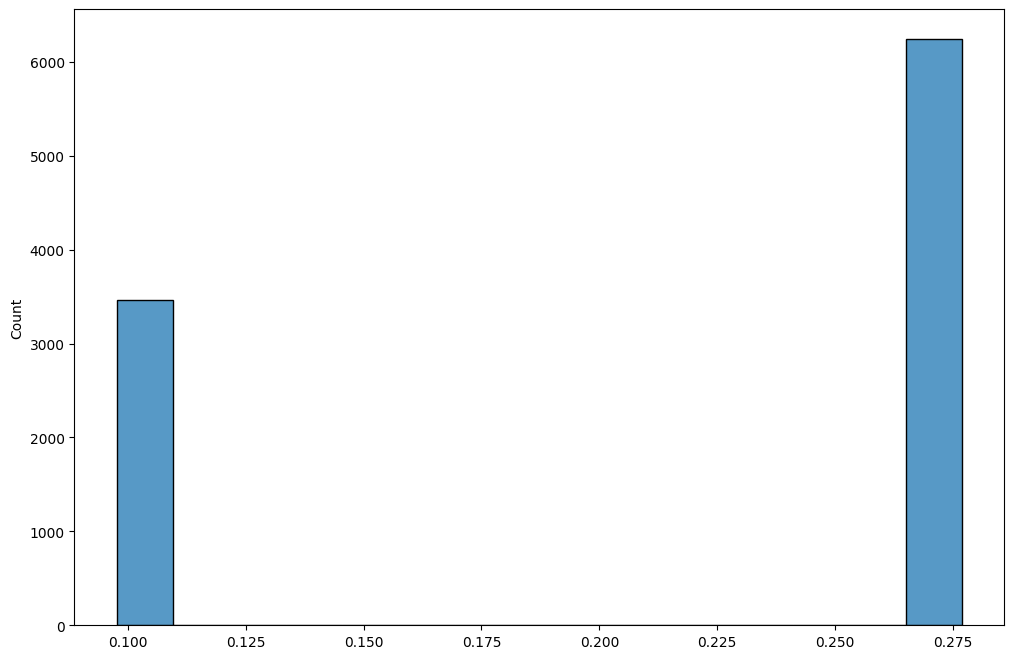

In [163]:
sns.histplot(shap_values.data[:,0]);

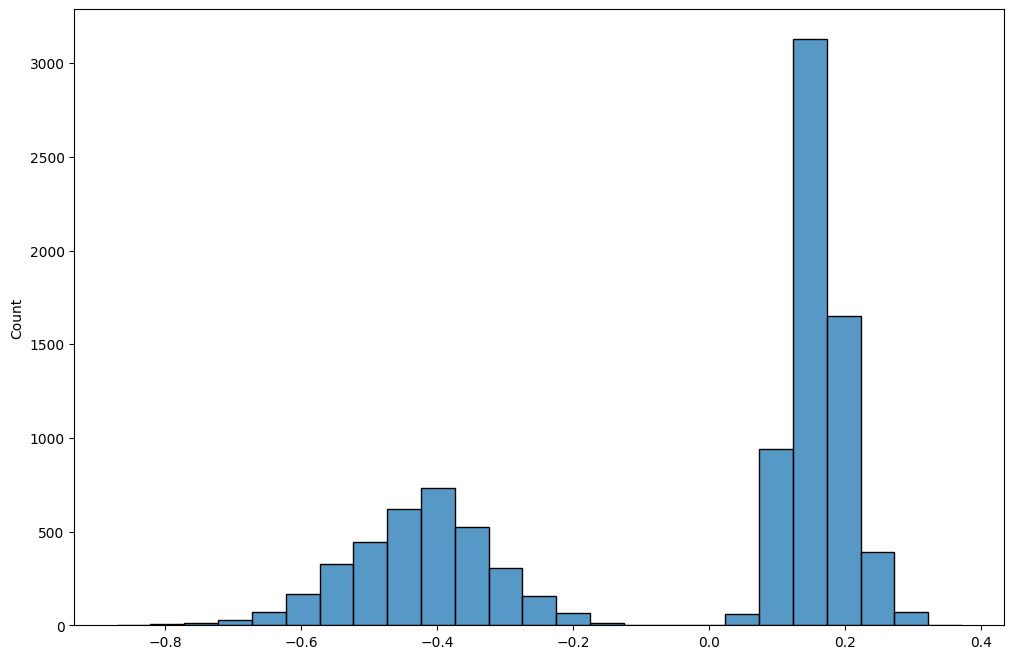

In [164]:
sns.histplot(shap_values.values[:,0]);

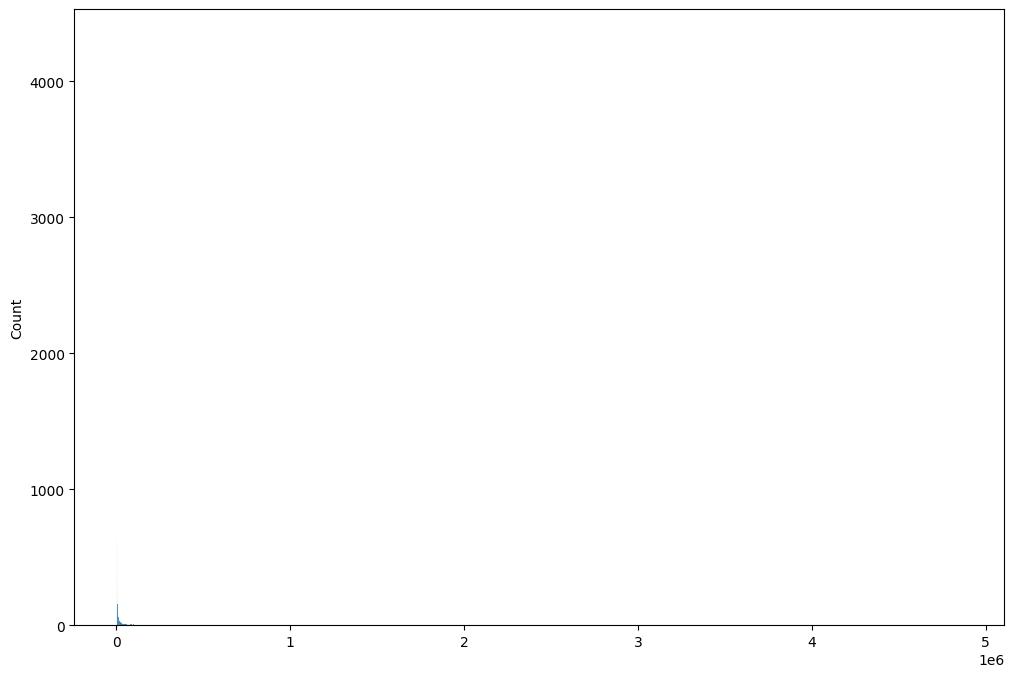

In [165]:
sns.histplot(shap_values.data[:,4]);

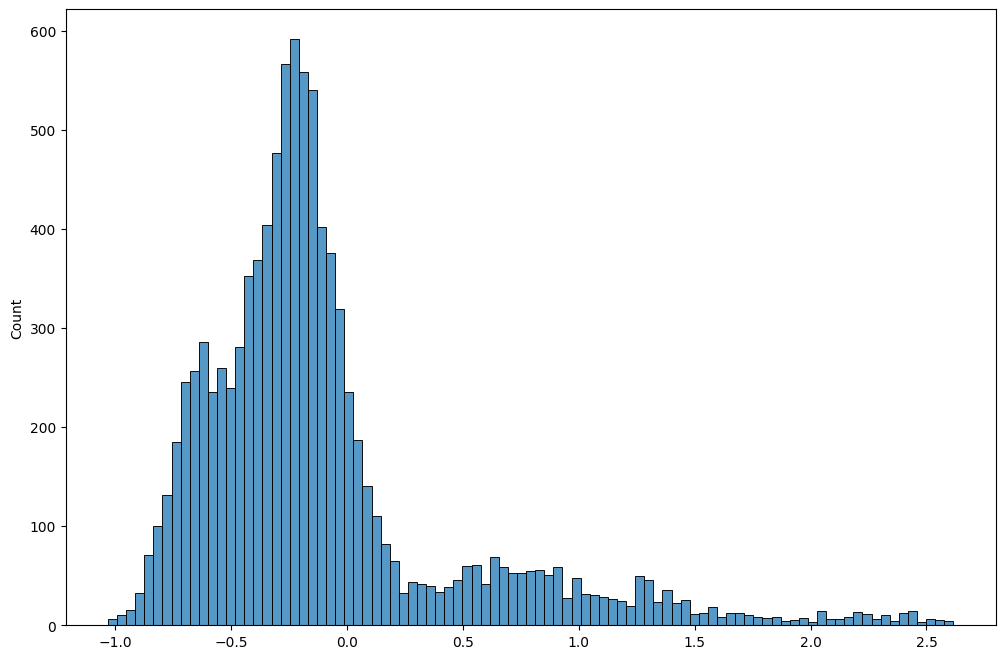

In [166]:
sns.histplot(shap_values.values[:,4]);

### 12.1.2 SUMMARY PLOT (RESUMO)

In [167]:
search_xgb.best_estimator_.named_steps['categorical_encoder'].encoder_dict_

{'dependentes': {'N': 0.27695941077575853, 'S': 0.09762076423936554},
 'estado_civil': {'casado(a) com comunhao de bens': 0.23020046007229708,
  'casado(a) com comunhao parcial de bens': 0.389427647841795,
  'outros': 0.2820884699057288,
  'solteiro': 0.1143801811299056},
 'cheque_sem_fundo': {'N': 0.09684761579606237, 'S': 0.24686512556128387}}

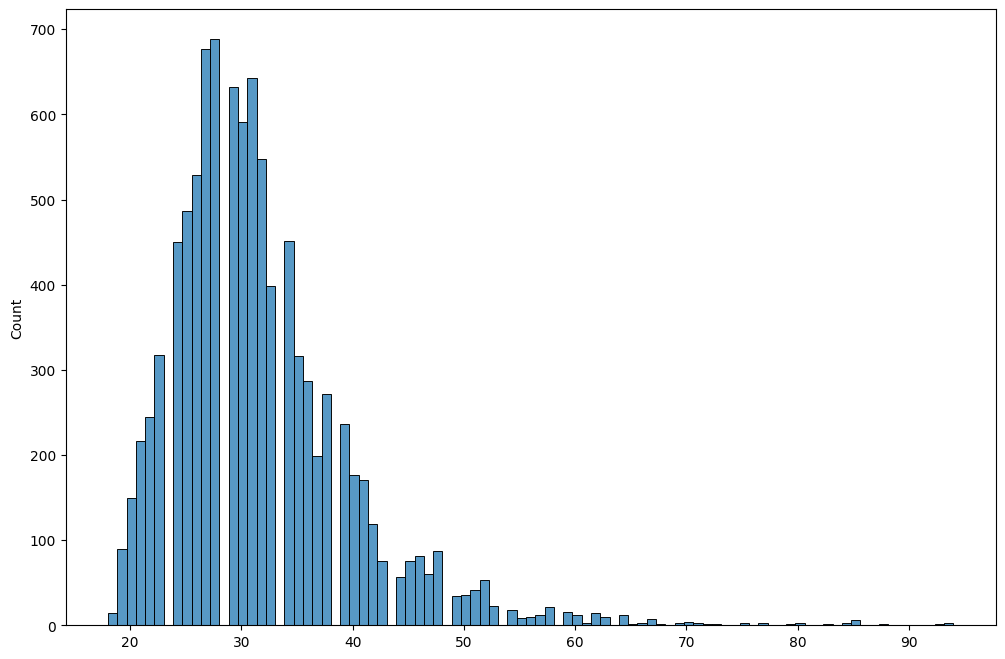

In [168]:
sns.histplot(shap_values.data[:,3]);

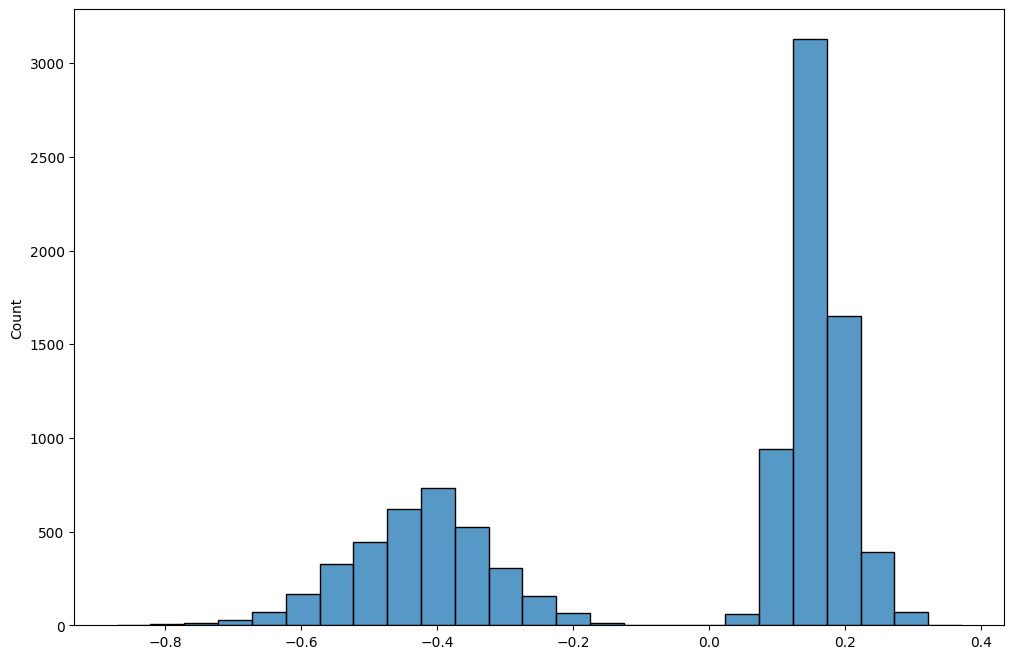

In [169]:
sns.histplot(shap_values.values[:,0]);

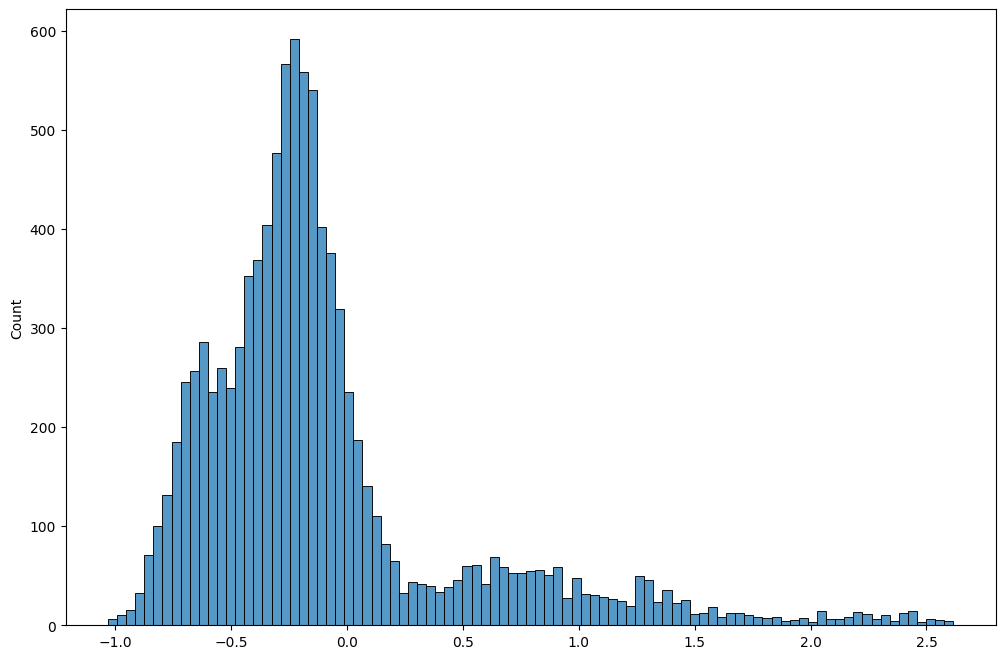

In [170]:
sns.histplot(shap_values.values[:,4]);

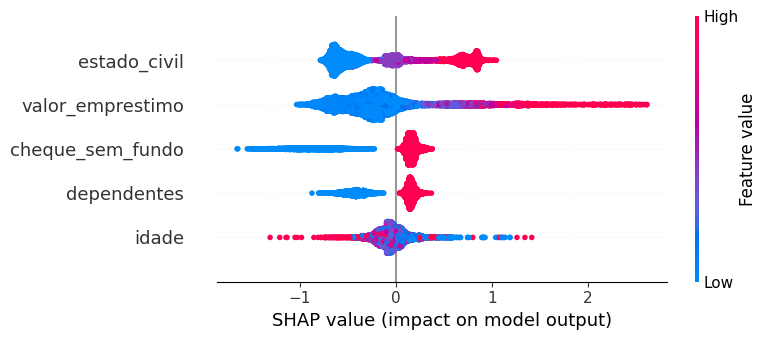

In [171]:
shap.summary_plot(shap_values, x_test)

### 12.1.3 WATERFALL (CONTRIBUICOES INDIVIDUAIS)

In [172]:
x_test.head()

dependentes  estado_civil  cheque_sem_fundo  idade  valor_emprestimo
0     0.097621       0.11438          0.096848     23           3456.80
1     0.276959       0.23020          0.246865     35          14015.09
2     0.097621       0.11438          0.096848     29           6577.05
3     0.097621       0.11438          0.096848     31          44760.10
4     0.276959       0.11438          0.096848     33          36560.00

In [173]:
test_set.head()

dependentes                    estado_civil cheque_sem_fundo  idade  \
0           S                        solteiro                N     23   
1           N  casado(a) com comunhao de bens                S     35   
2           S                        solteiro                N     29   
3           S                        solteiro                N     31   
4           N                        solteiro                N     33   

   valor_emprestimo  pago  
0           3456.80     0  
1          14015.09     0  
2           6577.05     0  
3          44760.10     0  
4          36560.00     0

In [174]:
search_xgb.best_estimator_.named_steps['categorical_encoder'].encoder_dict_

{'dependentes': {'N': 0.27695941077575853, 'S': 0.09762076423936554},
 'estado_civil': {'casado(a) com comunhao de bens': 0.23020046007229708,
  'casado(a) com comunhao parcial de bens': 0.389427647841795,
  'outros': 0.2820884699057288,
  'solteiro': 0.1143801811299056},
 'cheque_sem_fundo': {'N': 0.09684761579606237, 'S': 0.24686512556128387}}

In [175]:
shap_values[1]

.values =
array([ 0.17006515,  0.06260312,  0.23117897, -0.01610757,  0.40284038],
      dtype=float32)

.base_values =
0.10486235

.data =
array([2.76959411e-01, 2.30200460e-01, 2.46865126e-01, 3.50000000e+01,
       1.40150900e+04])

In [176]:
test_set.head()

dependentes                    estado_civil cheque_sem_fundo  idade  \
0           S                        solteiro                N     23   
1           N  casado(a) com comunhao de bens                S     35   
2           S                        solteiro                N     29   
3           S                        solteiro                N     31   
4           N                        solteiro                N     33   

   valor_emprestimo  pago  
0           3456.80     0  
1          14015.09     0  
2           6577.05     0  
3          44760.10     0  
4          36560.00     0

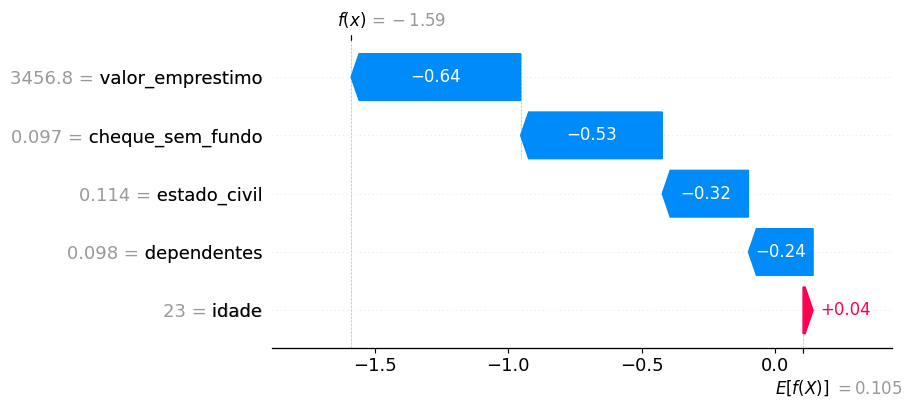

In [177]:
shap.plots.waterfall(shap_values[0])

In [178]:
test_set.head(20)

dependentes                            estado_civil cheque_sem_fundo  \
0            S                                solteiro                N   
1            N          casado(a) com comunhao de bens                S   
2            S                                solteiro                N   
3            S                                solteiro                N   
4            N                                solteiro                N   
5            S                                solteiro                N   
6            S                                solteiro                S   
7            N          casado(a) com comunhao de bens                N   
8            S                                solteiro                N   
9            N          casado(a) com comunhao de bens                S   
10           S                                solteiro                N   
11           N                                solteiro                N   
12           S                                solteiro                S   
13           N                                solteiro                N   
14           N  casado(a) com comunhao parcial de bens                S   
15           S                                solteiro                S   
16           N                                solteiro                S   
17           S                                solteiro                S   
18           N                                solteiro                N   
19           S                                solteiro                S   

    idade  valor_emprestimo  pago  
0      23           3456.80     0  
1      35          14015.09     0  
2      29           6577.05     0  
3      31          44760.10     0  
4      33          36560.00     0  
5      29          27055.30     0  
6      31           1642.00     1  
7      28           1763.00     0  
8      32           1571.00     0  
9      21         324743.40     1  
10     44           1729.08     0  
11     38          72090.45     0  
12     24           4537.72     0  
13     36           2269.82     0  
14     38           1582.00     0  
15     24           3331.13     0  
16     45           2084.68     0  
17     28           1699.00     0  
18     31           1518.00     0  
19     25           3700.67     0

In [179]:
shap_values

.values =
array([[-0.24232697, -0.32321298, -0.5308712 ,  0.03758369, -0.6356644 ],
       [ 0.17006515,  0.06260312,  0.23117897, -0.01610757,  0.40284038],
       [-0.4587433 , -0.4546923 , -0.70891225, -0.04496556, -0.43833083],
       ...,
       [-0.39385763, -0.65594816,  0.11841336, -0.10133866, -0.18400659],
       [ 0.15820947,  0.7786164 ,  0.2654959 ,  0.20754755,  0.92682886],
       [ 0.22917937, -0.5870121 ,  0.18693592, -0.13481827, -0.31070206]],
      dtype=float32)

.base_values =
array([0.10486235, 0.10486235, 0.10486235, ..., 0.10486235, 0.10486235,
       0.10486235], dtype=float32)

.data =
array([[9.76207642e-02, 1.14380181e-01, 9.68476158e-02, 2.30000000e+01,
        3.45680000e+03],
       [2.76959411e-01, 2.30200460e-01, 2.46865126e-01, 3.50000000e+01,
        1.40150900e+04],
       [9.76207642e-02, 1.14380181e-01, 9.68476158e-02, 2.90000000e+01,
        6.57705000e+03],
       ...,
       [9.76207642e-02, 1.14380181e-01, 2.46865126e-01, 3.10000000e+01,
     

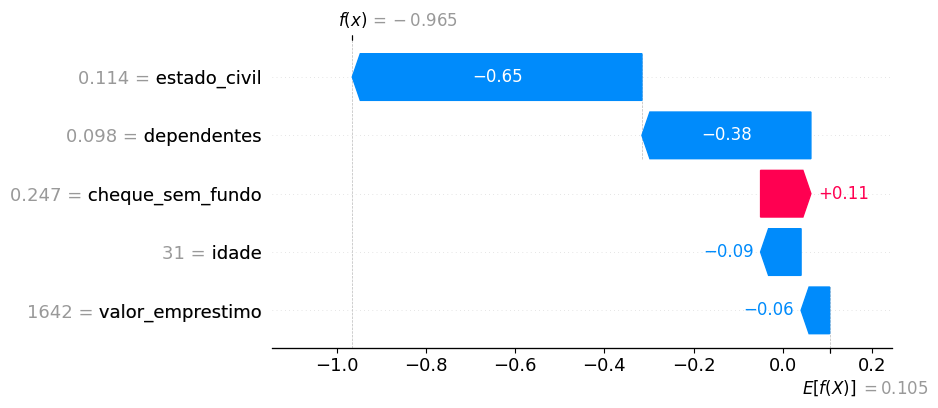

In [180]:
shap.plots.waterfall(shap_values[6])

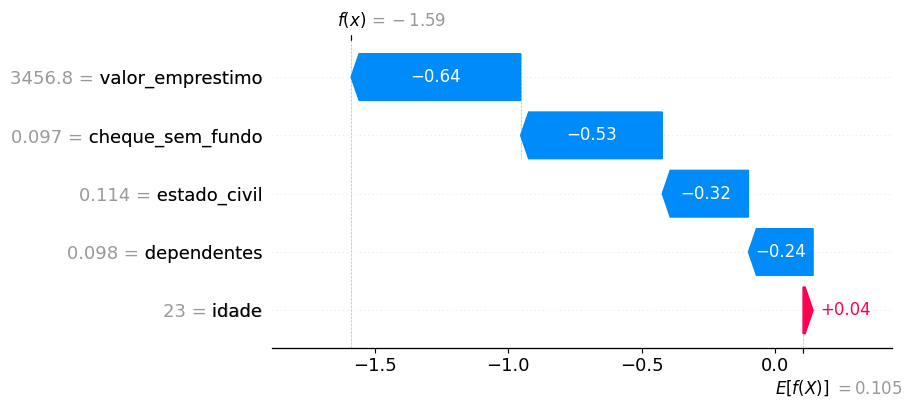

In [181]:
shap.plots.waterfall(shap_values[0])

In [182]:
shap.initjs()
shap.force_plot(shap_values[0])

### 12.1.4 EDA

#### 12.1.4.1 VALOR DO EMPRESTIMO

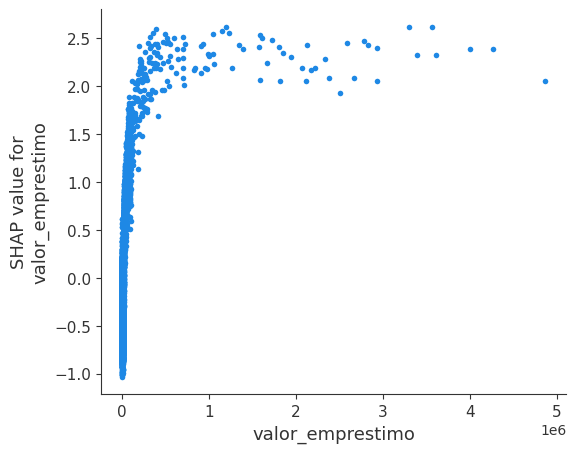

In [183]:
shap.dependence_plot('valor_emprestimo', shap_values.values, x_test, interaction_index=None)

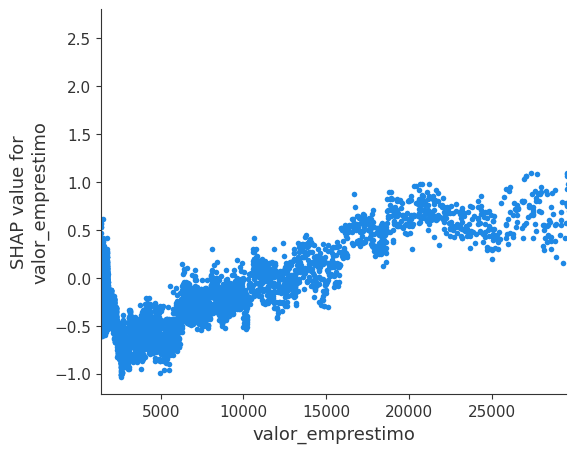

In [184]:
shap.dependence_plot('valor_emprestimo', shap_values.values, x_test, interaction_index=None, xmin='percentile(1)', xmax="percentile(90)")

In [185]:
df_shap_xgb = pd.DataFrame(shap_values.values, columns=x_test.columns)
df_shap_xgb = df_shap_xgb.add_suffix('_shap')

In [186]:
test_set_shap = pd.concat([test_set, df_shap_xgb], axis=1)

In [187]:
test_set_shap[(test_set_shap['valor_emprestimo_shap']>0) & (test_set_shap['valor_emprestimo_shap']<0.01) & (test_set_shap['valor_emprestimo']>10000)].sort_values('valor_emprestimo', ascending=False)

dependentes                            estado_civil cheque_sem_fundo  \
2459           S                                solteiro                S   
2937           N  casado(a) com comunhao parcial de bens                S   
1022           N  casado(a) com comunhao parcial de bens                S   
4383           S                                solteiro                S   
1162           N                                solteiro                S   
6837           N                                solteiro                N   
8194           S                                solteiro                S   
4709           S                                solteiro                S   
6841           N          casado(a) com comunhao de bens                S   
7782           S                                solteiro                S   
1190           S                                solteiro                S   

      idade  valor_emprestimo  pago  dependentes_shap  estado_civil_shap  \
2459     24          12913.26     0         -0.469045          -0.575371   
2937     30          12239.70     0          0.179075           0.729464   
1022     30          12088.62     1          0.179075           0.729464   
4383     31          11830.58     0         -0.560848          -0.647938   
1162     21          11687.52     0          0.216849          -0.654746   
6837     37          11653.05     0          0.204918          -0.528286   
8194     29          11555.99     0         -0.464233          -0.652189   
4709     23          11465.78     0         -0.415513          -0.562066   
6841     20          11238.63     1          0.152713           0.031905   
7782     27          10957.44     0         -0.503734          -0.611918   
1190     27          10928.21     0         -0.503734          -0.611918   

      cheque_sem_fundo_shap  idade_shap  valor_emprestimo_shap  
2459               0.169658    0.004234               0.001655  
2937               0.228626   -0.066981               0.005979  
1022               0.228626   -0.066981               0.005979  
4383               0.172085   -0.030616               0.005958  
1162               0.226716   -0.000225               0.006176  
6837              -0.993908   -0.033477               0.000564  
8194               0.178415   -0.021981               0.005867  
4709               0.158251   -0.063081               0.006196  
6841               0.237882    0.139244               0.001947  
7782               0.180711   -0.054912               0.008737  
1190               0.180711   -0.054912               0.008737

In [188]:
test_set_shap[(test_set_shap['valor_emprestimo_shap']>0) & (test_set_shap['valor_emprestimo_shap']<0.01) & (test_set_shap['valor_emprestimo']>10000)].sort_values('valor_emprestimo', ascending=False)['valor_emprestimo'].median()

11653.05

#### 12.1.4.2 IDADE

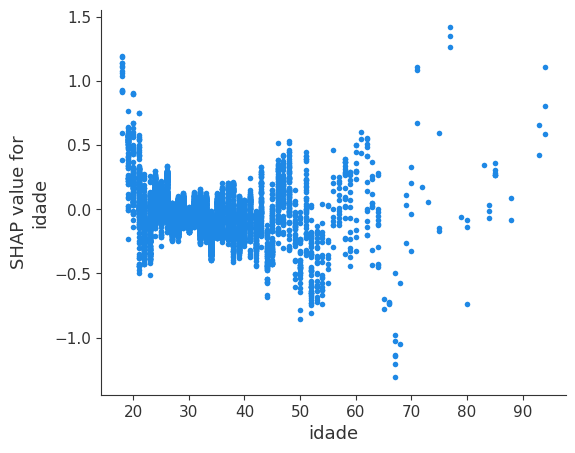

In [189]:
shap.dependence_plot('idade', shap_values.values, x_test, interaction_index=None)

#### 12.1.4.3 ESTADO CIVIL

In [190]:
search_xgb.best_estimator_.named_steps['categorical_encoder'].encoder_dict_

{'dependentes': {'N': 0.27695941077575853, 'S': 0.09762076423936554},
 'estado_civil': {'casado(a) com comunhao de bens': 0.23020046007229708,
  'casado(a) com comunhao parcial de bens': 0.389427647841795,
  'outros': 0.2820884699057288,
  'solteiro': 0.1143801811299056},
 'cheque_sem_fundo': {'N': 0.09684761579606237, 'S': 0.24686512556128387}}

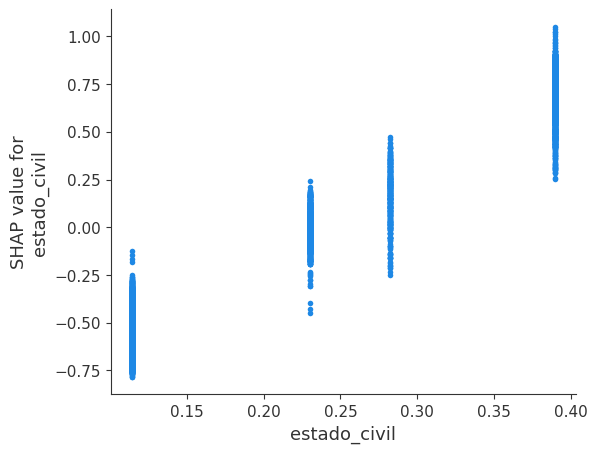

In [191]:
shap.dependence_plot('estado_civil', shap_values.values, x_test, interaction_index=None)

#### 12.1.4.4 CHEQUE SEM FUNDO

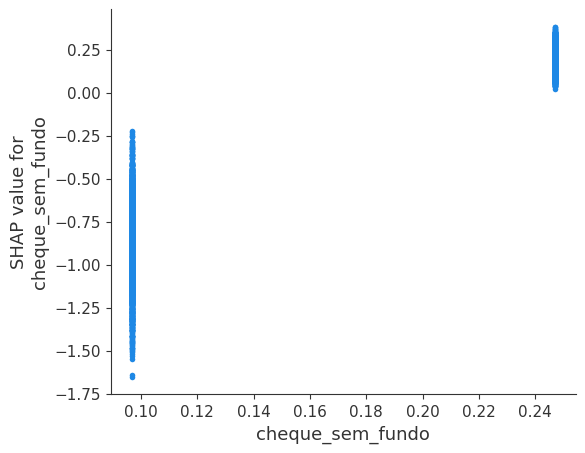

In [192]:
shap.dependence_plot('cheque_sem_fundo', shap_values.values, x_test, interaction_index=None)

#### 12.1.4.5 DEPENDENTES

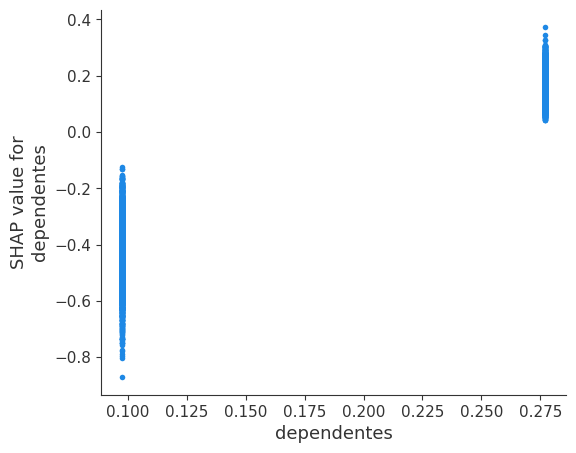

In [193]:
shap.dependence_plot('dependentes', shap_values.values, x_test, interaction_index=None)

#### 12.1.4.5 VALOR DO EMPRESTIMO X IDADE

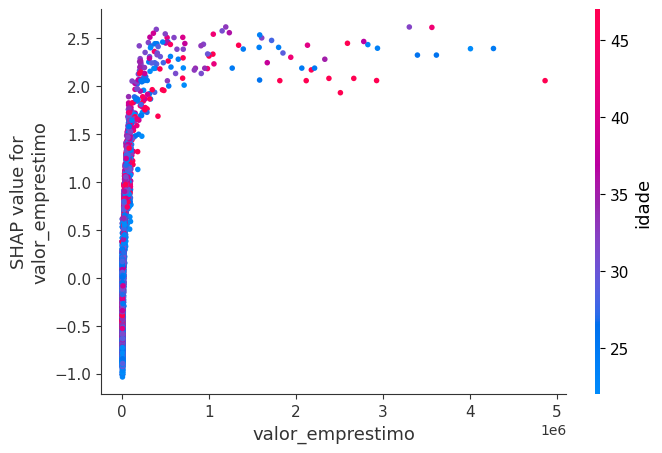

In [194]:
shap.dependence_plot('valor_emprestimo', shap_values.values, x_test, interaction_index='idade')

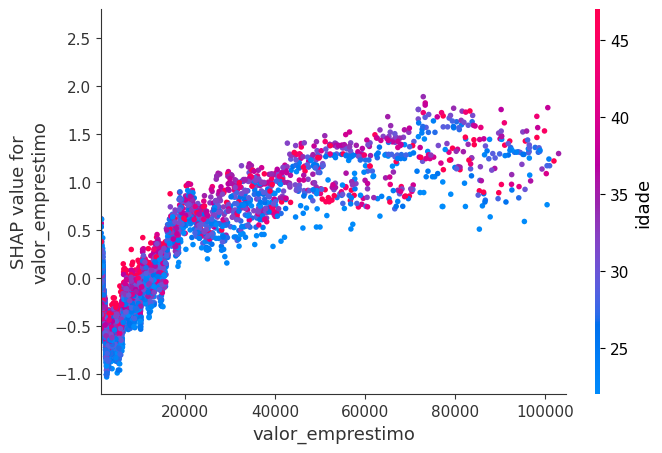

In [195]:
shap.dependence_plot('valor_emprestimo', shap_values.values, x_test, interaction_index='idade', xmin='percentile(1)', xmax="percentile(98)" )

#### 12.1.4.6 VALOR DO EMPRESTIMO X cheque_sem_fundo

In [196]:
search_xgb.best_estimator_.named_steps['categorical_encoder'].encoder_dict_

{'dependentes': {'N': 0.27695941077575853, 'S': 0.09762076423936554},
 'estado_civil': {'casado(a) com comunhao de bens': 0.23020046007229708,
  'casado(a) com comunhao parcial de bens': 0.389427647841795,
  'outros': 0.2820884699057288,
  'solteiro': 0.1143801811299056},
 'cheque_sem_fundo': {'N': 0.09684761579606237, 'S': 0.24686512556128387}}

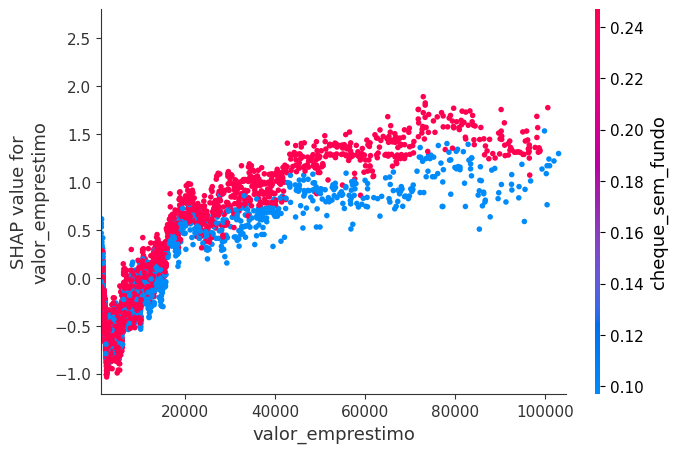

In [197]:
shap.dependence_plot('valor_emprestimo', shap_values.values, x_test, interaction_index='cheque_sem_fundo', xmin='percentile(1)', xmax="percentile(98)" )

#### 12.1.5 Perfil Adimplente e Inadimplente (clustering Shap)

In [198]:
test_set = pd.read_csv(config['data']['test_path'])
train_set = pd.read_csv(config['data']['train_path'])

columns_select = ['dependentes', 'estado_civil', 'cheque_sem_fundo', 'idade', 'valor_emprestimo', 'pago']


test_set = test_set[columns_select].copy()
train_set = train_set[columns_select].copy()


x_test = test_set.drop('pago', axis=1)
y_test = test_set['pago']

x_train = train_set.drop('pago', axis=1)
y_train = train_set['pago']

In [199]:
test_set['pago'] = test_set['pago'].apply(lambda x: 'inadimplente' if x==1 else 'adimplente')
test_set['dependentes'] = test_set['dependentes'].apply(lambda x: 'dependentes_sim' if x == 'S' else 'depedentes_nao')
test_set['cheque_sem_fundo'] = test_set['cheque_sem_fundo'].apply(lambda x: 'cheque_sim' if x == 'S' else 'cheque_nao')

In [200]:
ce_rare = RareLabelEncoder(n_categories=5, tol=0.05, variables=['estado_civil'], replace_with='outros')

ce_rare.fit(test_set)

test_set = ce_rare.transform(test_set)


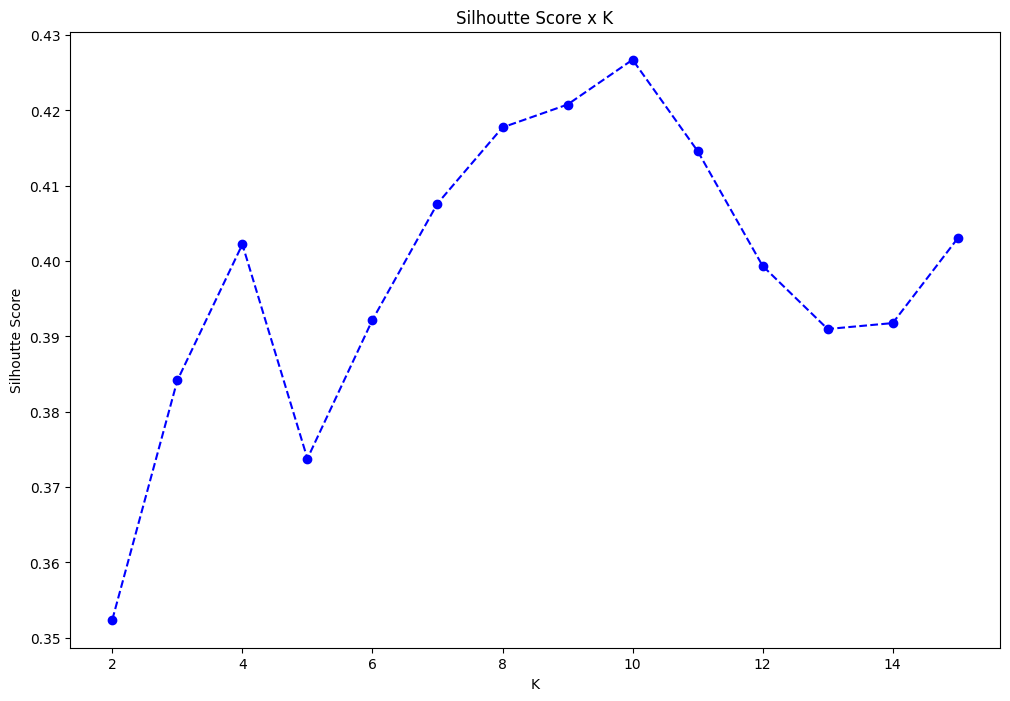

In [201]:
silhouette_score(df_shap_xgb, 'kmeans', 2, 15)

In [202]:
cluster_model = KMeans(n_clusters=10, random_state=config['split']['seed'])
cluster_model.fit(df_shap_xgb)
labels = cluster_model.predict(df_shap_xgb)

In [203]:
test_set['cluster'] = labels

In [204]:
test_set.head()

dependentes                    estado_civil cheque_sem_fundo  idade  \
0  dependentes_sim                        solteiro       cheque_nao     23   
1   depedentes_nao  casado(a) com comunhao de bens       cheque_sim     35   
2  dependentes_sim                        solteiro       cheque_nao     29   
3  dependentes_sim                        solteiro       cheque_nao     31   
4   depedentes_nao                        solteiro       cheque_nao     33   

   valor_emprestimo        pago  cluster  
0           3456.80  adimplente        1  
1          14015.09  adimplente        3  
2           6577.05  adimplente        1  
3          44760.10  adimplente        4  
4          36560.00  adimplente        4

In [205]:
test_set['pago'].value_counts(normalize=True)

pago
adimplente      0.787111
inadimplente    0.212889
Name: proportion, dtype: float64

In [206]:
test_set['cluster'] = labels
tabela_resultado_final(test_set)

## 12.2 LOGISTIC REGRESSION

### 12.2.1 FIT AND PREDICT SHAP

In [207]:
test_set = pd.read_csv(config['data']['test_path'])
train_set = pd.read_csv(config['data']['train_path'])

columns_select = ['dependentes', 'estado_civil', 'cheque_sem_fundo','valor_emprestimo', 'pago']


test_set = test_set[columns_select].copy()
train_set = train_set[columns_select].copy()


x_test = test_set.drop('pago', axis=1)
y_test = test_set['pago']

x_train = train_set.drop('pago', axis=1)
y_train = train_set['pago']

In [208]:
search_lr.best_estimator_.named_steps

{'rare_label': RareLabelEncoder(n_categories=5, replace_with='outros',
                  variables=['estado_civil']),
 'preprocessor': ColumnTransformer(transformers=[('onehot_encoder',
                                  OneHotEncoder(drop_last=True),
                                  ['dependentes', 'cheque_sem_fundo',
                                   'estado_civil']),
                                 ('target_encoder', MeanEncoder(), []),
                                 ('std_scaler', StandardScaler(), []),
                                 ('yj_scaler', PowerTransformer(),
                                  ['valor_emprestimo'])]),
 'classifier': LogisticRegression(C=0.1, class_weight='balanced', n_jobs=-1, random_state=42,
                    solver='liblinear')}

In [209]:
p1 = search_lr.best_estimator_.named_steps['rare_label'].transform(x_test)
p2 = search_lr.best_estimator_.named_steps['preprocessor'].transform(p1)

In [210]:
pd.DataFrame(p2)

0    1    2    3    4         5
0     0.0  1.0  1.0  0.0  0.0  0.204404
1     1.0  0.0  0.0  1.0  0.0  1.266213
2     0.0  1.0  1.0  0.0  0.0  0.810332
3     0.0  1.0  1.0  0.0  0.0  1.649189
4     1.0  1.0  1.0  0.0  0.0  1.601223
...   ...  ...  ...  ...  ...       ...
9709  0.0  0.0  1.0  0.0  0.0  0.539143
9710  1.0  0.0  1.0  0.0  0.0 -1.074833
9711  0.0  0.0  1.0  0.0  0.0 -0.845429
9712  1.0  0.0  0.0  0.0  1.0  1.543898
9713  1.0  0.0  1.0  0.0  0.0  1.101224

[9714 rows x 6 columns]

In [211]:
yj = PowerTransformer(method='yeo-johnson', standardize=True)
yj.fit(x_train[['valor_emprestimo']].values)
x_train['valor_emprestimo'] = yj.transform(x_train[['valor_emprestimo']].values)

x_test['valor_emprestimo'] = yj.transform(x_test[['valor_emprestimo']].values)


ce_rare = RareLabelEncoder( n_categories=5, tol=0.05, variables=['estado_civil'],
                           replace_with='outros')
ce_rare.fit(x_train)
x_train = ce_rare.transform(x_train)

x_test = ce_rare.transform(x_test)

ce_OHE = OneHotEncoder(variables=['dependentes', 'estado_civil', 'cheque_sem_fundo'], drop_last=True).fit(x_train)

x_train = ce_OHE.transform(x_train)

x_test = ce_OHE.transform(x_test)

lr = search_lr.best_estimator_.named_steps['classifier'].fit(x_train,y_train)

In [212]:
x_test

valor_emprestimo  dependentes_N  estado_civil_solteiro  \
0             0.204404              0                      1   
1             1.266213              1                      0   
2             0.810332              0                      1   
3             1.649189              0                      1   
4             1.601223              1                      1   
...                ...            ...                    ...   
9709          0.539143              0                      1   
9710         -1.074833              1                      1   
9711         -0.845429              0                      1   
9712          1.543898              1                      0   
9713          1.101224              1                      1   

      estado_civil_casado(a) com comunhao de bens  \
0                                               0   
1                                               1   
2                                               0   
3                                               0   
4                                               0   
...                                           ...   
9709                                            0   
9710                                            0   
9711                                            0   
9712                                            0   
9713                                            0   

      estado_civil_casado(a) com comunhao parcial de bens  cheque_sem_fundo_N  
0                                                     0                     1  
1                                                     0                     0  
2                                                     0                     1  
3                                                     0                     1  
4                                                     0                     1  
...                                                 ...                   ...  
9709                                                  0                     0  
9710                                                  0                     0  
9711                                                  0                     0  
9712                                                  1                     0  
9713                                                  0                     0  

[9714 rows x 6 columns]

In [213]:
masker = shap.maskers.Partition(data = x_train)
explainer = shap.LinearExplainer(lr, masker = masker)
shap_values = explainer(x_test)

In [214]:
shap_values

.values =
array([[ 0.05308233, -0.48850277, -0.23377455,  0.01990226, -0.11851998,
        -0.74869654],
       [ 0.43012237,  0.27478281,  0.45379766, -0.20123393, -0.11851998,
         0.23643049],
       [ 0.26824257, -0.48850277, -0.23377455,  0.01990226, -0.11851998,
        -0.74869654],
       ...,
       [-0.31970515, -0.48850277, -0.23377455,  0.01990226, -0.11851998,
         0.23643049],
       [ 0.52872637,  0.27478281,  0.45379766,  0.01990226,  0.39678429,
         0.23643049],
       [ 0.3715362 ,  0.27478281, -0.23377455,  0.01990226, -0.11851998,
         0.23643049]])

.base_values =
array([-0.32888015, -0.32888015, -0.32888015, ..., -0.32888015,
       -0.32888015, -0.32888015])

.data =
array([[ 0.20440383,  0.        ,  1.        ,  0.        ,  0.        ,
         1.        ],
       [ 1.26621266,  1.        ,  0.        ,  1.        ,  0.        ,
         0.        ],
       [ 0.81033163,  0.        ,  1.        ,  0.        ,  0.        ,
         1.        ],

### 12.2.2 SUMMARY PLOT (RESUMO)

In [215]:
x_test.head()

valor_emprestimo  dependentes_N  estado_civil_solteiro  \
0          0.204404              0                      1   
1          1.266213              1                      0   
2          0.810332              0                      1   
3          1.649189              0                      1   
4          1.601223              1                      1   

   estado_civil_casado(a) com comunhao de bens  \
0                                            0   
1                                            1   
2                                            0   
3                                            0   
4                                            0   

   estado_civil_casado(a) com comunhao parcial de bens  cheque_sem_fundo_N  
0                                                  0                     1  
1                                                  0                     0  
2                                                  0                     1  
3                                                  0                     1  
4                                                  0                     1

In [216]:
test_set.head()

dependentes                    estado_civil cheque_sem_fundo  \
0           S                        solteiro                N   
1           N  casado(a) com comunhao de bens                S   
2           S                        solteiro                N   
3           S                        solteiro                N   
4           N                        solteiro                N   

   valor_emprestimo  pago  
0           3456.80     0  
1          14015.09     0  
2           6577.05     0  
3          44760.10     0  
4          36560.00     0

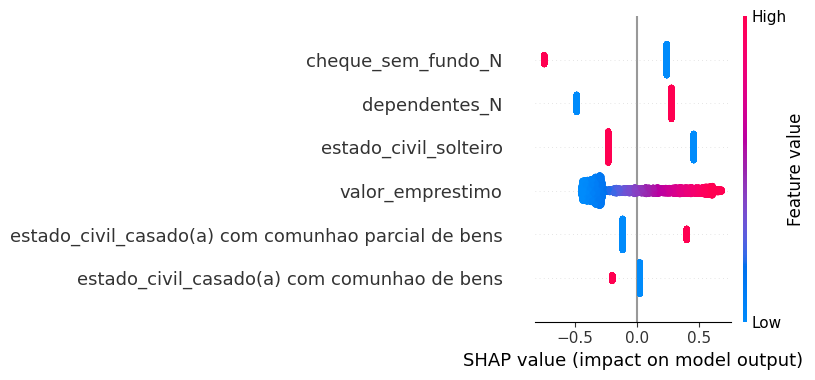

In [217]:
shap.summary_plot(shap_values,x_test)

### 12.2.3 WATERFALL (CONTRIBUICOES INDIVIDUAIS)

In [218]:
test_set.head()

dependentes                    estado_civil cheque_sem_fundo  \
0           S                        solteiro                N   
1           N  casado(a) com comunhao de bens                S   
2           S                        solteiro                N   
3           S                        solteiro                N   
4           N                        solteiro                N   

   valor_emprestimo  pago  
0           3456.80     0  
1          14015.09     0  
2           6577.05     0  
3          44760.10     0  
4          36560.00     0

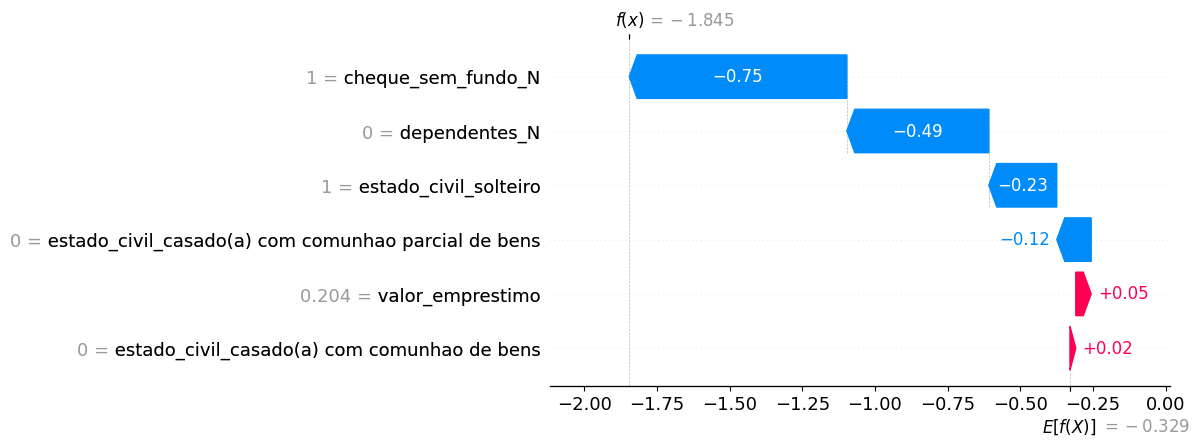

In [219]:
shap.plots.waterfall(shap_values[0])

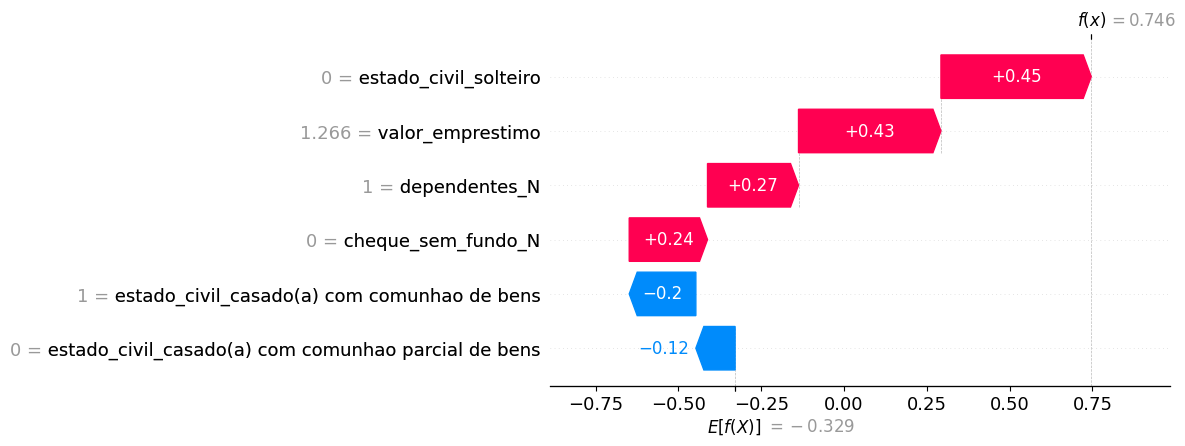

In [220]:
shap.plots.waterfall(shap_values[1])

In [221]:
shap.initjs()
shap.force_plot(shap_values[0])

### 12.2.4 EDA

#### 12.2.4.1 VALOR DO EMPRESTIMO

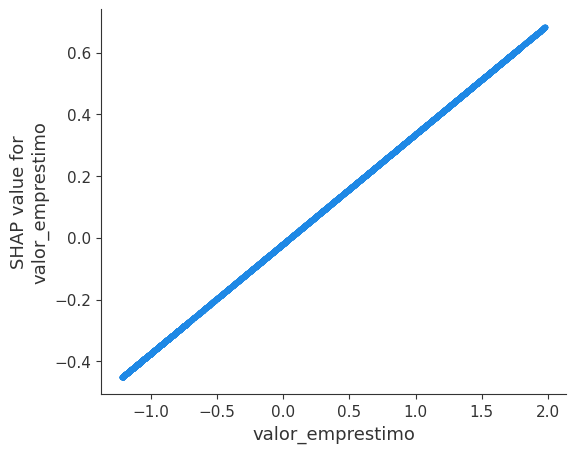

In [222]:
shap.dependence_plot('valor_emprestimo', shap_values.values, x_test, interaction_index=None)

In [223]:
df_shap_lr = pd.DataFrame(shap_values.values, columns=x_test.columns)
df_shap_lr = df_shap_lr.add_suffix('_shap')

test_set_shap = pd.concat([test_set, df_shap_lr], axis=1)

In [224]:
test_set_shap[(test_set_shap['valor_emprestimo_shap']>0) & (test_set_shap['valor_emprestimo_shap']<0.01)].sort_values('valor_emprestimo', ascending=False)

dependentes                            estado_civil cheque_sem_fundo  \
861            N         casado(a) com separacao de bens                S   
2662           S                                solteiro                N   
601            N  casado(a) com comunhao parcial de bens                S   
8449           N  casado(a) com comunhao parcial de bens                S   
8439           N  casado(a) com comunhao parcial de bens                S   
5776           S                                solteiro                S   
3511           S                                solteiro                S   
3126           S                                solteiro                S   
5139           S                                solteiro                S   
3833           N                                solteiro                S   
9591           N          casado(a) com comunhao de bens                N   
5315           S                                solteiro                S   
6034           N  casado(a) com comunhao parcial de bens                S   
9324           S                                solteiro                S   
8674           S  casado(a) com comunhao parcial de bens                S   
2233           N  casado(a) com comunhao parcial de bens                S   
3096           N  casado(a) com comunhao parcial de bens                S   
7736           S                                solteiro                S   
8200           N  casado(a) com comunhao parcial de bens                S   
1119           N                                solteiro                S   
5868           N  casado(a) com comunhao parcial de bens                S   
9508           S                                solteiro                S   
4158           S                                solteiro                S   
268            N          casado(a) com comunhao de bens                S   
8598           S                                solteiro                S   
2935           S                                solteiro                S   
1233           S                                solteiro                S   
3083           N  casado(a) com comunhao parcial de bens                S   
9384           N  casado(a) com comunhao parcial de bens                S   
6049           N          casado(a) com comunhao de bens                S   
1302           N         casado(a) com separacao de bens                S   
5621           S                                solteiro                S   
5103           N  casado(a) com comunhao parcial de bens                S   
271            N  casado(a) com comunhao parcial de bens                S   
1439           S          casado(a) com comunhao de bens                N   
1079           N          casado(a) com comunhao de bens                S   
4373           N                                solteiro                N   
7953           N                                solteiro                S   
1285           S                                solteiro                S   
5160           N          casado(a) com comunhao de bens                S   
7572           S                                solteiro                S   
5461           S                                solteiro                S   
1714           N                                solteiro                S   
1628           N         casado(a) com separacao de bens                S   
7177           S                                solteiro                S   
6235           S                                solteiro                N   
1631           S                                solteiro                S   
6146           N          casado(a) com comunhao de bens                S   
4425           N  casado(a) com comunhao parcial de bens                S   
2722           S                                solteiro                S   
1028           N          casado(a) com comunhao de bens                N   



In [225]:
test_set_shap[(test_set_shap['valor_emprestimo_shap']>0) & (test_set_shap['valor_emprestimo_shap']<0.01)].sort_values('valor_emprestimo', ascending=False)['valor_emprestimo'].median()

3080.79

#### 12.2.4.2 ESTADO CIVIL

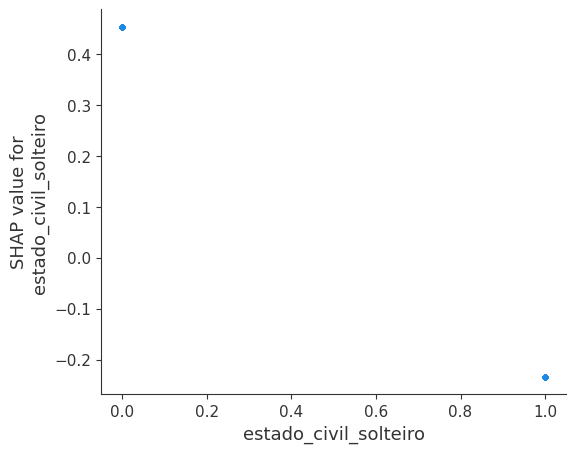

In [226]:
shap.dependence_plot('estado_civil_solteiro', shap_values.values, x_test, interaction_index=None)

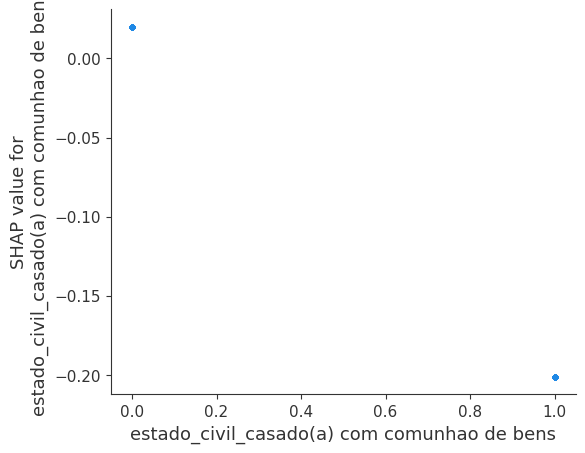

In [227]:
shap.dependence_plot('estado_civil_casado(a) com comunhao de bens', shap_values.values, x_test, interaction_index=None)

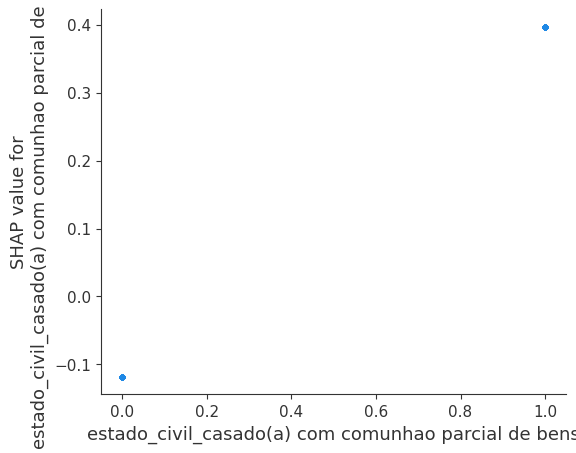

In [228]:
shap.dependence_plot('estado_civil_casado(a) com comunhao parcial de bens', shap_values.values, x_test, interaction_index=None)

#### 12.2.4.3 CHEQUE SEM FUNDO

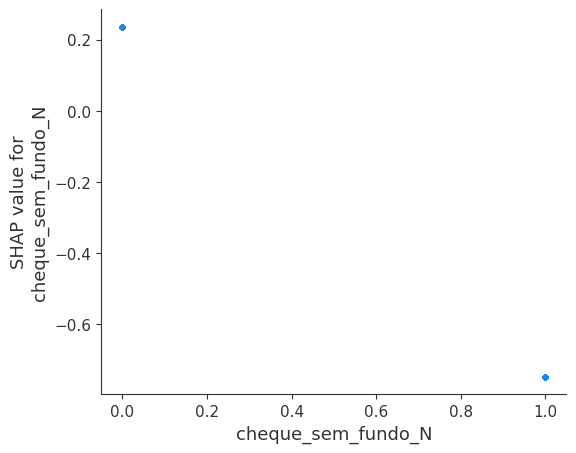

In [229]:
shap.dependence_plot('cheque_sem_fundo_N', shap_values.values, x_test, interaction_index=None)

#### 12.2.4.4 DEPENDENTES

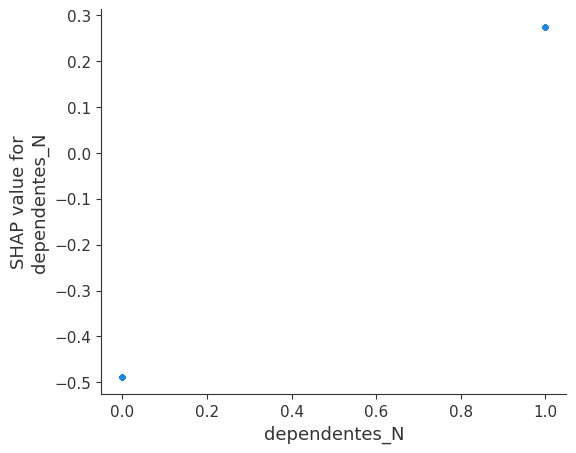

In [230]:
shap.dependence_plot('dependentes_N', shap_values.values, x_test, interaction_index=None)

#### 12.2.4.5 VALOR EMPRESTIMO X CHEQUE SEM FUNDO

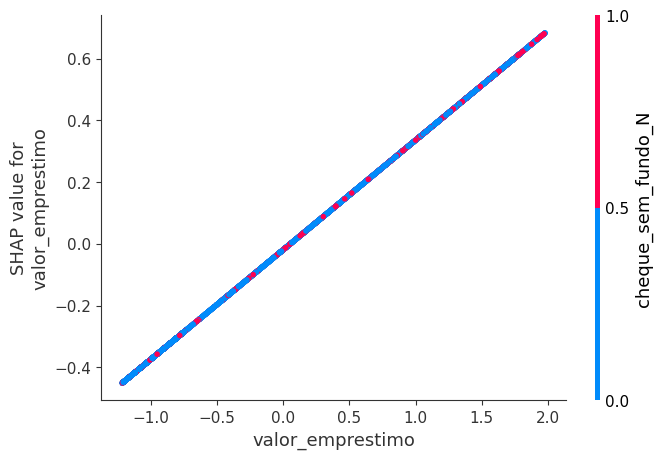

In [231]:
shap.dependence_plot('valor_emprestimo', shap_values.values, x_test, interaction_index='cheque_sem_fundo_N')

#### 12.2.5 Perfil Adimplente e Inadimplente (Clustering shap)

In [232]:
test_set = pd.read_csv(config['data']['test_path'])
train_set = pd.read_csv(config['data']['train_path'])

columns_select = ['dependentes', 'estado_civil', 'cheque_sem_fundo','valor_emprestimo', 'pago']


test_set = test_set[columns_select].copy()
train_set = train_set[columns_select].copy()


x_test = test_set.drop('pago', axis=1)
y_test = test_set['pago']

x_train = train_set.drop('pago', axis=1)
y_train = train_set['pago']

In [233]:
test_set['pago'] = test_set['pago'].apply(lambda x: 'inadimplente' if x==1 else 'adimplente')
test_set['dependentes'] = test_set['dependentes'].apply(lambda x: 'dependentes_sim' if x == 'S' else 'depedentes_nao')
test_set['cheque_sem_fundo'] = test_set['cheque_sem_fundo'].apply(lambda x: 'cheque_sim' if x == 'S' else 'cheque_nao')

In [234]:
ce_rare = RareLabelEncoder(n_categories=5, tol=0.05, variables=['estado_civil'], replace_with='outros')

ce_rare.fit(test_set)

test_set = ce_rare.transform(test_set)

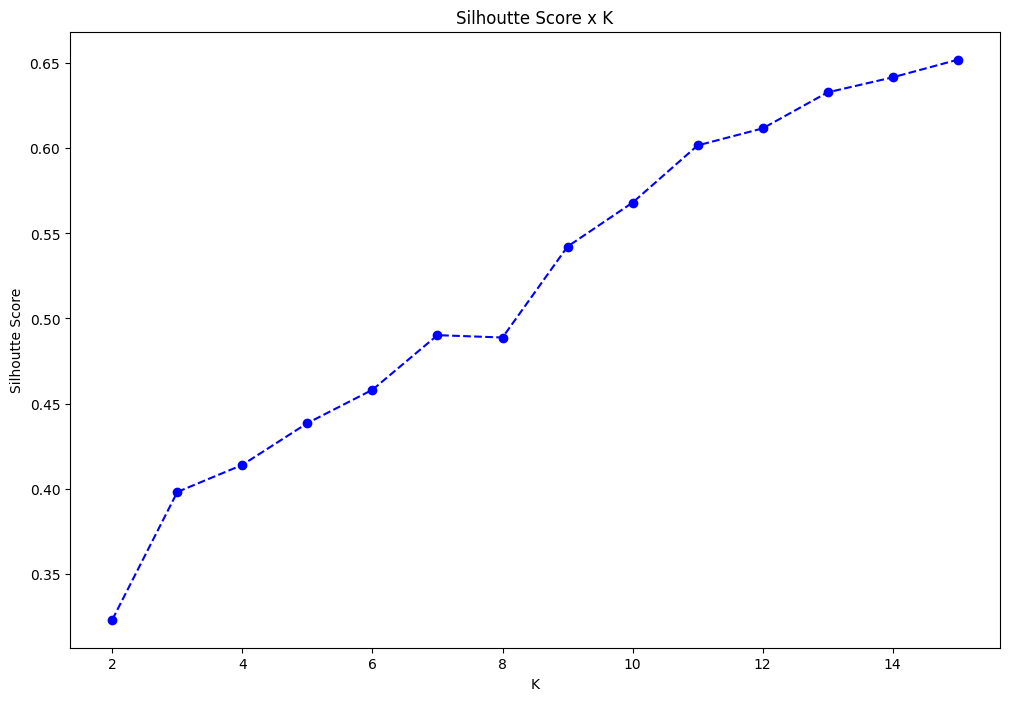

In [235]:
silhouette_score(df_shap_lr, 'kmeans', 2, 15)

In [236]:
cluster_model = KMeans(n_clusters=11, random_state=config['split']['seed'])
cluster_model.fit(df_shap_lr)
labels = cluster_model.predict(df_shap_lr)

In [237]:
test_set['cluster'] = labels
tabela_resultado_final(test_set)

# 13.0 RESULTADO DE NEGÓCIO

In [238]:
test_set = pd.read_csv(config['data']['test_path'])
columns_select = ['dependentes', 'estado_civil', 'cheque_sem_fundo', 'idade', 'valor_emprestimo', 'pago']
test_set = test_set[columns_select ]
x_test = test_set.drop('pago',axis=1)
y_test = test_set['pago']

## 13.1 CURVA AUC ROC CURVE

     Predito     0     1   All
Real                          
0             5506  2140  7646
1              573  1495  2068
All           6079  3635  9714



              precision    recall  f1-score   support

           0       0.91      0.72      0.80      7646
           1       0.41      0.72      0.52      2068

    accuracy                           0.72      9714
   macro avg       0.66      0.72      0.66      9714
weighted avg       0.80      0.72      0.74      9714



 ROC_AUC 0.79


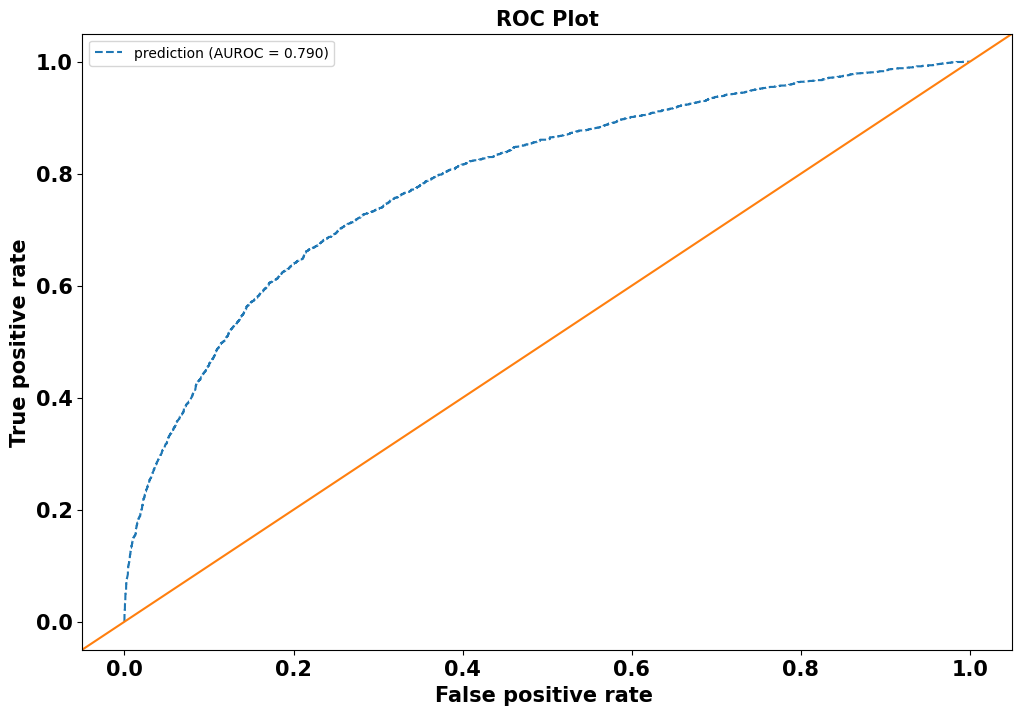

     Predito     0    1   All
Real                         
0             7451  195  7646
1             1587  481  2068
All           9038  676  9714



              precision    recall  f1-score   support

           0       0.82      0.97      0.89      7646
           1       0.71      0.23      0.35      2068

    accuracy                           0.82      9714
   macro avg       0.77      0.60      0.62      9714
weighted avg       0.80      0.82      0.78      9714





In [239]:
# recall class 1 = True positive rate (TP / (TP + FN)
# recall class 0 = 1 - False positive rate (FP / (FP + TN)

cm_roc_plot(search_xgb.best_estimator_, x_test, y_test, th=0.8)

## 13.2 PRECISION RECALL CURVE

In [242]:
plt.rcParams['font.family'] = 'DejaVu Sans'

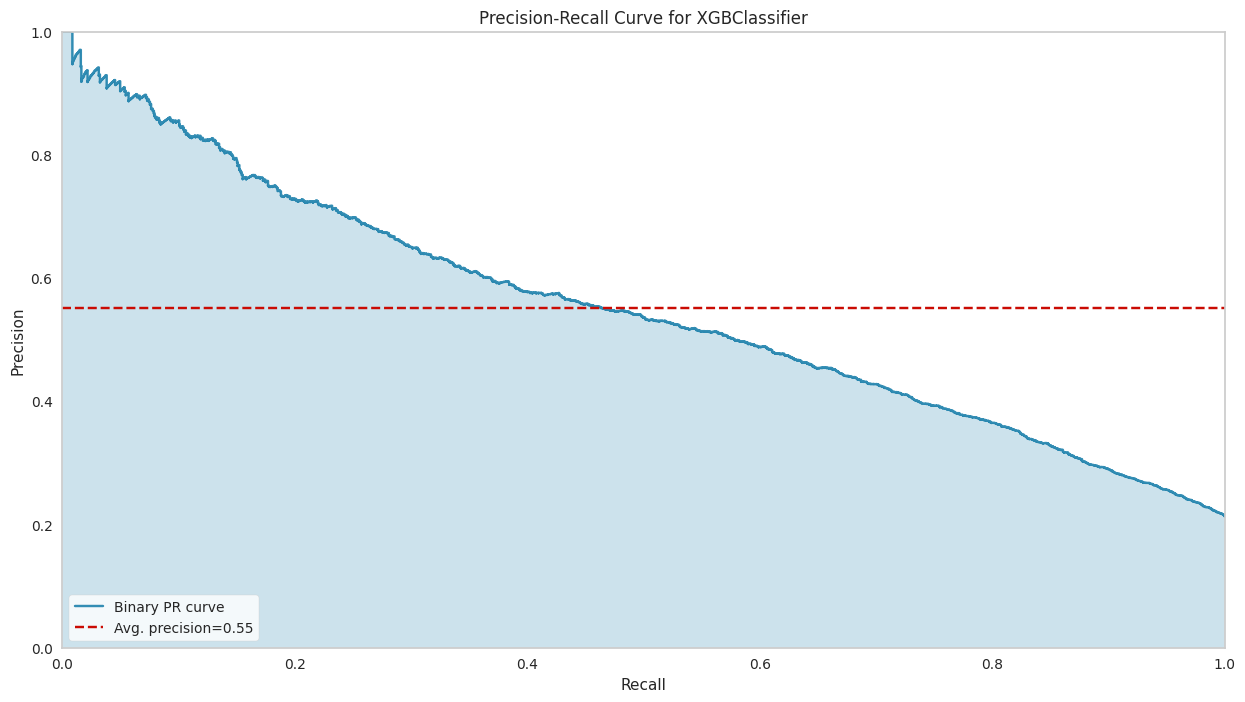

In [243]:
plt.figure(figsize=(15,8))
viz = PrecisionRecallCurve(search_xgb.best_estimator_)
viz.fit(x_test, y_test)
viz.score(x_test, y_test)
viz.show();

## 13.3 MAXIMIZANDO ROI

### 13.3.1 CENARIO ATUAL DO BANCO 

In [244]:
test_set = pd.read_csv(config['data']['test_path'])

df_business = test_set[['id', 'valor_emprestimo', 'multa', 'juros', 'valor_emprestimo_atualizado', 'pago']].dropna().reset_index(drop=True).copy()

columns_select = ['dependentes', 'estado_civil', 'cheque_sem_fundo', 'idade', 'valor_emprestimo', 'pago']
test_set = test_set[columns_select ]
x_test = test_set.drop('pago',axis=1)
y_test = test_set['pago']

In [245]:
df_business

id  valor_emprestimo     multa     juros  \
0     177315218           3456.80     74.55    313.79   
1     719949826          14015.09    496.88   8859.83   
2     195205898           6577.05    199.36   2842.30   
3     934339581          44760.10   1726.70  22989.90   
4     293910277          36560.00   6993.40   2107.81   
...         ...               ...       ...       ...   
9709  407266247           4771.25    127.13    419.78   
9710  884570198           1493.00   6273.16   3698.03   
9711  126279284           1685.00   1595.30    452.27   
9712  390947956          29584.17  55982.34  13830.44   
9713  915335571          10199.52    344.26   1288.02   

      valor_emprestimo_atualizado  pago  
0                         3845.14     0  
1                        23371.80     0  
2                         9618.71     0  
3                        69476.70     0  
4                        45661.21     0  
...                           ...   ...  
9709                      5318.16     0  
9710                     11464.19     0  
9711                      3732.57     1  
9712                     99396.95     1  
9713                     11831.80     0  

[9714 rows x 6 columns]

In [246]:
df_business['probabilidade'] = np.round(search_xgb.best_estimator_.predict_proba(x_test)[:,1],2)
df_business['pred_050']  = (search_xgb.best_estimator_.predict_proba(x_test)[:,1]>0.5).astype(int)

In [247]:
df_business.head()

id  valor_emprestimo    multa     juros  \
0  177315218           3456.80    74.55    313.79   
1  719949826          14015.09   496.88   8859.83   
2  195205898           6577.05   199.36   2842.30   
3  934339581          44760.10  1726.70  22989.90   
4  293910277          36560.00  6993.40   2107.81   

   valor_emprestimo_atualizado  pago  probabilidade  pred_050  
0                      3845.14     0           0.17         0  
1                     23371.80     0           0.72         1  
2                      9618.71     0           0.12         0  
3                     69476.70     0           0.32         0  
4                     45661.21     0           0.33         0

In [248]:
df_banco = df_business.groupby(['pago']).agg(
    valor_emprestimo = ('valor_emprestimo', 'sum'),
    juros = ('juros', 'sum'),
    multa = ('multa', 'sum'),
    emprestimo_atualizado = ('valor_emprestimo_atualizado', 'sum'),
    ).reset_index()

In [249]:
df_banco

pago  valor_emprestimo         juros         multa  emprestimo_atualizado
0     0      8.559284e+07  7.012149e+07  4.027410e+07           1.959884e+08
1     1      1.384250e+08  2.503221e+08  2.401617e+08           6.289088e+08

In [250]:
# cenario pago = 0
# o banco emprestou (8.559284e+07)
# o banco ganhou   (7.012149e+07 + 4.027410e+07)
# ROI  = (7.012149e+07 + 4.027410e+07) / (8.559284e+07)
# ROI = 129%
# lucro = 110395590

# cenario pago = 1
# o banco emprestou errado (1.384250e+08)
# o banco perdeu    (1.384250e+08)
# ROI = -100%
# lucro = - 138425000

# cenario geral

# o banco emprestou (8.559284e+07 + 1.384250e+08)
# o banco perdeu (1.384250e+08)
# o banco ganhou (7.012149e+07 + 4.027410e+07)

# ROI GERAL ( (7.012149e+07 + 4.027410e+07) - (1.384250e+08)) / (8.559284e+07 + 1.384250e+08)
# ROI Geral = -12.5%
# Lucro Geral = - 28029410

### 13.3.2 CENARIO DO XGBOOST COM TH 0.5 

In [251]:
df_050 = df_business.groupby(['pago', 'pred_050']).agg(
     valor_emprestimo = ('valor_emprestimo','sum'),
     juros = ('juros','sum'),
     multa = ('multa','sum'),
     emprestimo_atualizado = ('valor_emprestimo_atualizado','sum'),
     ).reset_index()

In [252]:
df_050

pago  pred_050  valor_emprestimo         juros         multa  \
0     0         0      3.603786e+07  2.344648e+07  1.792189e+07   
1     0         1      4.955498e+07  4.667501e+07  2.235221e+07   
2     1         0      4.237759e+06  1.201753e+07  1.958535e+07   
3     1         1      1.341873e+08  2.383045e+08  2.205763e+08   

   emprestimo_atualizado  
0           7.740623e+07  
1           1.185822e+08  
2           3.584063e+07  
3           5.930681e+08

In [253]:
# cenario pago = 0 pred_050 = 0 (acertou corretamente os adimplentes)
# o banco emprestou (3.603786e+07)
# o banco ganhou (2.344648e+07 + 1.792189e+07)
# o ROI = (2.344648e+07 + 1.792189e+07) / (3.603786e+07)
# o ROI = 115%
# Lucro = 41368370

# cenario pago = 0 e pred_50 = 1 (cliente era adimplente e calissificamos como inadimplente) (erramos)
# o banco deixou de emprestar (4.955498e+07)
# o banco deixou de lucar (4.667501e+07 + 2.235221e+07)
# o banco deixou de ter um ROI (4.667501e+07 + 2.235221e+07) / (4.955498e+07)
# o banco deixou de ter um ROI = 139%
# Lucro = 69027220

# o banco tem um custo de oportunidade de por exemplo (10%)
# ROI = 10%
# lucro = 4955498

# cenario pago = 1 e pred_50 = 0 (cliente era inadimplente e classificamos como adimplente) (erramos)
# o banco emprestou errado (4.237759e+06)
# o banco perdeu (4.237759e+06)
# ROI = -100%
# lucro = - 4237759


# cenario pago = 1 e pred_50 = 1 (acertou corretamente os inadimplentes)
# o banco deixou de emprestar de forma errada (1.341873e+08)
# ROI = 10%
# lucro = 13418730


# cenario geral
# o banco emprestou ( 3.603786e+07 + 4.955498e+07 + 4.237759e+06 + 1.341873e+08)
# o banco perdeu ( -4237759)
# o banco ganhou ( 41368370 + 4955498 + 13418730)
# ROI GERAL = ( 41368370 + 4955498 + 13418730 - 4237759 ) / ( 3.603786e+07 + 4.955498e+07 + 4.237759e+06 + 1.341873e+08)
# ROI GERAL = 24,8%
# LUCRO GERAL = 55504839

### 13.3.3 ESCOLHA DO MELHOR TH QUE MAXIMIZA O ROI

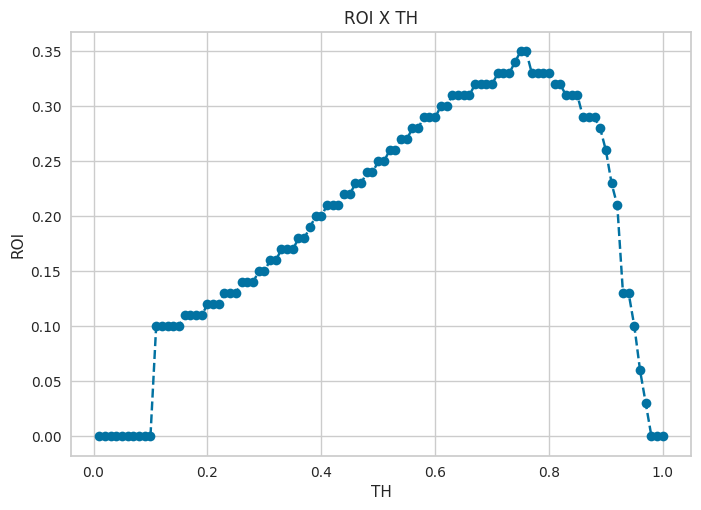

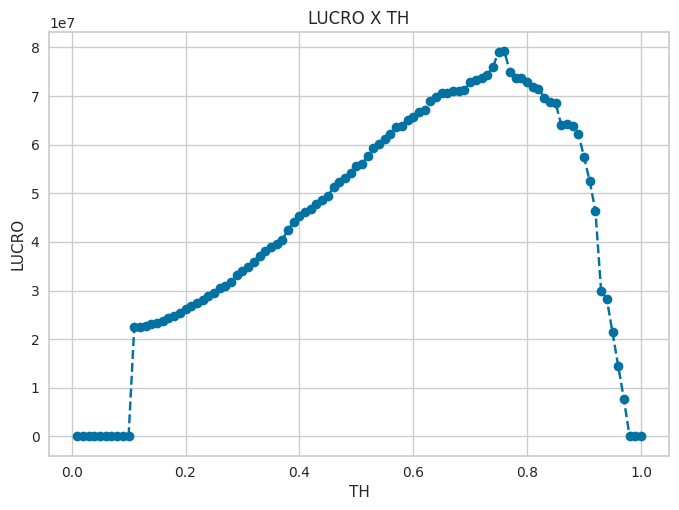

Max ROI value 0.35
Max LUCRO 79065477.126
BEST TH 0.75


In [256]:
maximizar_ROI(x_test, df_business, model = search_xgb.best_estimator_, custo_oportunidade=0.1)

## 13.4 VALOR DO EMPRESTIMO X PROBABILIDADE 

In [257]:
df_business

id  valor_emprestimo     multa     juros  \
0     177315218           3456.80     74.55    313.79   
1     719949826          14015.09    496.88   8859.83   
2     195205898           6577.05    199.36   2842.30   
3     934339581          44760.10   1726.70  22989.90   
4     293910277          36560.00   6993.40   2107.81   
...         ...               ...       ...       ...   
9709  407266247           4771.25    127.13    419.78   
9710  884570198           1493.00   6273.16   3698.03   
9711  126279284           1685.00   1595.30    452.27   
9712  390947956          29584.17  55982.34  13830.44   
9713  915335571          10199.52    344.26   1288.02   

      valor_emprestimo_atualizado  pago  probabilidade  pred_050  
0                         3845.14     0           0.17         0  
1                        23371.80     0           0.72         1  
2                         9618.71     0           0.12         0  
3                        69476.70     0           0.32         0  
4                        45661.21     0           0.33         0  
...                           ...   ...            ...       ...  
9709                      5318.16     0           0.19         0  
9710                     11464.19     0           0.39         0  
9711                      3732.57     1           0.25         0  
9712                     99396.95     1           0.92         1  
9713                     11831.80     0           0.37         0  

[9714 rows x 8 columns]

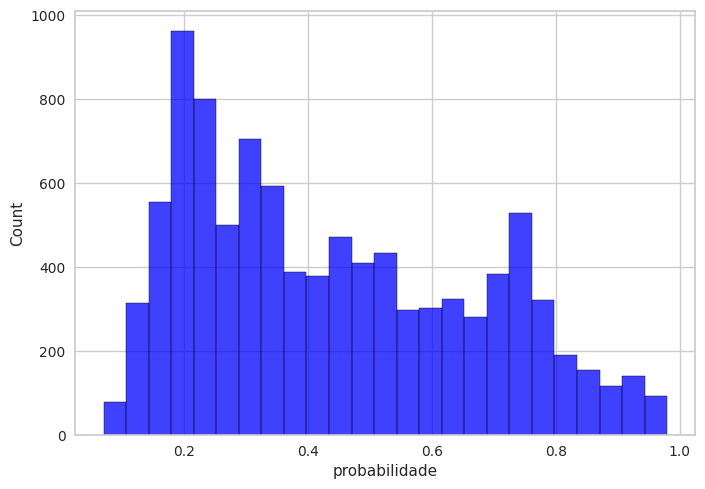

In [258]:
sns.histplot(df_business['probabilidade'], color='blue');

In [259]:
df_business.sort_values(['valor_emprestimo', 'probabilidade'],  ascending=[False, False]).head(20)

id  valor_emprestimo       multa       juros  \
3982  584445481        4863816.07  2481192.54  5560717.26   
2540  978067398        4269994.14  2184281.61  3739531.47   
1296  232763886        4005443.42  2052006.23   964648.13   
3616  587261589        3613664.22  7424466.43  7848505.14   
5805  487750943        3561731.58  5490451.00  6162657.74   
2983  579707879        3395560.92  1747065.00  3374086.13   
7495  437276438        3302165.11  3400734.11  8217207.30   
797   265634106        2935898.94  3034467.94  2275273.65   
7076  202350075        2925647.06  1814529.64  2704047.48   
4497  704879607        2824964.22  1754119.95  1372412.46   
5291  862470516        2778096.87  2876665.87  2887519.01   
3419  109340041        2663445.99   690503.75   788295.28   
849   485249377        2590605.57  2689174.57  3026081.28   
5666  835678537        2509392.56  2607961.56  2649624.48   
8214  558217554        2377417.60  1485591.96  1656055.07   
5852  142215579        2330077.12  2428646.12  2809818.61   
163   334396415        2212601.60    92446.80  1230279.19   
1683  633087975        2175087.83  1136828.44   481623.78   
2380  515120882        2130885.65  2229454.65  3734835.59   
1723  998661455        2116205.62  1107387.31  2228966.44   

      valor_emprestimo_atualizado  pago  probabilidade  pred_050  
3982                  12905725.87     1           0.93         1  
2540                  10193807.22     1           0.98         1  
1296                   7022097.78     1           0.97         1  
3616                  18886635.79     1           0.98         1  
5805                  15214840.32     1           0.91         1  
2983                   8516712.05     1           0.98         1  
7495                  14920106.52     1           0.98         1  
797                    8245640.53     1           0.98         1  
7076                   7444224.18     1           0.90         1  
4497                   5951496.63     1           0.91         1  
5291                   8542281.75     1           0.86         1  
3419                   4142245.02     1           0.76         1  
849                    8305861.42     1           0.94         1  
5666                   7766978.60     1           0.95         1  
8214                   5519064.63     1           0.76         1  
5852                   7568541.85     1           0.78         1  
163                    3535327.59     0           0.86         1  
1683                   3793540.05     0           0.77         1  
2380                   8095175.89     1           0.97         1  
1723                   5452559.37     1           0.93         1

### 13.4.1 INADIMPLENTE PAGO = 1

In [260]:
df_pago_1 = df_business[df_business['pago']==1].reset_index(drop=True).copy()
df_pago_1 = df_pago_1.sort_values(by='valor_emprestimo', ascending=False)

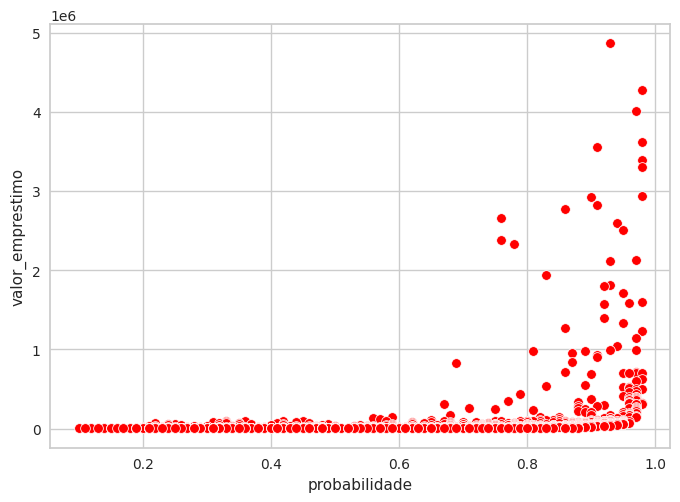

In [261]:
sns.scatterplot(x= 'probabilidade', y = 'valor_emprestimo', data = df_pago_1, color='red');

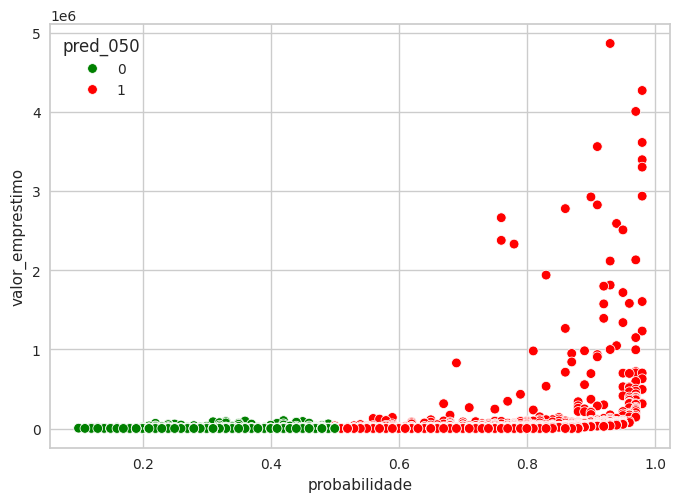

In [262]:
custom_palette = {0: 'green', 1: 'red'}
sns.set_palette(custom_palette.values())

sns.scatterplot(x= 'probabilidade', y = 'valor_emprestimo', data = df_pago_1, hue='pred_050');

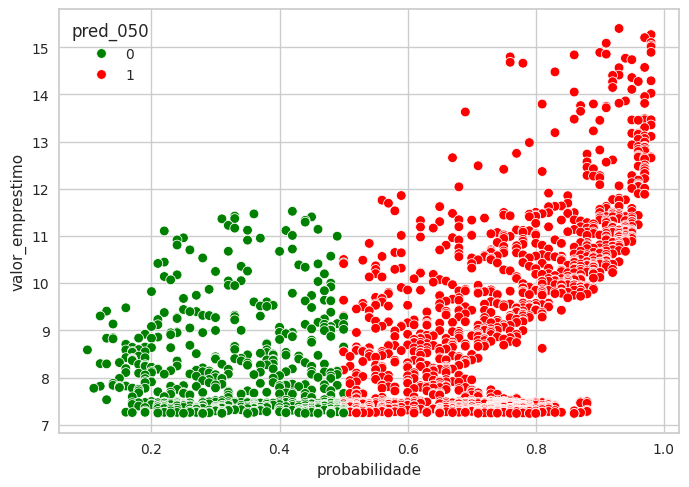

In [263]:
aux_1 = df_pago_1.copy() 
aux_1['valor_emprestimo'] = np.log(aux_1['valor_emprestimo'])
sns.scatterplot(x= 'probabilidade', y = 'valor_emprestimo', data = aux_1, hue='pred_050');

### 13.4.2 ADIMPLENTE PAGO=0

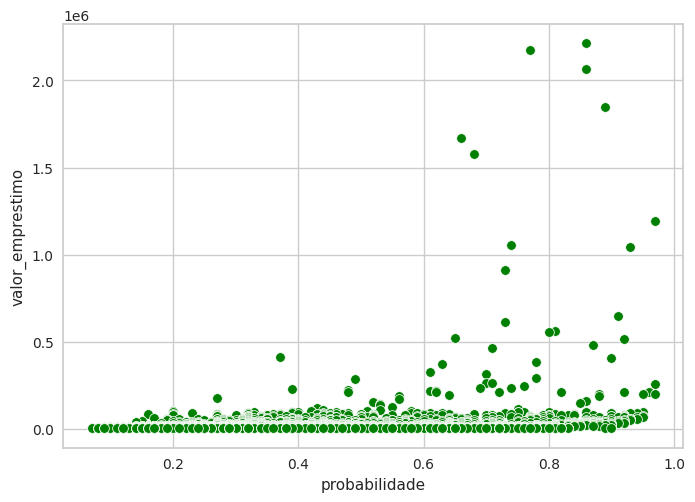

In [264]:
sns.set_palette("tab10")
df_pago_0 = df_business[df_business['pago']==0].reset_index(drop=True).copy()
df_pago_0 = df_pago_0.sort_values(by='valor_emprestimo', ascending=False)
sns.scatterplot(x= df_pago_0['probabilidade'], y = df_pago_0['valor_emprestimo'], color='green');

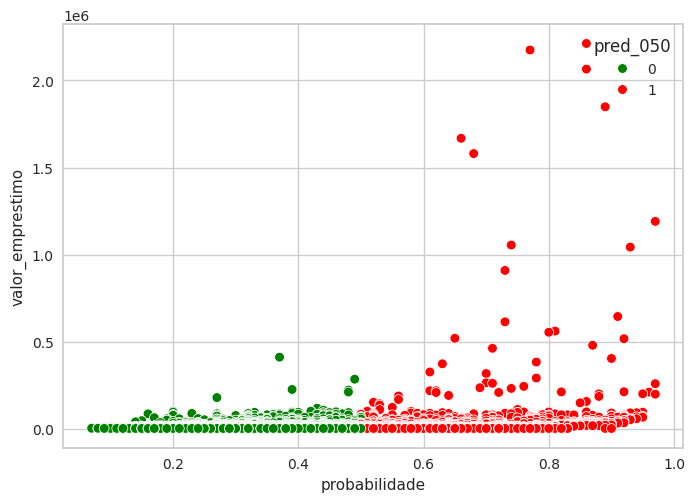

In [265]:
custom_palette = {0: 'green', 1: 'red'}

# Set the palette using set_palette
sns.set_palette(custom_palette.values())
sns.scatterplot(x= 'probabilidade', y = 'valor_emprestimo', data = df_pago_0, hue='pred_050');

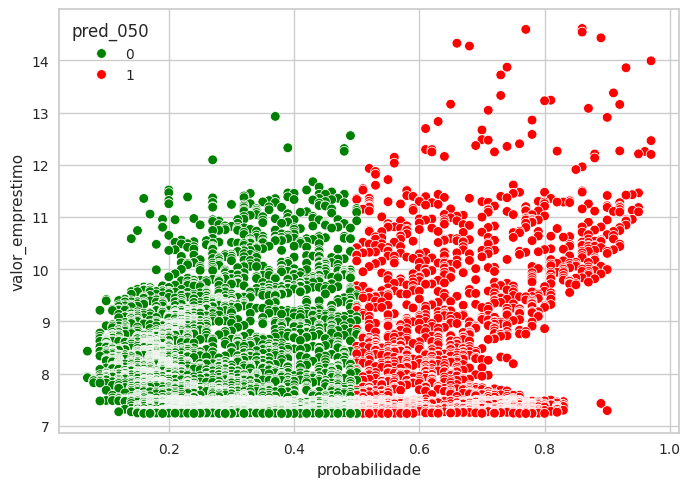

In [266]:
aux_0 = df_pago_0.copy() 
aux_0['valor_emprestimo'] = np.log(aux_0['valor_emprestimo'])
sns.scatterplot(x= 'probabilidade', y = 'valor_emprestimo', data = aux_0, hue='pred_050');

## 13.5 ROI REAL POR CLIENTE

In [268]:
df_business['ROI_real'] = df_business.apply(lambda x: ROI(x['pago'], 
                                                           x['valor_emprestimo'], 
                                                           x['juros'] + x['multa']), axis=1)

In [269]:
df_business.head(20)

id  valor_emprestimo      multa      juros  \
0   177315218           3456.80      74.55     313.79   
1   719949826          14015.09     496.88    8859.83   
2   195205898           6577.05     199.36    2842.30   
3   934339581          44760.10    1726.70   22989.90   
4   293910277          36560.00    6993.40    2107.81   
5   617577334          27055.30    1018.50    6365.45   
6   221834426           1642.00  193400.00   86643.20   
7   836143104           1763.00    1208.90     859.86   
8   817697488           1571.00    1117.34     154.43   
9   492445204         324743.40  423312.40  351984.73   
10  909223484           1729.08       5.44      40.12   
11  882930874          72090.45    2819.90   29943.79   
12  122794530           4537.72     117.79      75.95   
13  187384070           2269.82      27.07     572.52   
14  166984312           1582.00    6970.30    6140.81   
15  102446480           3331.13      69.53     260.12   
16  344373908           2084.68    1901.56    2401.25   
17  605449168           1699.00     118.77      83.70   
18  412902970           1518.00    1914.87     689.44   
19  615563976           3700.67      84.30     301.35   

    valor_emprestimo_atualizado  pago  probabilidade  pred_050  ROI_real  
0                       3845.14     0           0.17         0      0.11  
1                      23371.80     0           0.72         1      0.67  
2                       9618.71     0           0.12         0      0.46  
3                      69476.70     0           0.32         0      0.55  
4                      45661.21     0           0.33         0      0.25  
5                      34439.25     0           0.27         0      0.27  
6                     281685.20     1           0.28         0     -1.00  
7                       3831.76     0           0.29         0      1.17  
8                       2842.77     0           0.20         0      0.81  
9                    1100040.53     1           0.96         1     -1.00  
10                      1774.64     0           0.20         0      0.03  
11                    104854.14     0           0.38         0      0.45  
12                      4731.46     0           0.17         0      0.04  
13                      2869.41     0           0.21         0      0.26  
14                     14693.11     0           0.74         1      8.29  
15                      3660.78     0           0.21         0      0.10  
16                      6387.49     0           0.35         0      2.06  
17                      1901.47     0           0.32         0      0.12  
18                      4122.31     0           0.29         0      1.72  
19                      4086.32     0           0.20         0      0.10

count    9714.000000
mean        1.752629
std        11.158025
min        -1.000000
50%         0.330000
75%         0.940000
95%         7.764000
99%        32.638300
max       817.210000
Name: ROI_real, dtype: float64


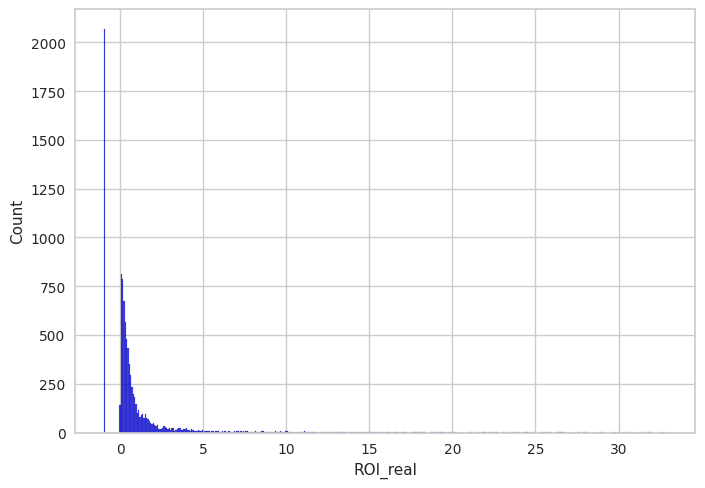

In [270]:
print(df_business['ROI_real'].describe(percentiles=[0.99, 0.95, 0.75, 0.5]))
sns.histplot(df_business[df_business['ROI_real']<33]['ROI_real'], color='blue');

## 13.6 VALOR ESPERADO x VARIANCIA

In [278]:
df_business['valor_esperado'] = df_business.apply(lambda x: valor_esperado(x['probabilidade'], x['valor_emprestimo'], x['juros'] + x['multa']), axis=1)

In [279]:
df_business

id  valor_emprestimo     multa     juros  \
0     177315218           3456.80     74.55    313.79   
1     719949826          14015.09    496.88   8859.83   
2     195205898           6577.05    199.36   2842.30   
3     934339581          44760.10   1726.70  22989.90   
4     293910277          36560.00   6993.40   2107.81   
...         ...               ...       ...       ...   
9709  407266247           4771.25    127.13    419.78   
9710  884570198           1493.00   6273.16   3698.03   
9711  126279284           1685.00   1595.30    452.27   
9712  390947956          29584.17  55982.34  13830.44   
9713  915335571          10199.52    344.26   1288.02   

      valor_emprestimo_atualizado  pago  probabilidade  pred_050  ROI_real  \
0                         3845.14     0           0.17         0      0.11   
1                        23371.80     0           0.72         1      0.67   
2                         9618.71     0           0.12         0      0.46   
3                        69476.70     0           0.32         0      0.55   
4                        45661.21     0           0.33         0      0.25   
...                           ...   ...            ...       ...       ...   
9709                      5318.16     0           0.19         0      0.11   
9710                     11464.19     0           0.39         0      6.68   
9711                      3732.57     1           0.25         0     -1.00   
9712                     99396.95     1           0.92         1     -1.00   
9713                     11831.80     0           0.37         0      0.16   

      valor_esperado  
0        -265.333807  
1       -7470.986669  
2        1887.414826  
3        2484.056497  
4       -5966.989899  
...              ...  
9709     -463.540387  
9710     5500.156064  
9711     1114.427500  
9712   -21632.415659  
9713    -2745.486056  

[9714 rows x 10 columns]

In [283]:
df_business['desvio_padrao'] = df_business.apply(lambda x: desvio_padrao(x['probabilidade'], 
                                                           x['valor_emprestimo'], 
                                                           x['juros'] + x['multa'],
                                                            x['valor_esperado']), axis=1)

In [284]:
df_business

id  valor_emprestimo     multa     juros  \
0     177315218           3456.80     74.55    313.79   
1     719949826          14015.09    496.88   8859.83   
2     195205898           6577.05    199.36   2842.30   
3     934339581          44760.10   1726.70  22989.90   
4     293910277          36560.00   6993.40   2107.81   
...         ...               ...       ...       ...   
9709  407266247           4771.25    127.13    419.78   
9710  884570198           1493.00   6273.16   3698.03   
9711  126279284           1685.00   1595.30    452.27   
9712  390947956          29584.17  55982.34  13830.44   
9713  915335571          10199.52    344.26   1288.02   

      valor_emprestimo_atualizado  pago  probabilidade  pred_050  ROI_real  \
0                         3845.14     0           0.17         0      0.11   
1                        23371.80     0           0.72         1      0.67   
2                         9618.71     0           0.12         0      0.46   
3                        69476.70     0           0.32         0      0.55   
4                        45661.21     0           0.33         0      0.25   
...                           ...   ...            ...       ...       ...   
9709                      5318.16     0           0.19         0      0.11   
9710                     11464.19     0           0.39         0      6.68   
9711                      3732.57     1           0.25         0     -1.00   
9712                     99396.95     1           0.92         1     -1.00   
9713                     11831.80     0           0.37         0      0.16   

      valor_esperado  desvio_padrao  
0        -265.333807    1444.360708  
1       -7470.986669   10493.911846  
2        1887.414826    3125.710748  
3        2484.056497   32409.223449  
4       -5966.989899   21470.481870  
...              ...            ...  
9709     -463.540387    2086.318970  
9710     5500.156064    5591.657901  
9711     1114.427500    1616.250221  
9712   -21632.415659   26965.714000  
9713    -2745.486056    5712.444029  

[9714 rows x 11 columns]

In [285]:
df_business.sort_values(['valor_esperado', 'desvio_padrao'],  ascending=[False, True]).head(20)

id  valor_emprestimo        multa        juros  \
2340  388730704           1418.00  17668900.00  13101489.35   
1108  665983594           1429.00  31990110.00  23218421.84   
6838  229125865           1644.00   5110119.00   3361436.28   
174   251138144           1635.00   3836272.39    640831.72   
8045  961921316           1464.00   2674650.00   1983252.98   
3032  797826910           1649.00   1004850.00    607532.31   
4510  187674000           1782.00   2973041.50   1443411.65   
6117  554061049           1591.00   1036200.00    723371.22   
2057  646723656           1603.00   1109402.21    200579.92   
4403  305403171           1546.00   2048556.27    627267.94   
9135  115740436           1490.00    856762.00    415957.95   
5267  789300752           1639.00   2279000.00    289433.00   
9360  564340706         217855.87    632849.74   1116601.71   
5647  596227983           1495.00   1122550.00    756823.21   
8613  741909337           1499.00    522106.14    359740.59   
6207  749436987         316827.35    830792.70   1386291.28   
3783  118097899           1471.00    351988.00    170890.18   
4162  887045063           1538.00    354945.60    250201.15   
2827  789856303           1644.00    370614.20    258725.77   
4810  234317727           1627.00    539701.44    206327.86   

      valor_emprestimo_atualizado  pago  probabilidade  pred_050  ROI_real  \
2340                  30771807.35     1           0.54         1     -1.00   
1108                  55209960.84     1           0.75         1     -1.00   
6838                   8473199.28     1           0.47         0     -1.00   
174                    4478739.11     1           0.26         0     -1.00   
8045                   4659366.98     1           0.73         1     -1.00   
3032                   1614031.31     1           0.25         0     -1.00   
4510                   4418235.15     1           0.74         1     -1.00   
6117                   1761162.22     1           0.37         0     -1.00   
2057                   1311585.13     0           0.37         0    817.21   
4403                   2677370.21     1           0.76         1     -1.00   
9135                   1274209.95     1           0.56         1     -1.00   
5267                   2570072.00     1           0.79         1     -1.00   
9360                   1967307.32     0           0.62         1      8.03   
5647                   1880868.21     1           0.72         1     -1.00   
8613                    883345.73     1           0.43         0     -1.00   
6207                   2533911.33     0           0.70         1      7.00   
3783                    524349.18     1           0.19         0     -1.00   
4162                    606684.75     1           0.30         0     -1.00   
2827                    630983.97     1           0.36         0     -1.00   
4810                    747656.30     1           0.49         0     -1.00   

      valor_esperado  desvio_padrao  
2340    1.415361e+07   1.533659e+07  
1108    1.380106e+07   2.390661e+07  
6838    4.489152e+06   4.228967e+06  
174     3.312632e+06   1.964528e+06  
8045    1.256565e+06   2.068570e+06  
3032    1.208874e+06   6.988961e+05  
4510    1.146959e+06   1.937989e+06  
6117    1.107941e+06   8.502967e+05  
2057    8.246956e+05   6.332390e+05  
4403    6.410229e+05   1.143460e+06  
9135    5.591624e+05   6.325012e+05  
5267    5.380761e+05   1.046811e+06  
9360    5.297209e+05   9.549043e+05  
5647    5.251480e+05   8.445077e+05  
8613    5.020081e+05   4.373231e+05  
6207    4.433461e+05   1.161184e+06  
3783    4.232518e+05   2.057027e+05  
4162    4.231413e+05   2.780179e+05  
2827    4.021857e+05   3.028723e+05  
4810    3.796777e+05   3.737534e+05

In [287]:
df_business.sort_values(['probabilidade', 'valor_esperado', 'desvio_padrao'],  ascending=[True, False, True]).head(20)

id  valor_emprestimo   multa    juros  \
2646  842553283           2779.27   47.45  1439.62   
938   837519479           4596.84  120.15  1368.62   
7361  678932012           2823.15   49.21  1057.01   
7396  960303335           2759.42   46.66   357.37   
2061  651743502           2610.96  508.98   968.23   
2257  691043906           2510.15   36.68   416.60   
8578  280521079           2638.42   41.82   415.65   
8858  151158986          10047.82  338.17  3892.36   
1417  430879560           5871.13  171.13  1949.22   
3991  457469388           6500.85  196.31  1897.22   
7551  325110810           4190.39  103.90  1092.67   
8178  987523466           1770.00  704.42    97.35   
5887  992473867           5542.78  157.99  1006.55   
4897  880545469           2632.50   41.58   783.07   
408   105205335           2936.29   53.73   426.21   
7682  450959968           3238.76   65.83   390.63   
6836  100681720           4587.59  119.78   468.09   
6397  925262630           6120.27  181.10   539.05   
5383  612775181           4991.57  135.94   469.38   
8713  113842092           2612.37   40.77   312.32   

      valor_emprestimo_atualizado  pago  probabilidade  pred_050  ROI_real  \
2646                      4266.34     0           0.07         0      0.54   
938                       6085.61     0           0.07         0      0.32   
7361                      3929.37     0           0.07         0      0.39   
7396                      3163.45     0           0.07         0      0.15   
2061                      4088.17     0           0.08         0      0.57   
2257                      2963.43     0           0.08         0      0.18   
8578                      3095.89     0           0.08         0      0.17   
8858                     14278.35     0           0.09         0      0.42   
1417                      7991.48     0           0.09         0      0.36   
3991                      8594.38     0           0.09         0      0.32   
7551                      5386.96     0           0.09         0      0.29   
8178                      2571.77     0           0.09         0      0.45   
5887                      6707.32     0           0.09         0      0.21   
4897                      3457.15     0           0.09         0      0.31   
408                       3416.23     0           0.09         0      0.16   
7682                      3695.22     0           0.09         0      0.14   
6836                      5175.46     0           0.09         0      0.13   
6397                      6840.42     0           0.09         0      0.12   
5383                      5596.89     0           0.09         0      0.12   
8713                      2965.46     0           0.09         0      0.14   

      valor_esperado  desvio_padrao  
2646     1188.426199    1088.543924  
938      1062.777298    1552.725238  
7361      831.164099    1002.567034  
7396      182.588499     807.144831  
2061     1150.156407    1109.092707  
2257      216.205605     803.958397  
8578      209.798806     839.893894  
8858     2945.478449    4086.203412  
1417     1401.116771    2287.015856  
3991     1320.035769    2459.554842  
7551      711.743581    1541.649724  
8178      570.310691     735.993679  
5887      560.881176    1919.512680  
4897      513.506488     989.373291  
408       172.479288     977.662733  
7682      123.890187    1057.504584  
6836      122.078581    1481.122280  
6397      104.512176    1957.603473  
5383      101.599880    1601.727862  
8713       86.198589     848.660578

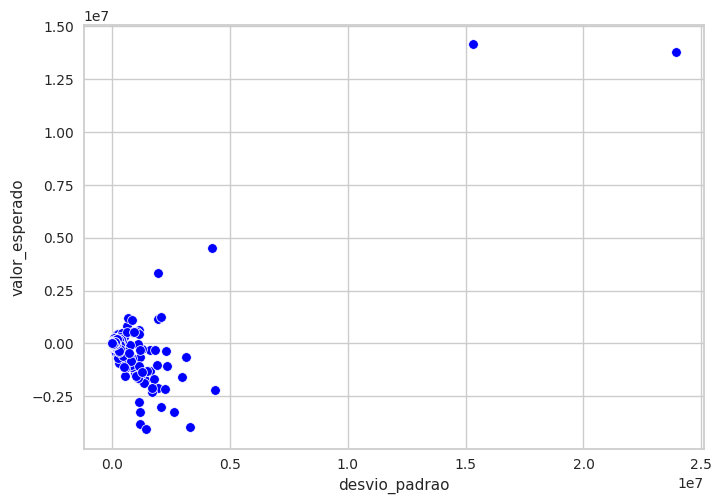

In [289]:
sns.scatterplot(x = 'desvio_padrao', y='valor_esperado', data = df_business, color='blue');

In [290]:
aux = df_business[df_business['valor_esperado']>0].copy()

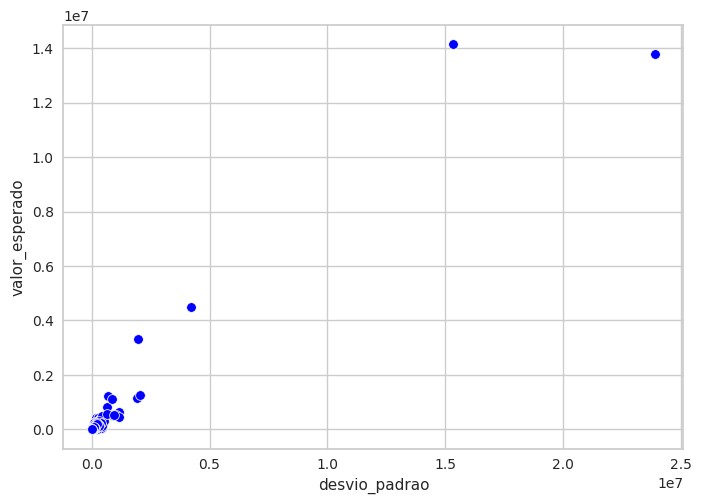

In [291]:
sns.scatterplot(x= 'desvio_padrao', y = 'valor_esperado', data = aux, color='blue');

In [293]:
aux = df_business[(df_business['valor_esperado']>0) & (df_business['desvio_padrao']<200000)].copy()

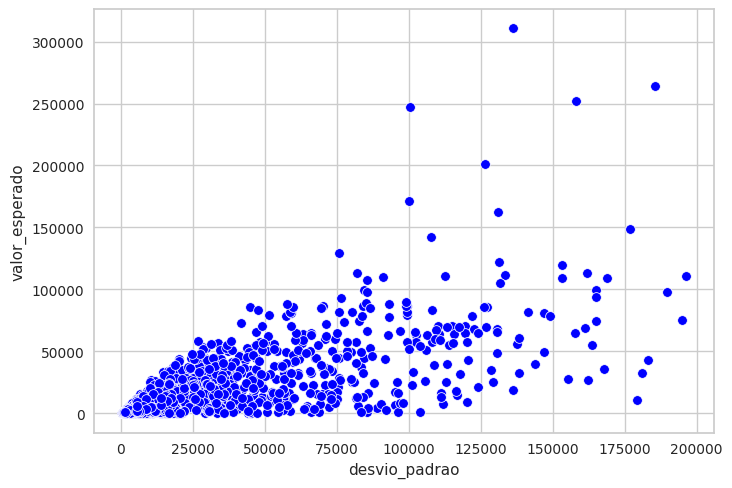

In [294]:
sns.scatterplot(x= 'desvio_padrao', y = 'valor_esperado', data = aux, color='blue');

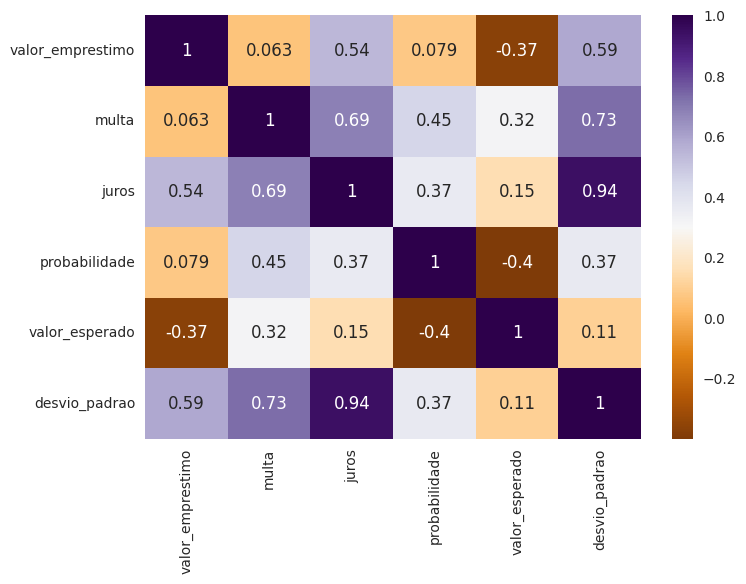

In [295]:
sns.heatmap(df_business[['valor_emprestimo', 'multa', 'juros','probabilidade', 'valor_esperado', 'desvio_padrao' ]].corr('spearman'), cmap='PuOr', annot=True);

## 13.7 CUMULATIVE GAIN AND LIFT CURVE

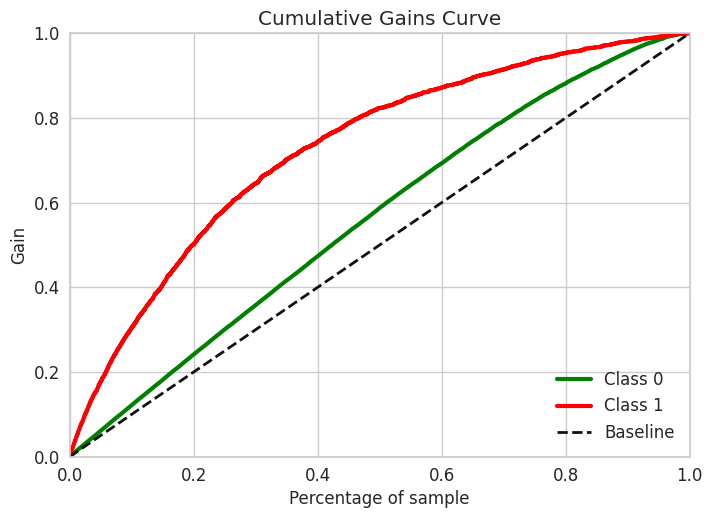

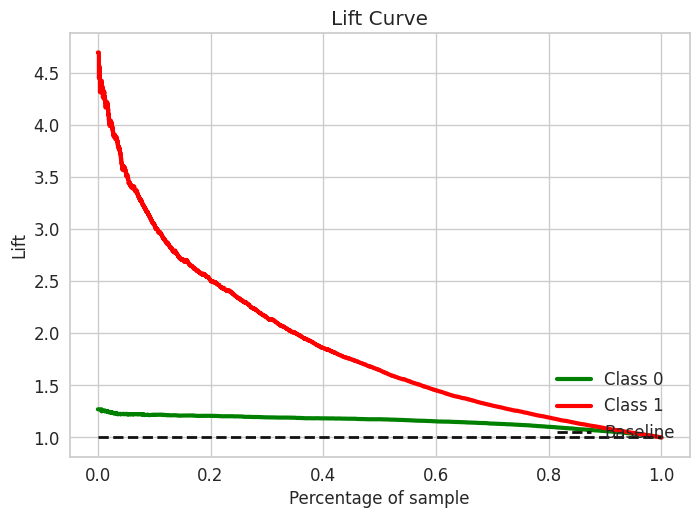

In [298]:
yhat_proba = search_xgb.best_estimator_.predict_proba(x_test)

skplt.metrics.plot_cumulative_gain(y_test, yhat_proba)

skplt.metrics.plot_lift_curve(y_test, yhat_proba);

## 13.8 PRECISION AND RECALL AT K

### 13.8.1 INADIMPLENTE

In [299]:
df_businnes_sort = df_business.sort_values('probabilidade', ascending=False)

In [300]:
df_businnes_sort

id  valor_emprestimo       multa       juros  \
8435  818944733         494673.41   889863.69  1284749.71   
1178  182371758         313080.99   823299.98  1366482.44   
2983  579707879        3395560.92  1747065.00  3374086.13   
7921  548558732        1231896.00  1330465.00  1479307.40   
797   265634106        2935898.94  3034467.94  2275273.65   
...         ...               ...         ...         ...   
2257  691043906           2510.15       36.68      416.60   
7361  678932012           2823.15       49.21     1057.01   
2646  842553283           2779.27       47.45     1439.62   
7396  960303335           2759.42       46.66      357.37   
938   837519479           4596.84      120.15     1368.62   

      valor_emprestimo_atualizado  pago  probabilidade  pred_050  ROI_real  \
8435                   2669286.81     1           0.98         1     -1.00   
1178                   2502863.41     1           0.98         1     -1.00   
2983                   8516712.05     1           0.98         1     -1.00   
7921                   4041668.40     1           0.98         1     -1.00   
797                    8245640.53     1           0.98         1     -1.00   
...                           ...   ...            ...       ...       ...   
2257                      2963.43     0           0.08         0      0.18   
7361                      3929.37     0           0.07         0      0.39   
2646                      4266.34     0           0.07         0      0.54   
7396                      3163.45     0           0.07         0      0.15   
938                       6085.61     0           0.07         0      0.32   

      valor_esperado  desvio_padrao  
8435   -4.412877e+05   3.737000e+05  
1178   -2.630238e+05   3.504007e+05  
2983   -3.225227e+06   1.192339e+06  
7921   -1.151063e+06   5.658333e+05  
797    -2.770986e+06   1.154389e+06  
...              ...            ...  
2257    2.162056e+02   8.039584e+02  
7361    8.311641e+02   1.002567e+03  
2646    1.188426e+03   1.088544e+03  
7396    1.825885e+02   8.071448e+02  
938     1.062777e+03   1.552725e+03  

[9714 rows x 11 columns]

In [301]:
df_businnes_sort['pago'].value_counts()

pago
0    7646
1    2068
Name: count, dtype: int64

In [302]:
df_businnes_sort['pago'].value_counts(normalize=True)

pago
0    0.787111
1    0.212889
Name: proportion, dtype: float64

In [303]:
len(df_businnes_sort)/5

1942.8

In [304]:
df_businnes_sort.iloc[:1942]['pago'].value_counts()

pago
1    1043
0     899
Name: count, dtype: int64

In [305]:
df_businnes_sort.iloc[:1942]['pago'].value_counts(normalize=True)

pago
1    0.537075
0    0.462925
Name: proportion, dtype: float64

In [306]:
1043/2068

0.5043520309477756

In [316]:
recall_at_1942 = recall_at_k_class(df_businnes_sort, k=1942, classe=1)
recall_at_1942

0.5

In [317]:
recall_at_500 = recall_at_k_class(df_businnes_sort, k=500, classe=1)
recall_at_500

0.18

In [321]:
precision_at_1942 = precision_at_k_class(df_businnes_sort, k=1942, classe=1)
precision_at_1942

0.54

In [322]:
precision_at_500 = precision_at_k_class(df_businnes_sort, k=500, classe=1)
precision_at_500

0.75

In [323]:
precision_at_100 = precision_at_k_class(df_businnes_sort, k=100, classe=1)
precision_at_100

0.91

### 13.8.2 ADIMPLENTE

In [324]:
df_businnes_sort = df_business.sort_values('probabilidade', ascending=True)
df_businnes_sort.head(50)

id  valor_emprestimo   multa    juros  \
938   837519479           4596.84  120.15  1368.62   
2646  842553283           2779.27   47.45  1439.62   
7396  960303335           2759.42   46.66   357.37   
7361  678932012           2823.15   49.21  1057.01   
8578  280521079           2638.42   41.82   415.65   
2257  691043906           2510.15   36.68   416.60   
2061  651743502           2610.96  508.98   968.23   
7682  450959968           3238.76   65.83   390.63   
5887  992473867           5542.78  157.99  1006.55   
1243  473356541           2493.68   36.03   254.13   
7551  325110810           4190.39  103.90  1092.67   
408   105205335           2936.29   53.73   426.21   
5383  612775181           4991.57  135.94   469.38   
1417  430879560           5871.13  171.13  1949.22   
3991  457469388           6500.85  196.31  1897.22   
8178  987523466           1770.00  704.42    97.35   
4897  880545469           2632.50   41.58   783.07   
3630  645331906           2748.06   46.20    48.17   
9069  888041087           4585.01  119.68   367.21   
8302  836152078           2821.12   49.12   203.95   
6836  100681720           4587.59  119.78   468.09   
8858  151158986          10047.82  338.17  3892.36   
8713  113842092           2612.37   40.77   312.32   
8291  856541589           2569.21   39.03   258.06   
6397  925262630           6120.27  181.10   539.05   
3346  767944477           5794.43  168.05  1764.52   
6975  827335592           2995.48   56.10  1053.30   
3382  674625105           5801.97  168.36  1377.46   
6419  531879767           5519.85  157.07  1075.16   
4188  178984245           3043.22   58.01   409.18   
9530  282697002           4962.45  134.78  2008.27   
974   343282374           5462.66  154.78   597.09   
5380  832380578           5737.00  165.76   508.46   
8106  662402650           5053.02  138.40   781.58   
155   750711031           2495.28   36.09   411.10   
5426  814016836           5136.06  141.72  2213.02   
3209  550591161           5239.73  145.87  2404.22   
8510  804440413           5019.44  137.06  1764.29   
540   260195551           4297.47  108.18   697.77   
2408  297688701           4414.21  112.85  1311.44   
6652  619290735           2173.83  290.42  1069.98   
625   351375651           2853.30   50.41   571.33   
589   684775536           3829.78   89.47   308.93   
6893  339177349           2881.31   51.53    60.02   
5667  201072913           7477.19  235.37  1724.77   
4724  783117177           2649.11   42.24   561.13   
1318  260735992           2873.78   51.23   479.66   
2901  850555509           4625.02  121.28   519.35   
5973  188227144          12019.41  417.06   434.82   
5717  227604217           2918.16   53.01   842.36   

      valor_emprestimo_atualizado  pago  probabilidade  pred_050  ROI_real  \
938                       6085.61     0           0.07         0      0.32   
2646                      4266.34     0           0.07         0      0.54   
7396                      3163.45     0           0.07         0      0.15   
7361                      3929.37     0           0.07         0      0.39   
8578                      3095.89     0           0.08         0      0.17   
2257                      2963.43     0           0.08         0      0.18   
2061                      4088.17     0           0.08         0      0.57   
7682                      3695.22     0           0.09         0      0.14   
5887                      6707.32     0           0.09         0      0.21   
1243                      2783.84     0           0.09         0      0.12   
7551                      5386.96     0           0.09         0      0.29   
408                       3416.23     0           0.09         0      0.16   
5383                      5596.89     0           0.09         0      0.12   
1417                      7991.48     0           0.09         0      0.36   
3991                      8594.38     0           0.09         0      0.32   
8178      

In [325]:
df_businnes_sort['pago'].value_counts()

pago
0    7646
1    2068
Name: count, dtype: int64

In [326]:
df_businnes_sort['pago'].value_counts(normalize=True)

pago
0    0.787111
1    0.212889
Name: proportion, dtype: float64

In [327]:
df_businnes_sort.iloc[:1942]['pago'].value_counts()

pago
0    1847
1      95
Name: count, dtype: int64

In [328]:
df_businnes_sort.iloc[:1942]['pago'].value_counts(normalize=True)

pago
0    0.951081
1    0.048919
Name: proportion, dtype: float64

In [329]:
1847/ 7646

0.24156421658383467

In [330]:
recall_at_1942 = recall_at_k_class(df_businnes_sort, k=1942, classe=0)
recall_at_1942

0.24

In [331]:
recall_at_1942 = precision_at_k_class(df_businnes_sort, k=1942, classe=0)
recall_at_1942

0.95

## 13.9 ALOCAÇÃO DE BUDGET LIMITADA

In [337]:
df_businnes_sort = df_business.sort_values(['probabilidade', 'valor_esperado', 'desvio_padrao'],  ascending=[True, False, True])

In [338]:
df_businnes_sort

id  valor_emprestimo       multa       juros  \
2646  842553283           2779.27       47.45     1439.62   
938   837519479           4596.84      120.15     1368.62   
7361  678932012           2823.15       49.21     1057.01   
7396  960303335           2759.42       46.66      357.37   
2061  651743502           2610.96      508.98      968.23   
...         ...               ...         ...         ...   
797   265634106        2935898.94  3034467.94  2275273.65   
7495  437276438        3302165.11  3400734.11  8217207.30   
2983  579707879        3395560.92  1747065.00  3374086.13   
3616  587261589        3613664.22  7424466.43  7848505.14   
2540  978067398        4269994.14  2184281.61  3739531.47   

      valor_emprestimo_atualizado  pago  probabilidade  pred_050  ROI_real  \
2646                      4266.34     0           0.07         0      0.54   
938                       6085.61     0           0.07         0      0.32   
7361                      3929.37     0           0.07         0      0.39   
7396                      3163.45     0           0.07         0      0.15   
2061                      4088.17     0           0.08         0      0.57   
...                           ...   ...            ...       ...       ...   
797                    8245640.53     1           0.98         1     -1.00   
7495                  14920106.52     1           0.98         1     -1.00   
2983                   8516712.05     1           0.98         1     -1.00   
3616                  18886635.79     1           0.98         1     -1.00   
2540                  10193807.22     1           0.98         1     -1.00   

      valor_esperado  desvio_padrao  
2646    1.188426e+03   1.088544e+03  
938     1.062777e+03   1.552725e+03  
7361    8.311641e+02   1.002567e+03  
7396    1.825885e+02   8.071448e+02  
2061    1.150156e+03   1.109093e+03  
...              ...            ...  
797    -2.770986e+06   1.154389e+06  
7495   -3.003763e+06   2.088814e+06  
2983   -3.225227e+06   1.192339e+06  
3616   -3.235932e+06   2.644128e+06  
2540   -4.066118e+06   1.427132e+06  

[9714 rows x 11 columns]

In [348]:
roi_at_budget(df_businnes_sort, budget=10000000)

pago  pred_050  valor_emprestimo       juros       multa  \
0     0         0        9415810.11  4171712.87  2792986.98   
1     1         0         577908.65   589966.27   863640.37   

   emprestimo_atualizado  
0            16380509.96  
1             2031515.29

Budget 9993718.76
Lucro value 6386791.2
ROI value 0.64
Numero de Clientes 2118


In [349]:
roi_at_budget(df_businnes_sort, budget=50000000)

pago  pred_050  valor_emprestimo        juros        multa  \
0     0         0       36037855.29  23446477.00  17921892.92   
1     0         1        7741543.59   8705988.67   5204992.48   
2     1         0        4237759.02  12017525.81  19585346.81   
3     1         1        1967359.54  19095093.95  27226168.81   

   emprestimo_atualizado  
0            77406225.21  
1            21652524.74  
2            35840631.64  
3            48288622.30

Budget 49984517.43999999
Lucro value 49074232.51
ROI value 0.98
Numero de Clientes 7171


In [333]:
df_050 = df_business.groupby(['pago', 'pred_050']).agg(
     valor_emprestimo = ('valor_emprestimo','sum'),
     juros = ('juros','sum'),
     multa = ('multa','sum'),
     emprestimo_atualizado = ('valor_emprestimo_atualizado','sum'),
     ).reset_index()

df_050

pago  pred_050  valor_emprestimo         juros         multa  \
0     0         0      3.603786e+07  2.344648e+07  1.792189e+07   
1     0         1      4.955498e+07  4.667501e+07  2.235221e+07   
2     1         0      4.237759e+06  1.201753e+07  1.958535e+07   
3     1         1      1.341873e+08  2.383045e+08  2.205763e+08   

   emprestimo_atualizado  
0           7.740623e+07  
1           1.185822e+08  
2           3.584063e+07  
3           5.930681e+08